# Start

Before starting work, you need to register the paths to the Python modules and to import the main hi-chi module.

In [1]:
import sys
sys.path.append("../bin")
sys.path.append("../python_modules")

In [2]:
import pyHiChi as hichi

The *hichi_primitives* module contains some auxiliary Python functions and classes that will be used later.

In [3]:
import hichi_primitives as hp

The *numpy* and *time* modules are necessary to work with arrays and to take time measurements, respectively.

In [4]:
import numpy as np

In [5]:
import time

# Spherical pulse

Let's set the next parameters of the spherical pulse.

In [6]:
wavelength = 1.0           # the wavelength of the pulse
pulselength = 2.0          # the pulse length is equal to 2 wavelengths
phase = 0.0                # the phase
R0 = 16                    # the distance to the geometrical center
totalPower = hichi.c       # the input power of the electromagnetic radiation   
f_number = 0.3             # f-number defines the opening angle of the sector
openingAngle = np.arctan(1.0/(2.0*f_number))
edgeSmoothingAngle = 0.5   # the smoothing angle of the transverse shape

We consider the longitudinal shape of the following form. The *block* function from the *hichi_primitives* module is a rectangle function:
\begin{equation*}
\text{block}(x, a, b)=
\begin{cases}
1, x \in [a, b] \\
0, x \notin [a, b]
\end{cases}
\end{equation*}

In [7]:
def longitudinalFieldVariation(x):
    return np.sin(2*hichi.pi*x/wavelength + phase) * \
           (np.cos(hichi.pi*x/pulselength))**2 * \
           hp.block(x, -0.5*pulselength, 0.5*pulselength)

To plot this function on a graph, we use *matplotlib*. The following code sets up the plotting area and plots the longitudinal field variation function.

In [8]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, AutoLocator, \
                              FixedLocator, FormatStrFormatter

def plot_graph(X, Y, xlabel, ylabel, label):
    fig = plt.figure(dpi=500)
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(X, Y, label=label)
    ax.grid(which='major', color='black')
    ax.grid(which='minor', color='lightgray')
    ax.xaxis.set_major_locator(FixedLocator([0.0]))
    ax.yaxis.set_major_locator(FixedLocator([0.0]))
    ax.xaxis.set_minor_locator(AutoLocator())
    ax.xaxis.set_minor_formatter(FormatStrFormatter("%0.1f"))
    ax.yaxis.set_minor_locator(AutoLocator())
    ax.yaxis.set_minor_formatter(FormatStrFormatter("%0.1f"))
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.legend()
    plt.show()

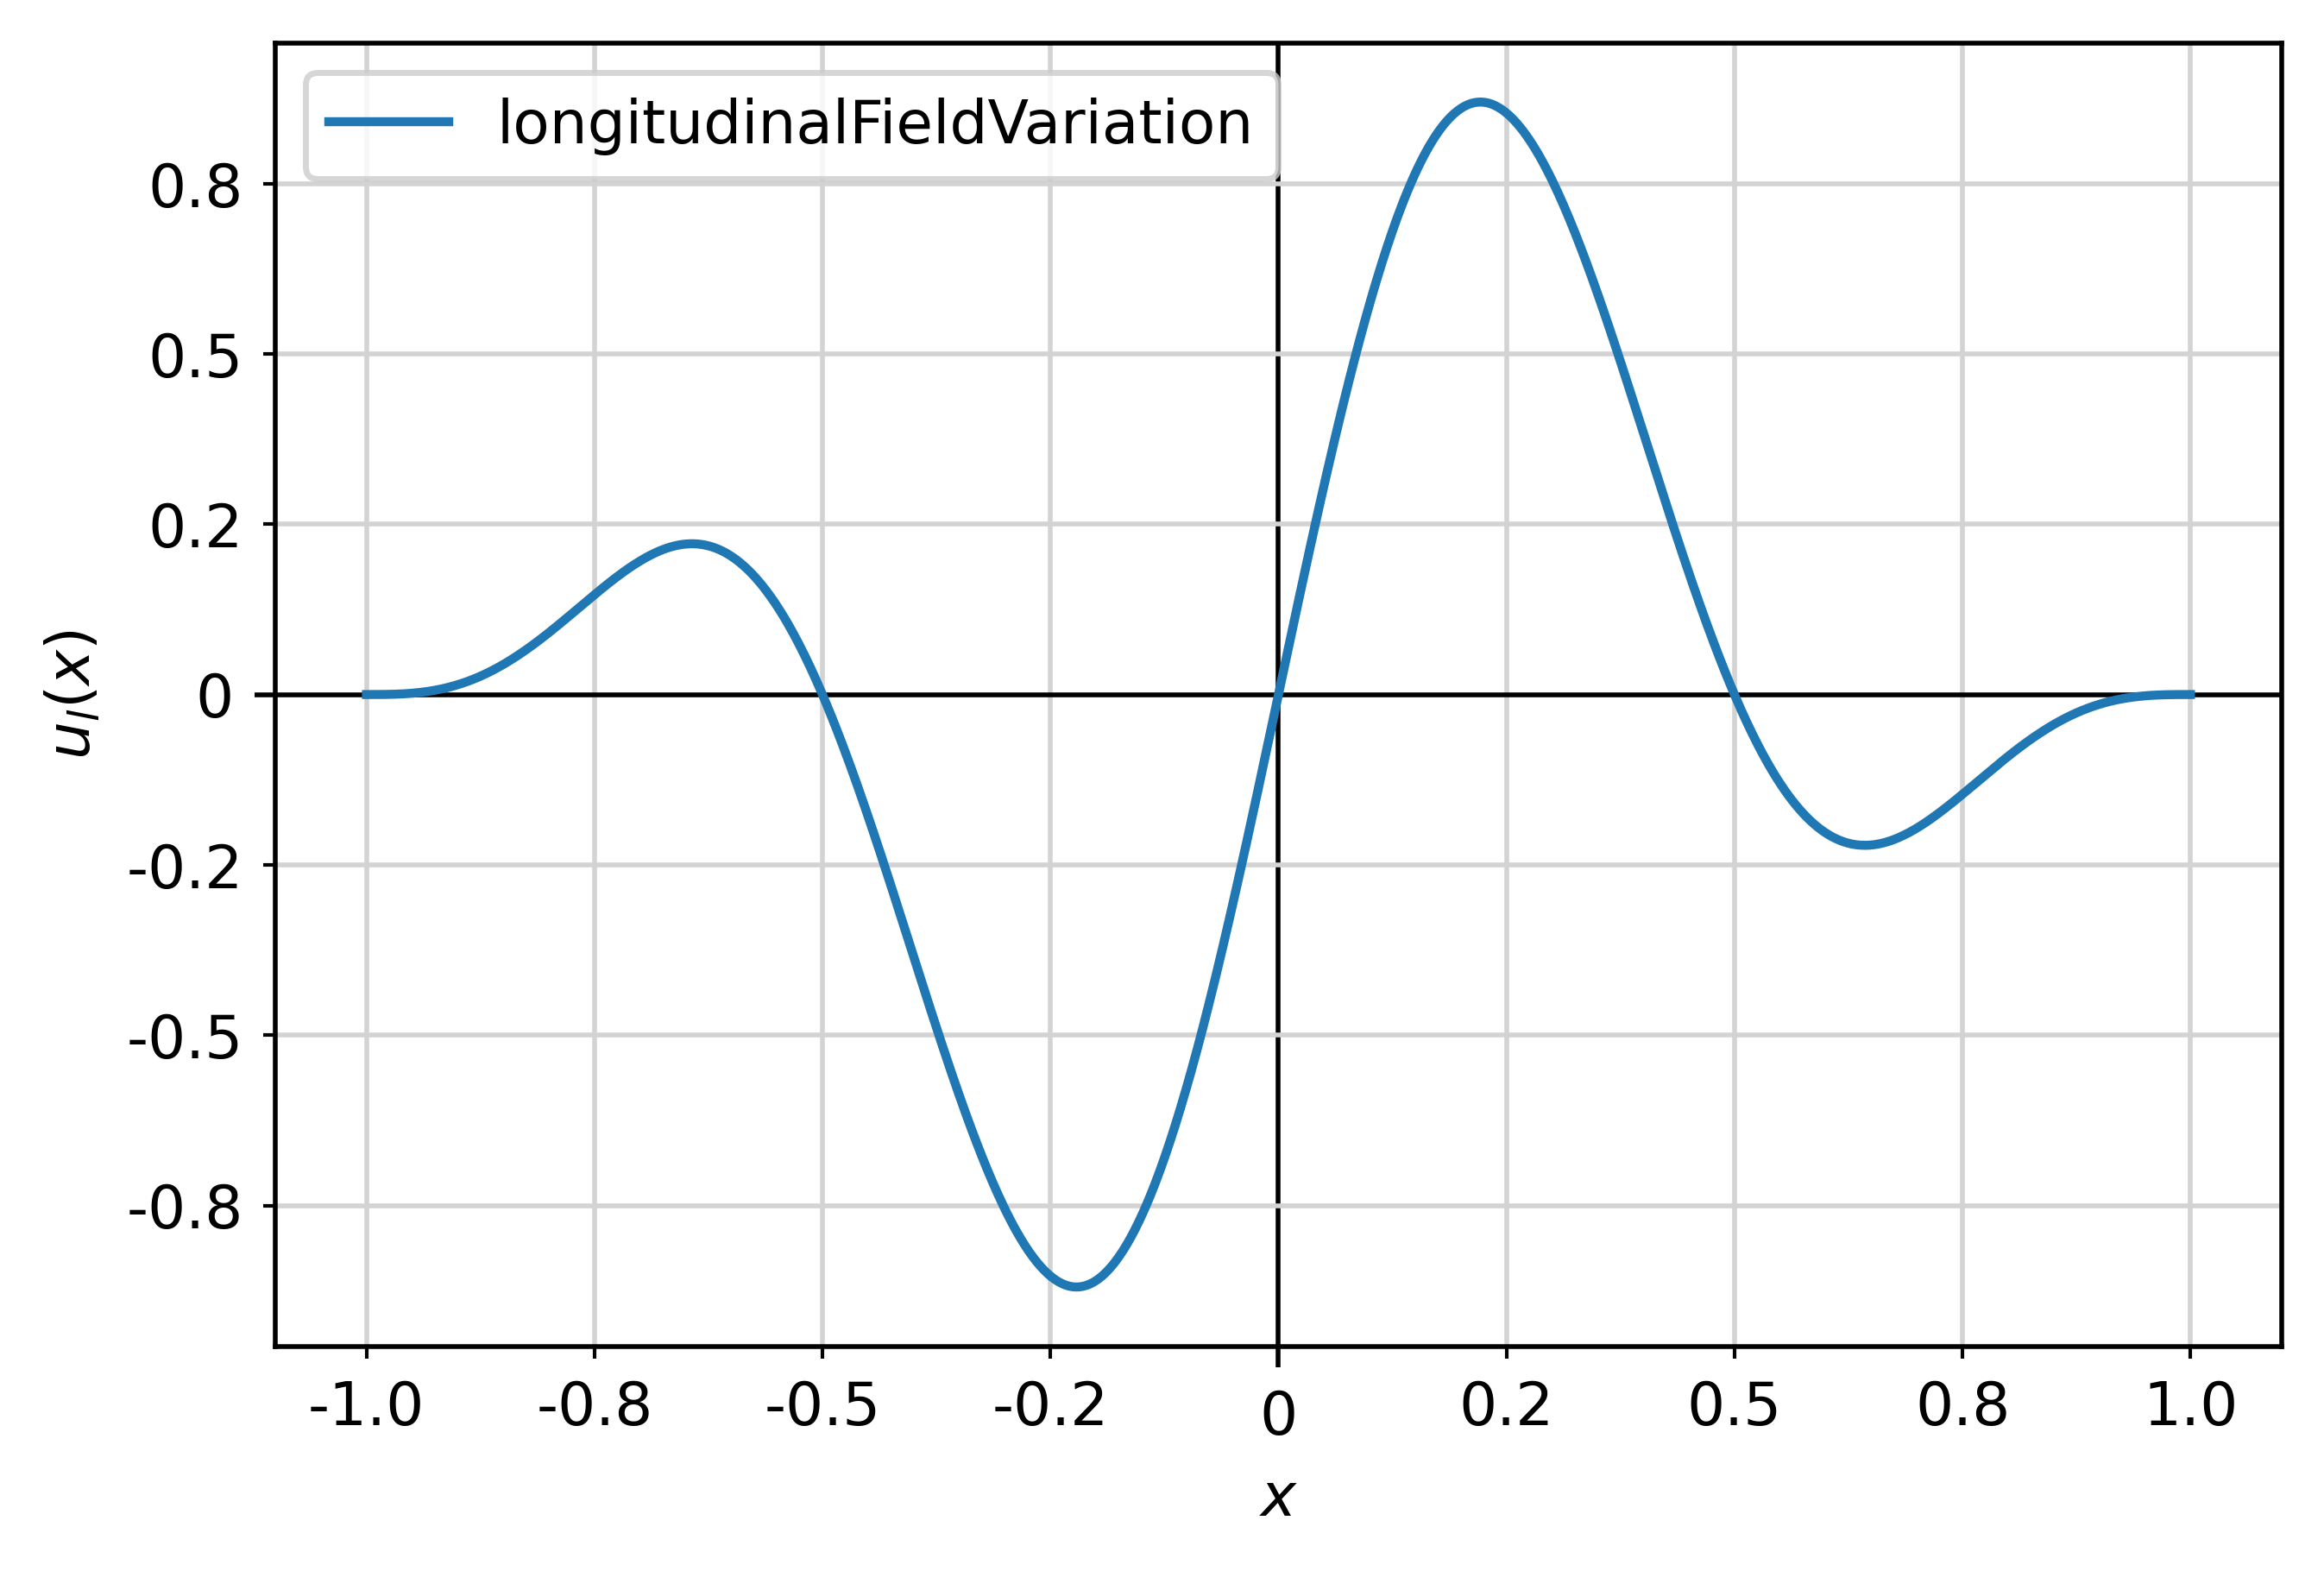

In [9]:
func = np.vectorize(longitudinalFieldVariation)
N_points = 1000
X = np.linspace(-1.0, 1.0, N_points)
Y = func(X)
plot_graph(X, Y, "$x$", "$u_l(x)$", "longitudinalFieldVariation")

Transverse shape of the pulse in a simple case is just a rectangle bounding a spherical sector. However, we introduce an edge smoothing angle to provide a smooth transition to the zero field in the outer region.

In [10]:
def transverseShape(angle):  # angle >= 0
    angle1 = openingAngle - edgeSmoothingAngle*0.5
    angle2 = openingAngle + edgeSmoothingAngle*0.5
    return hp.block(angle, -1.0, angle1) + \
           (np.cos(0.5*hichi.pi*(angle - angle1)/edgeSmoothingAngle)**2 * \
            hp.block(angle, angle1, angle2) if (not edgeSmoothingAngle == 0.0) \
            else 0.0)

You can see the graphical representation of the transverse shape function below.

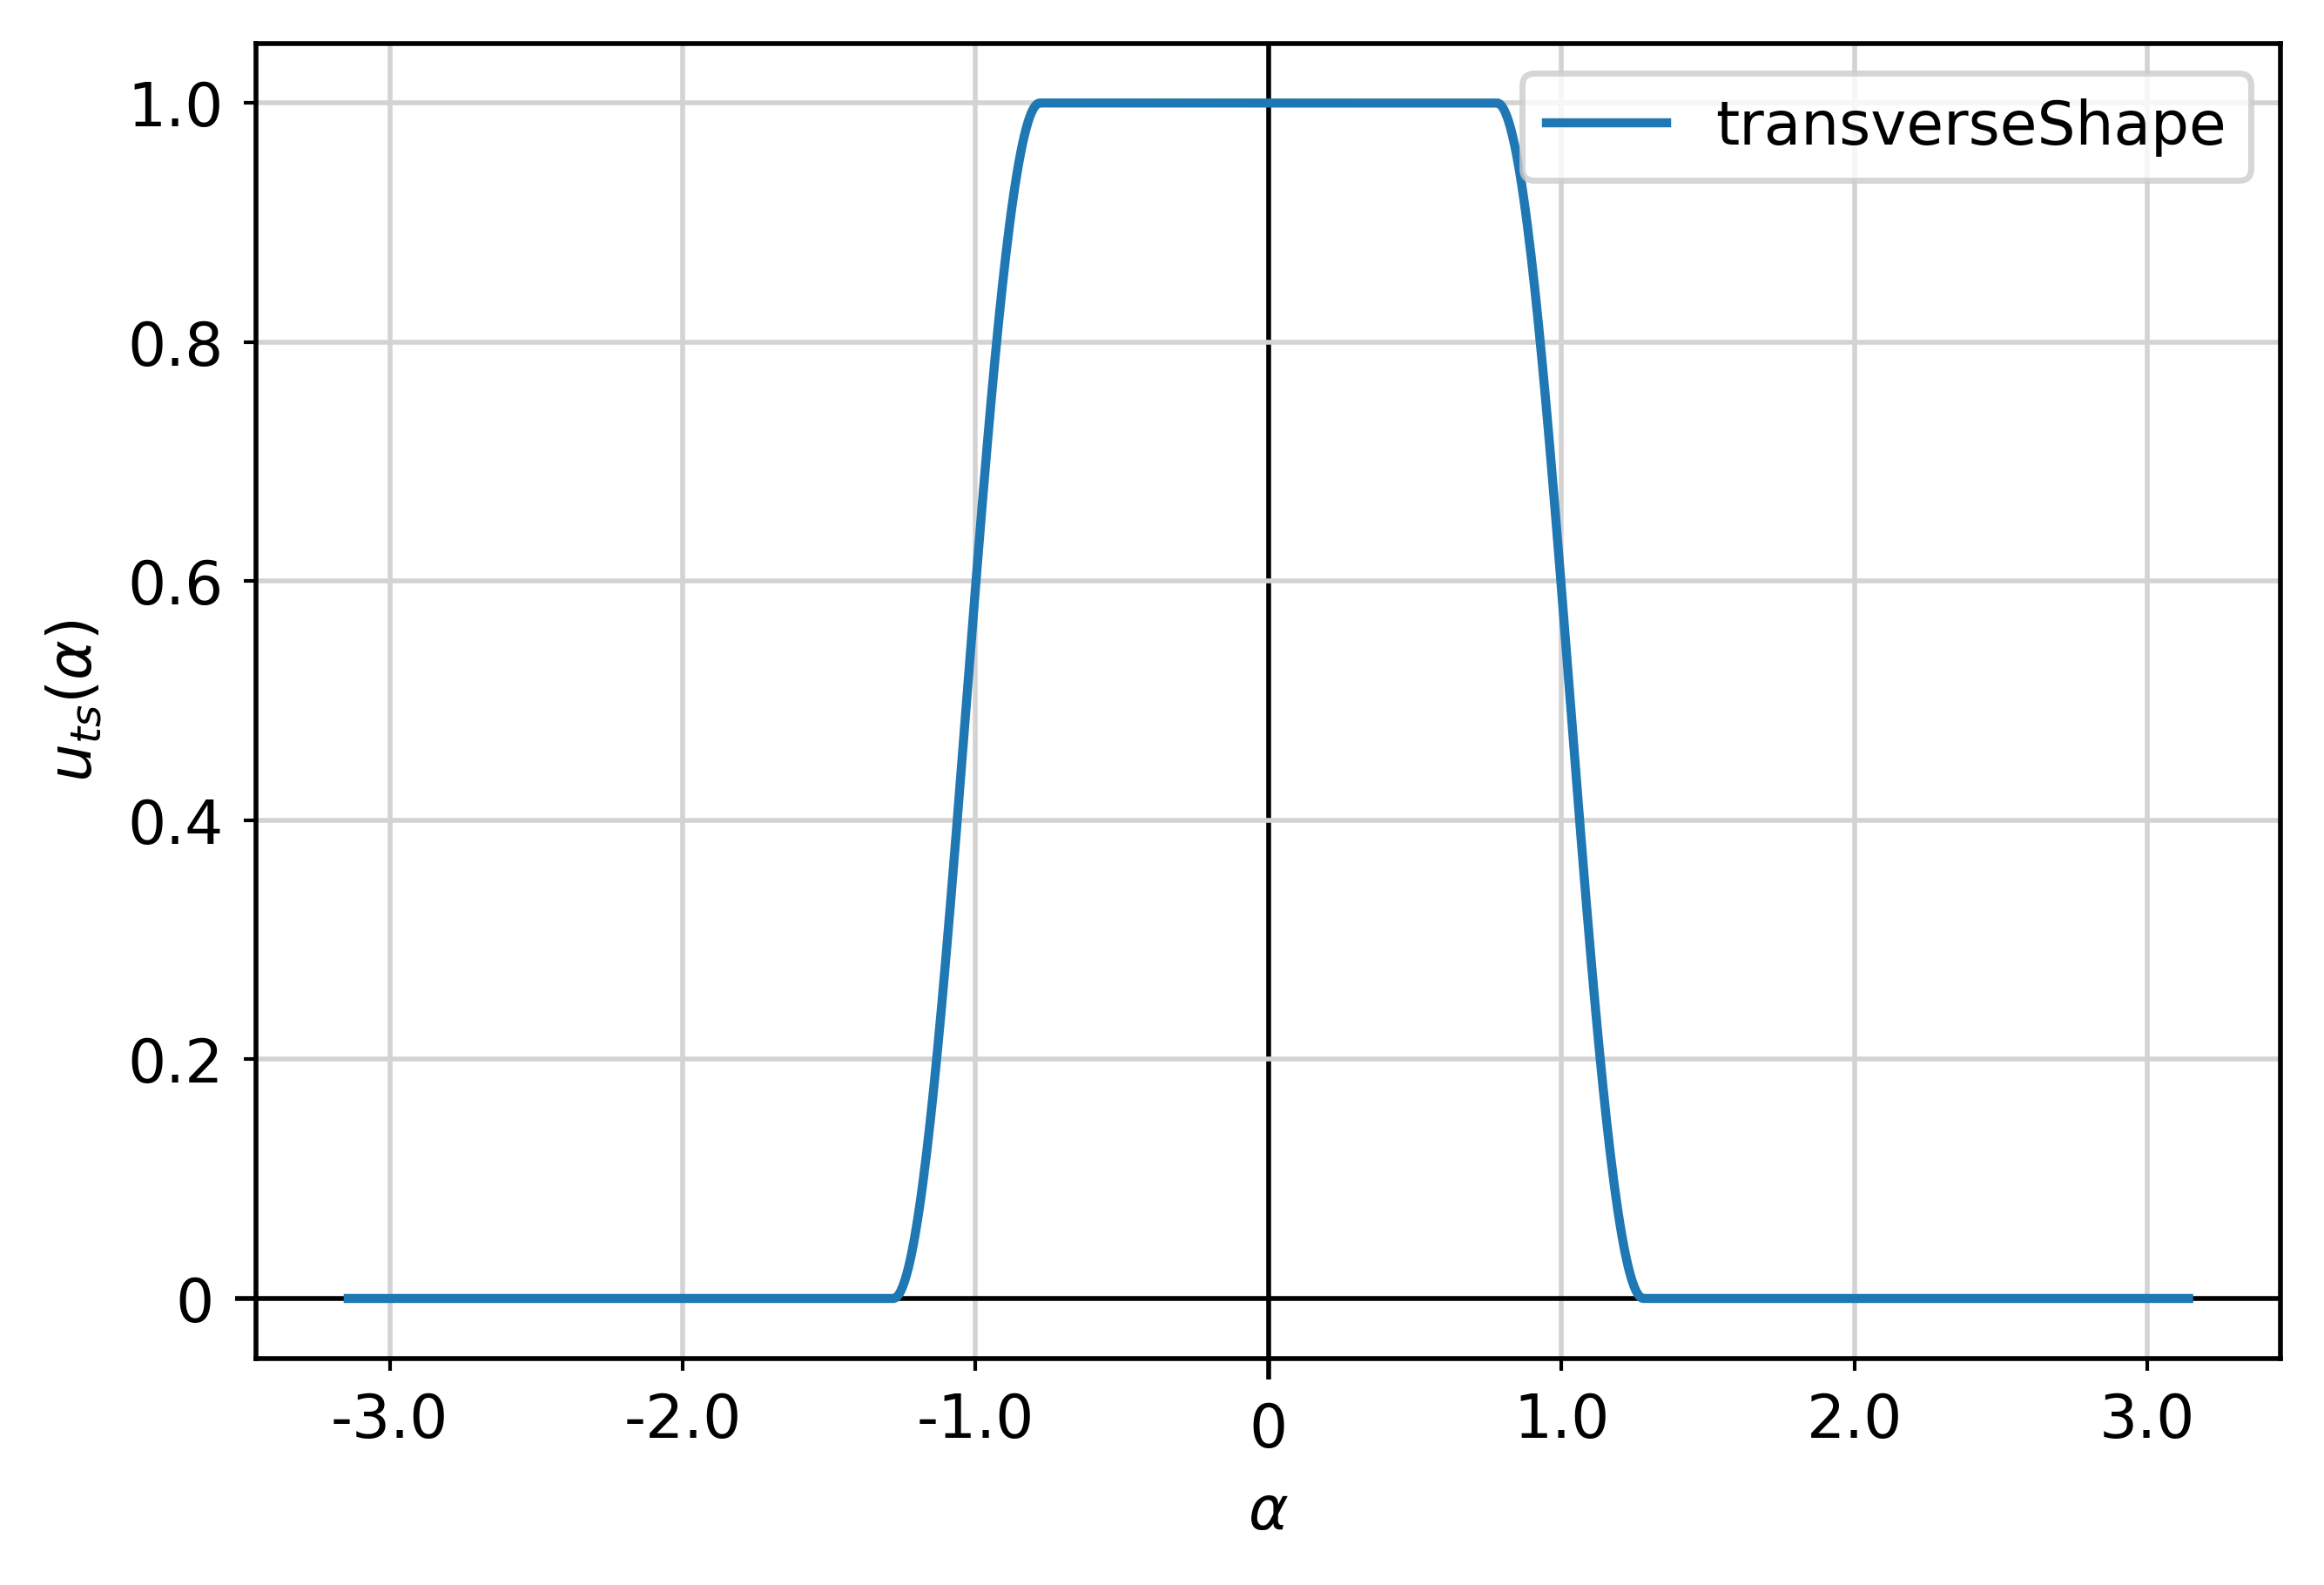

In [11]:
def symTransverseShape(angle):
    return transverseShape(abs(angle))
func = np.vectorize(symTransverseShape)
N_points = 1000
X = np.linspace(-hichi.pi, hichi.pi, N_points)
Y = func(X)
plot_graph(X, Y, "$\\alpha$", "$u_{ts}(\\alpha)$", "transverseShape")

The *mask* function combines the longitudinal and transverse shapes of a spherical pulse. The amplitude is calculated based on the given input power.

In [12]:
amp = np.sqrt(totalPower*4.0/(hichi.c*(1.0 - np.cos(openingAngle))))

In [13]:
def mask(x, y, z):
    R = np.sqrt(x*x + y*y + z*z)
    if(R > 1e-5):
        angle = np.arcsin(np.sqrt(y*y + z*z)/R)
        return (amp/R) * longitudinalFieldVariation(R - R0) * \
                                  transverseShape(angle)*(x < 0)
    else:
        return 0

To show the final pulse a colormap can be used.

In [14]:
N = 1024
a = -20
b = 20
step = (b - a)/N
u_values = np.array([[mask(a + i*step, a + j*step, 0) for i in range(N)] \
                                                      for j in range(N)])

In [15]:
def plot_im(values, vmin=0.0, vmax=0.5, a=(-20, -20), b=(20, 20)):
    fig = plt.figure(dpi=500)
    ax = fig.add_subplot(1, 1, 1)
    ax.tick_params(axis='both', which='major')
    im = ax.imshow(values, cmap='RdBu', interpolation='none',
                   extent=(a[0], b[0], a[1], b[1]), vmin=vmin, vmax=vmax)
    fig.colorbar(im, ax=ax)
    plt.show()

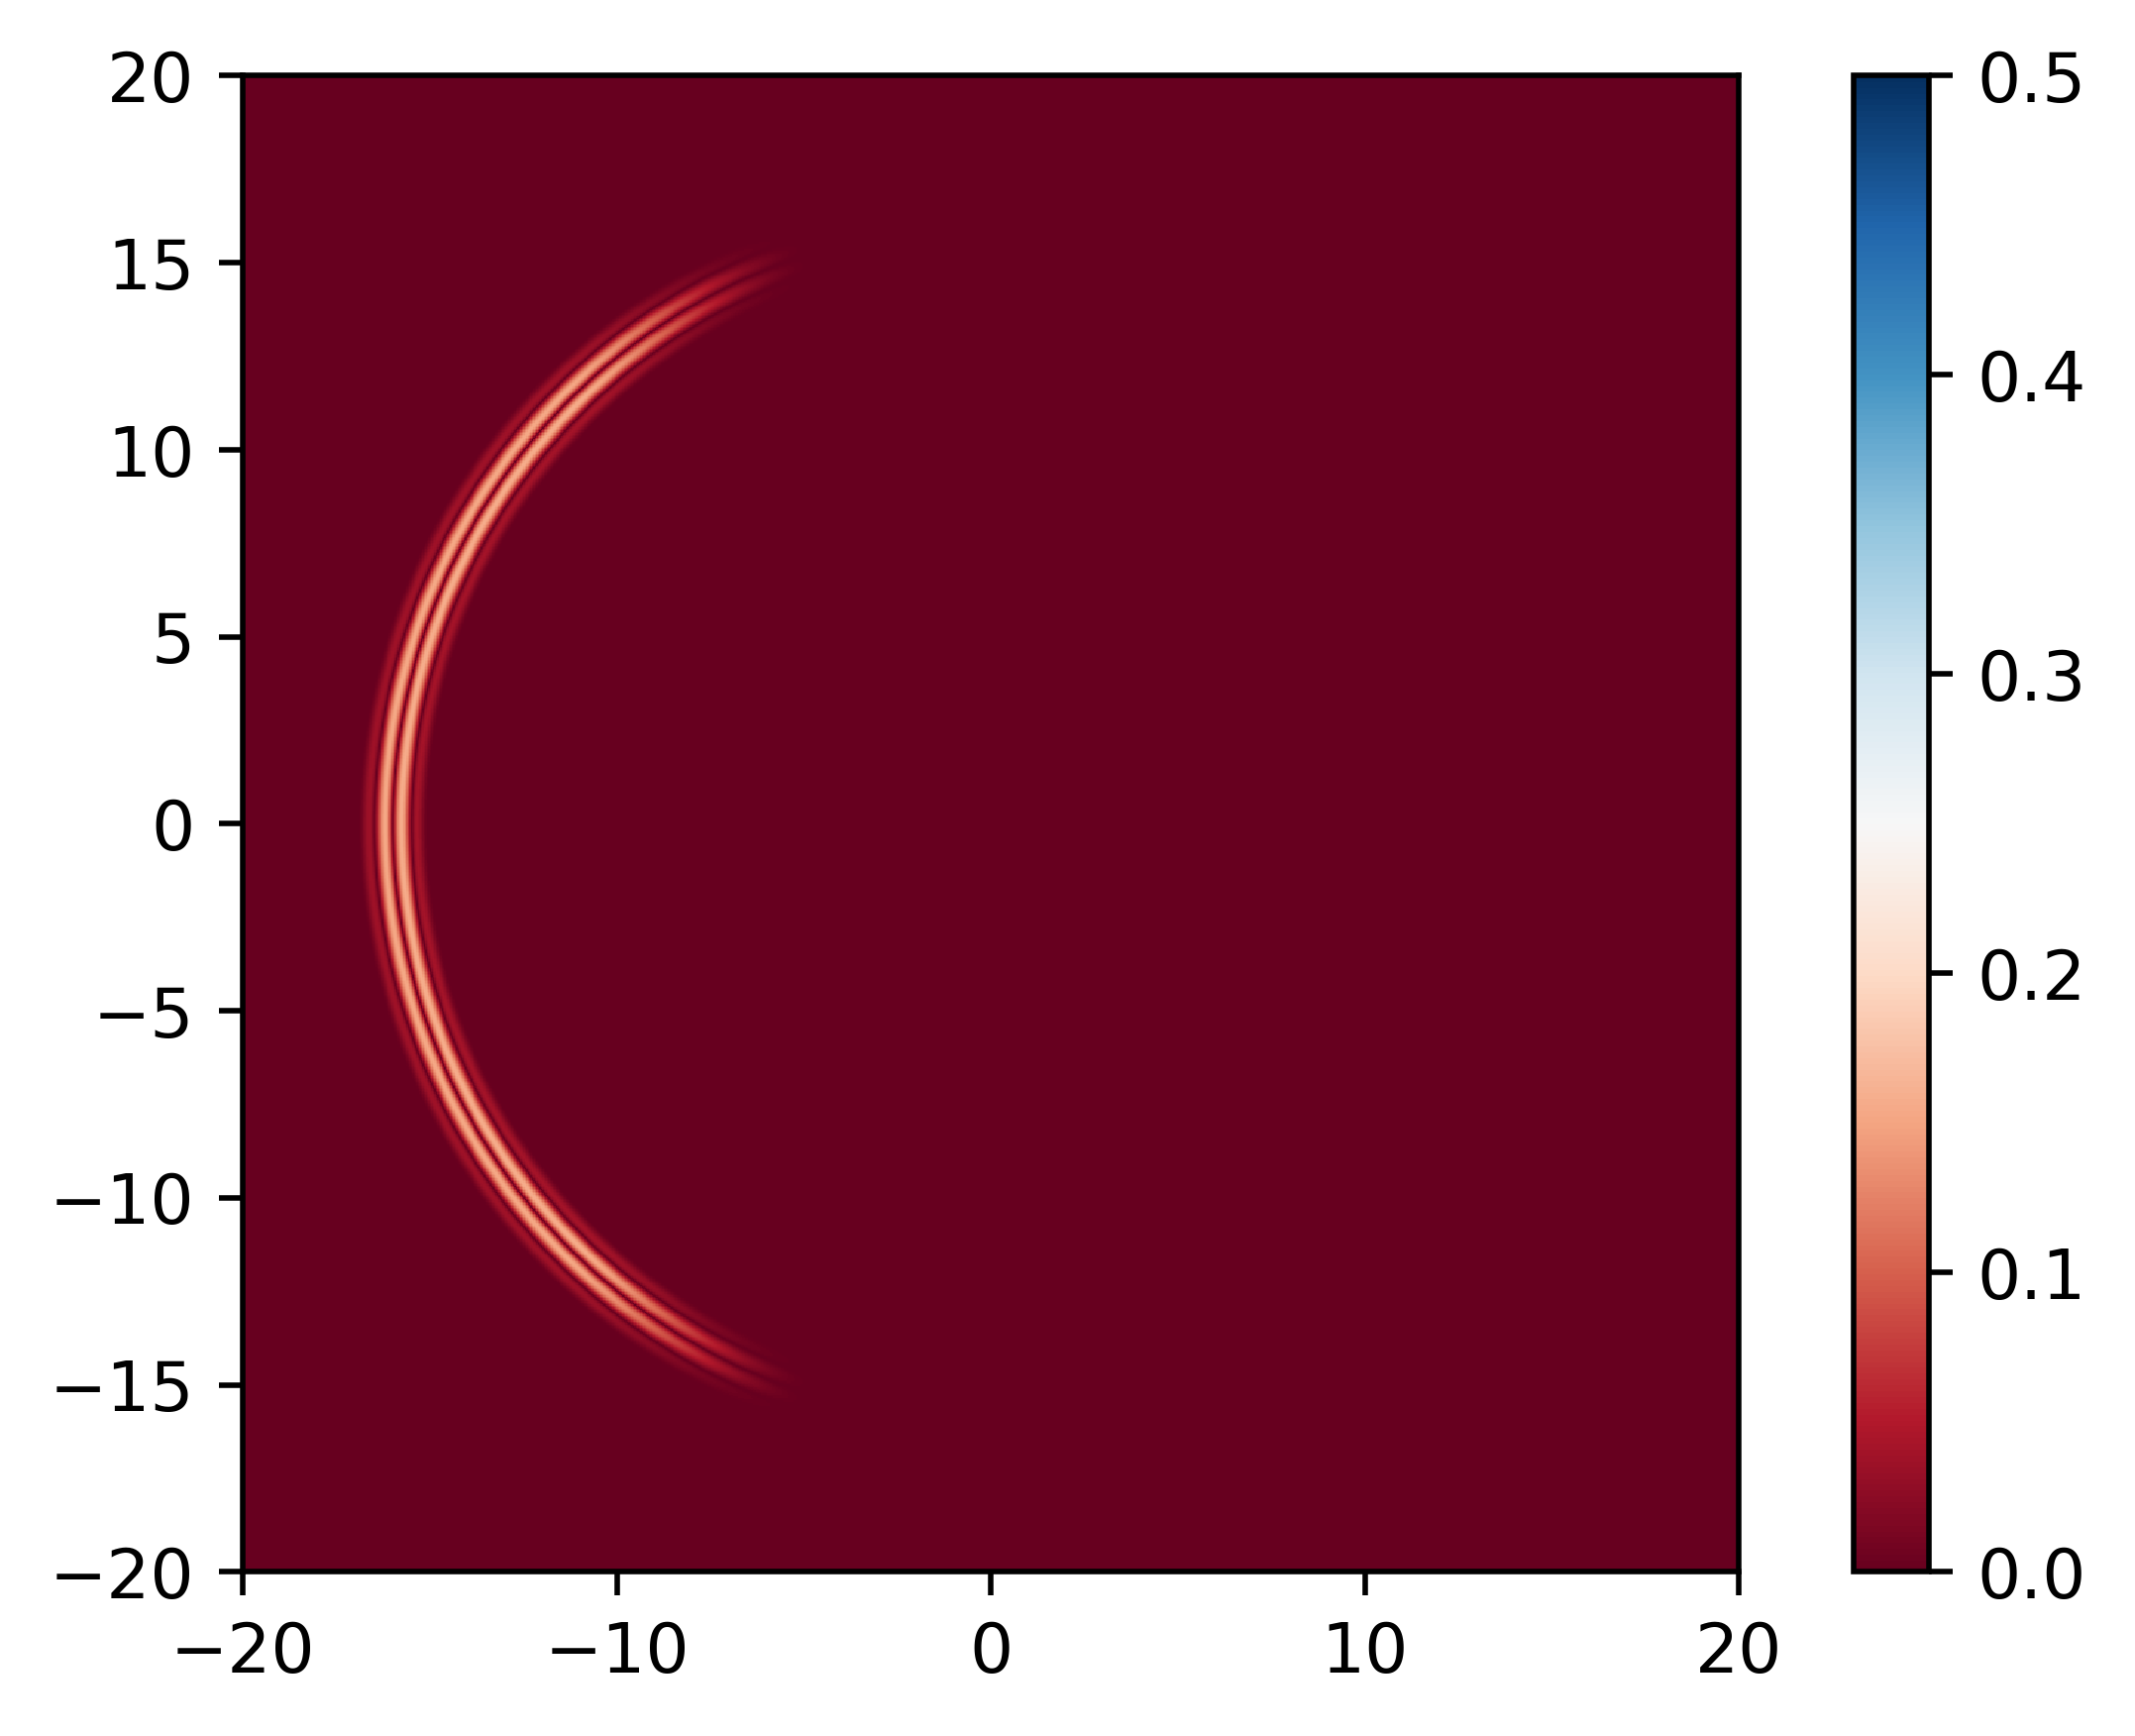

In [16]:
plot_im(np.abs(u_values))

# Creation of a computational grid and its initialization

A computational grid is required to perform a tight focusing simulation. The hi-chi module contains several types of computational grid for each field solver. To create a grid you need to specify the grid size, the spatial step of the grid, and the start coordinates of a computational area.

In [17]:
N = 256
gridSize = hichi.vector3d(N, N, N)
minCoords = hichi.vector3d(a, a, a)
maxCoords = hichi.vector3d(b, b, b)
gridStep = (maxCoords - minCoords) / gridSize

Also, the computational grid includes the time step with which the simulation will be performed. It is necessary for some kinds of field solvers that require a half-step time shift of the magnetic field relative to the electric field.

In [18]:
timeStep = R0*0.5/hichi.c

The next code calls the PSATDGrid class constructor and thereby creates the grid instance for the PSATD field solver.

In [19]:
grid = hichi.PSATDGrid(gridSize, timeStep, minCoords, gridStep)

## Simple initialisation

The easiest way to initialize the grid is by using a Python function. The next function sets up the electomagnetic field for a point with coordinates (x, y, z).

In [20]:
polarisation = hichi.vector3d(0.0, 1.0, 0.0)

def getEMFieldPythonFunc(x, y, z):
    r = hichi.vector3d(x, y, z)
    s1 = hichi.cross(polarisation, r)
    s0 = hichi.cross(r, s1)
    s0.normalize()
    s1.normalize()
    value = mask(x, y, z)
    E = value*s0
    B = value*s1
    return hichi.field(E, B)

However, the grid initialisation takes a long time due to Python-C++ interaction costs. So the grid of size 256 $\times$ 256 $\times$ 256 is initialized in about 20 minites.

In [21]:
start_time = time.process_time()     # the time before performing initialization

grid.set(getEMFieldPythonFunc)       # grid initialisation

final_time = time.process_time()     # the time after performing initialization

# display the time spent on initialization
print("Time is %0.2f sec" % (final_time - start_time))

Time is 1246.88 sec


We can get the field value for a point with coordinates (x, y, z) from the grid. If the point is not a grid node, linear interpolation is performed. The next function reads the field values from the grid and writes them to the numpy array. The output array size and the grid size can be different.

In [22]:
def getENorm(grid, shape, minCoords, maxCoords):
    
    # 'shape' is the size of the output array 'field'
    field = np.zeros(shape=(shape[1], shape[0]))
    step = ((maxCoords.x - minCoords.x)/shape[0], \
            (maxCoords.y - minCoords.y)/shape[1])
    
    for i in range(shape[0]):
        for j in range(shape[1]):
            
            # computing the x, y coordinates by index (i, j)
            x = minCoords.x + i*step[0]
            y = minCoords.y + j*step[1]
            coord = hichi.vector3d(x, y, 0.0)  # z=0
            
            # getting the norm of electric field at the point (x, y, z)
            field[shape[1]-j-1, i] = grid.getE(coord).norm()
            
    return field

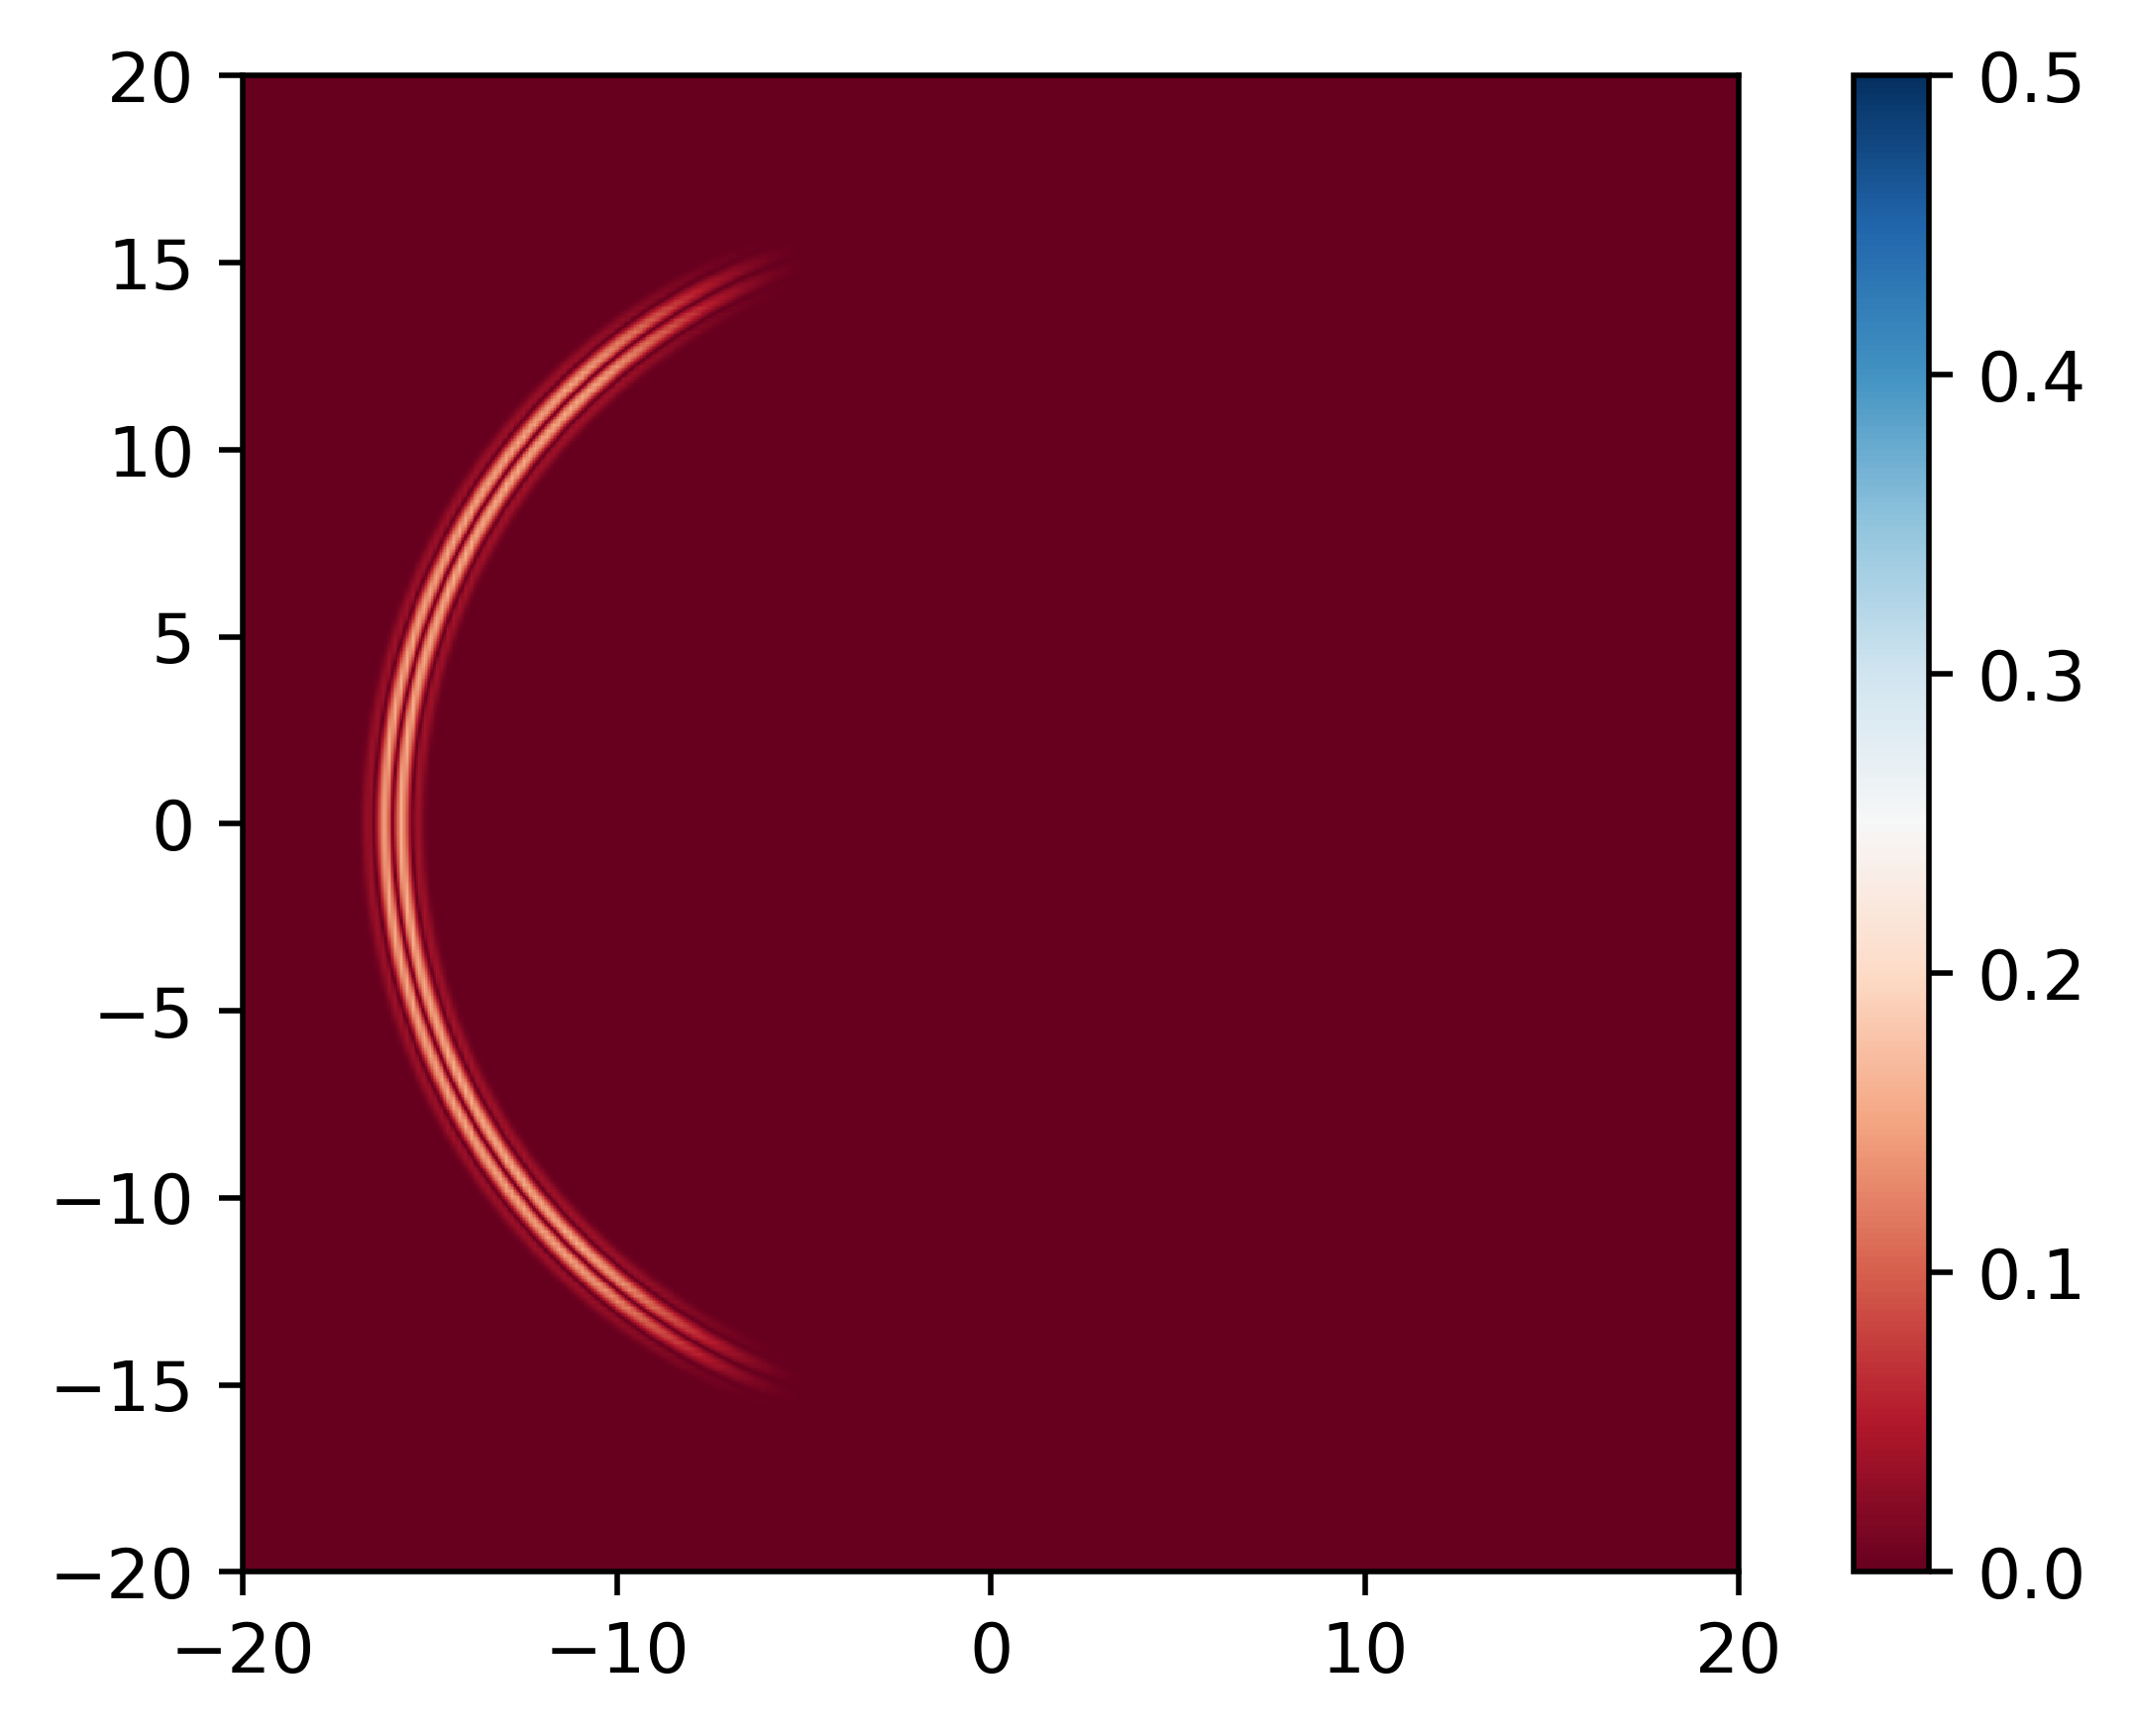

In [23]:
plot_im(getENorm(grid, (4*N, 4*N), minCoords, maxCoords))

## Fast initialisation

As stated above, a long time is taken to Python-C++ interactions. One way to speed up the process is to avoid them by porting a function to the C++ level, that can be performed using *numba*. *Numba* is an open source JIT compiler that translates Python functions to optimized machine code at runtime. In addition, it can create a compiled function called from C code. *Numba* has a number of drawbacks, the main one being the inability to use external libraries, except for *numpy*. Nevertheless, compilation can significantly speed up the execution of the function.

In [24]:
from numba import cfunc, float64, jit, njit, jitclass, types, carray

The Numba limitation on the ability to use external modules prevents the use of the hi-chi *vector3d* class. Instead, a similar custom-designed class *vector3d* from the *hichi_primitives* module can be used. All helper functions that will be used for initialization must also be compiled. To mark a function for optimization by Numba’s compiler it is enough to set *@jit* or *@njit* decorator above the function.

In [25]:
@njit
def getPolarisation():
    return hp.vector3d(0.0, 1.0, 0.0)

The slightly modified auxulary functions below can also be compiled by Numba.

In [26]:
@njit
def longitudinalFieldVariation(x):
     return np.sin(2*hichi.pi*x/wavelength + phase) * \
            np.cos(hichi.pi*x/pulselength)**2 * \
            hp.block(x, -0.5*pulselength, 0.5*pulselength)
        
@njit
def transverseShape(angle):
    angle1 = openingAngle - edgeSmoothingAngle*0.5
    angle2 = openingAngle + edgeSmoothingAngle*0.5
    return hp.block(angle, -1.0, angle1) + \
           (np.cos(0.5*hichi.pi*(angle - angle1)/edgeSmoothingAngle)**2 * \
           hp.block(angle, angle1, angle2) if (not edgeSmoothingAngle == 0.0) \
           else 0.0)
               
@njit
def mask(x, y, z):
    R = np.sqrt(x*x + y*y + z*z)
    if(R > 1e-5):
        angle = np.arcsin(np.sqrt(y*y + z*z)/R)
        return (amp/R) * longitudinalFieldVariation(R - R0) * \
                                  transverseShape(angle)*(x < 0)
    else:
        return 0.0

To compile a function that can be called from C++ level, the *@cfunc* decorator can be used. This decorator is similar to *@jit* decorator, however, the function signature has to be passed obligatorily. The *getEMFieldNumbaFunc()* function takes 4 arguments. The first three arguments are the coordinates of the point, and the fourth one is a pointer to an array of 6 elements where the result will be written as a sequence of field values $E_x$, $E_y$, $E_z$, $B_x$, $B_y$, $B_z$.

In [27]:
@cfunc("void(float64,float64,float64,types.CPointer(float64))", nopython=True)
def getEMFieldNumbaFunc(x, y, z, field_arr_):
    r = hp.vector3d(x, y, z)
    s1 = hp.cross(getPolarisation(), r)
    s1.normalize()
    s0 = hp.cross(r, s1)
    s0.normalize()
    m = mask(x, y, z)
    field_arr = carray(field_arr_, (6))         
    field_arr[0] = m*s0.x  # Ex
    field_arr[1] = m*s0.y  # Ey
    field_arr[2] = m*s0.z  # Ez              
    field_arr[3] = m*s1.x  # Bx
    field_arr[4] = m*s1.y  # By
    field_arr[5] = m*s1.z  # Bz

The hi-chi module has a possibility to take a pointer to the compiled Python function.

In [28]:
start_time = time.process_time()

# the '.address' property is a pointer to a compiled function
grid.set(getEMFieldNumbaFunc.address)

final_time = time.process_time()
numba_func_init_time = final_time - start_time
print("Time is %0.2f sec" % (numba_func_init_time))

Time is 16.48 sec


We can see that the grid is initialized about 80 times faster. The image below confirms that everything is working correctly.

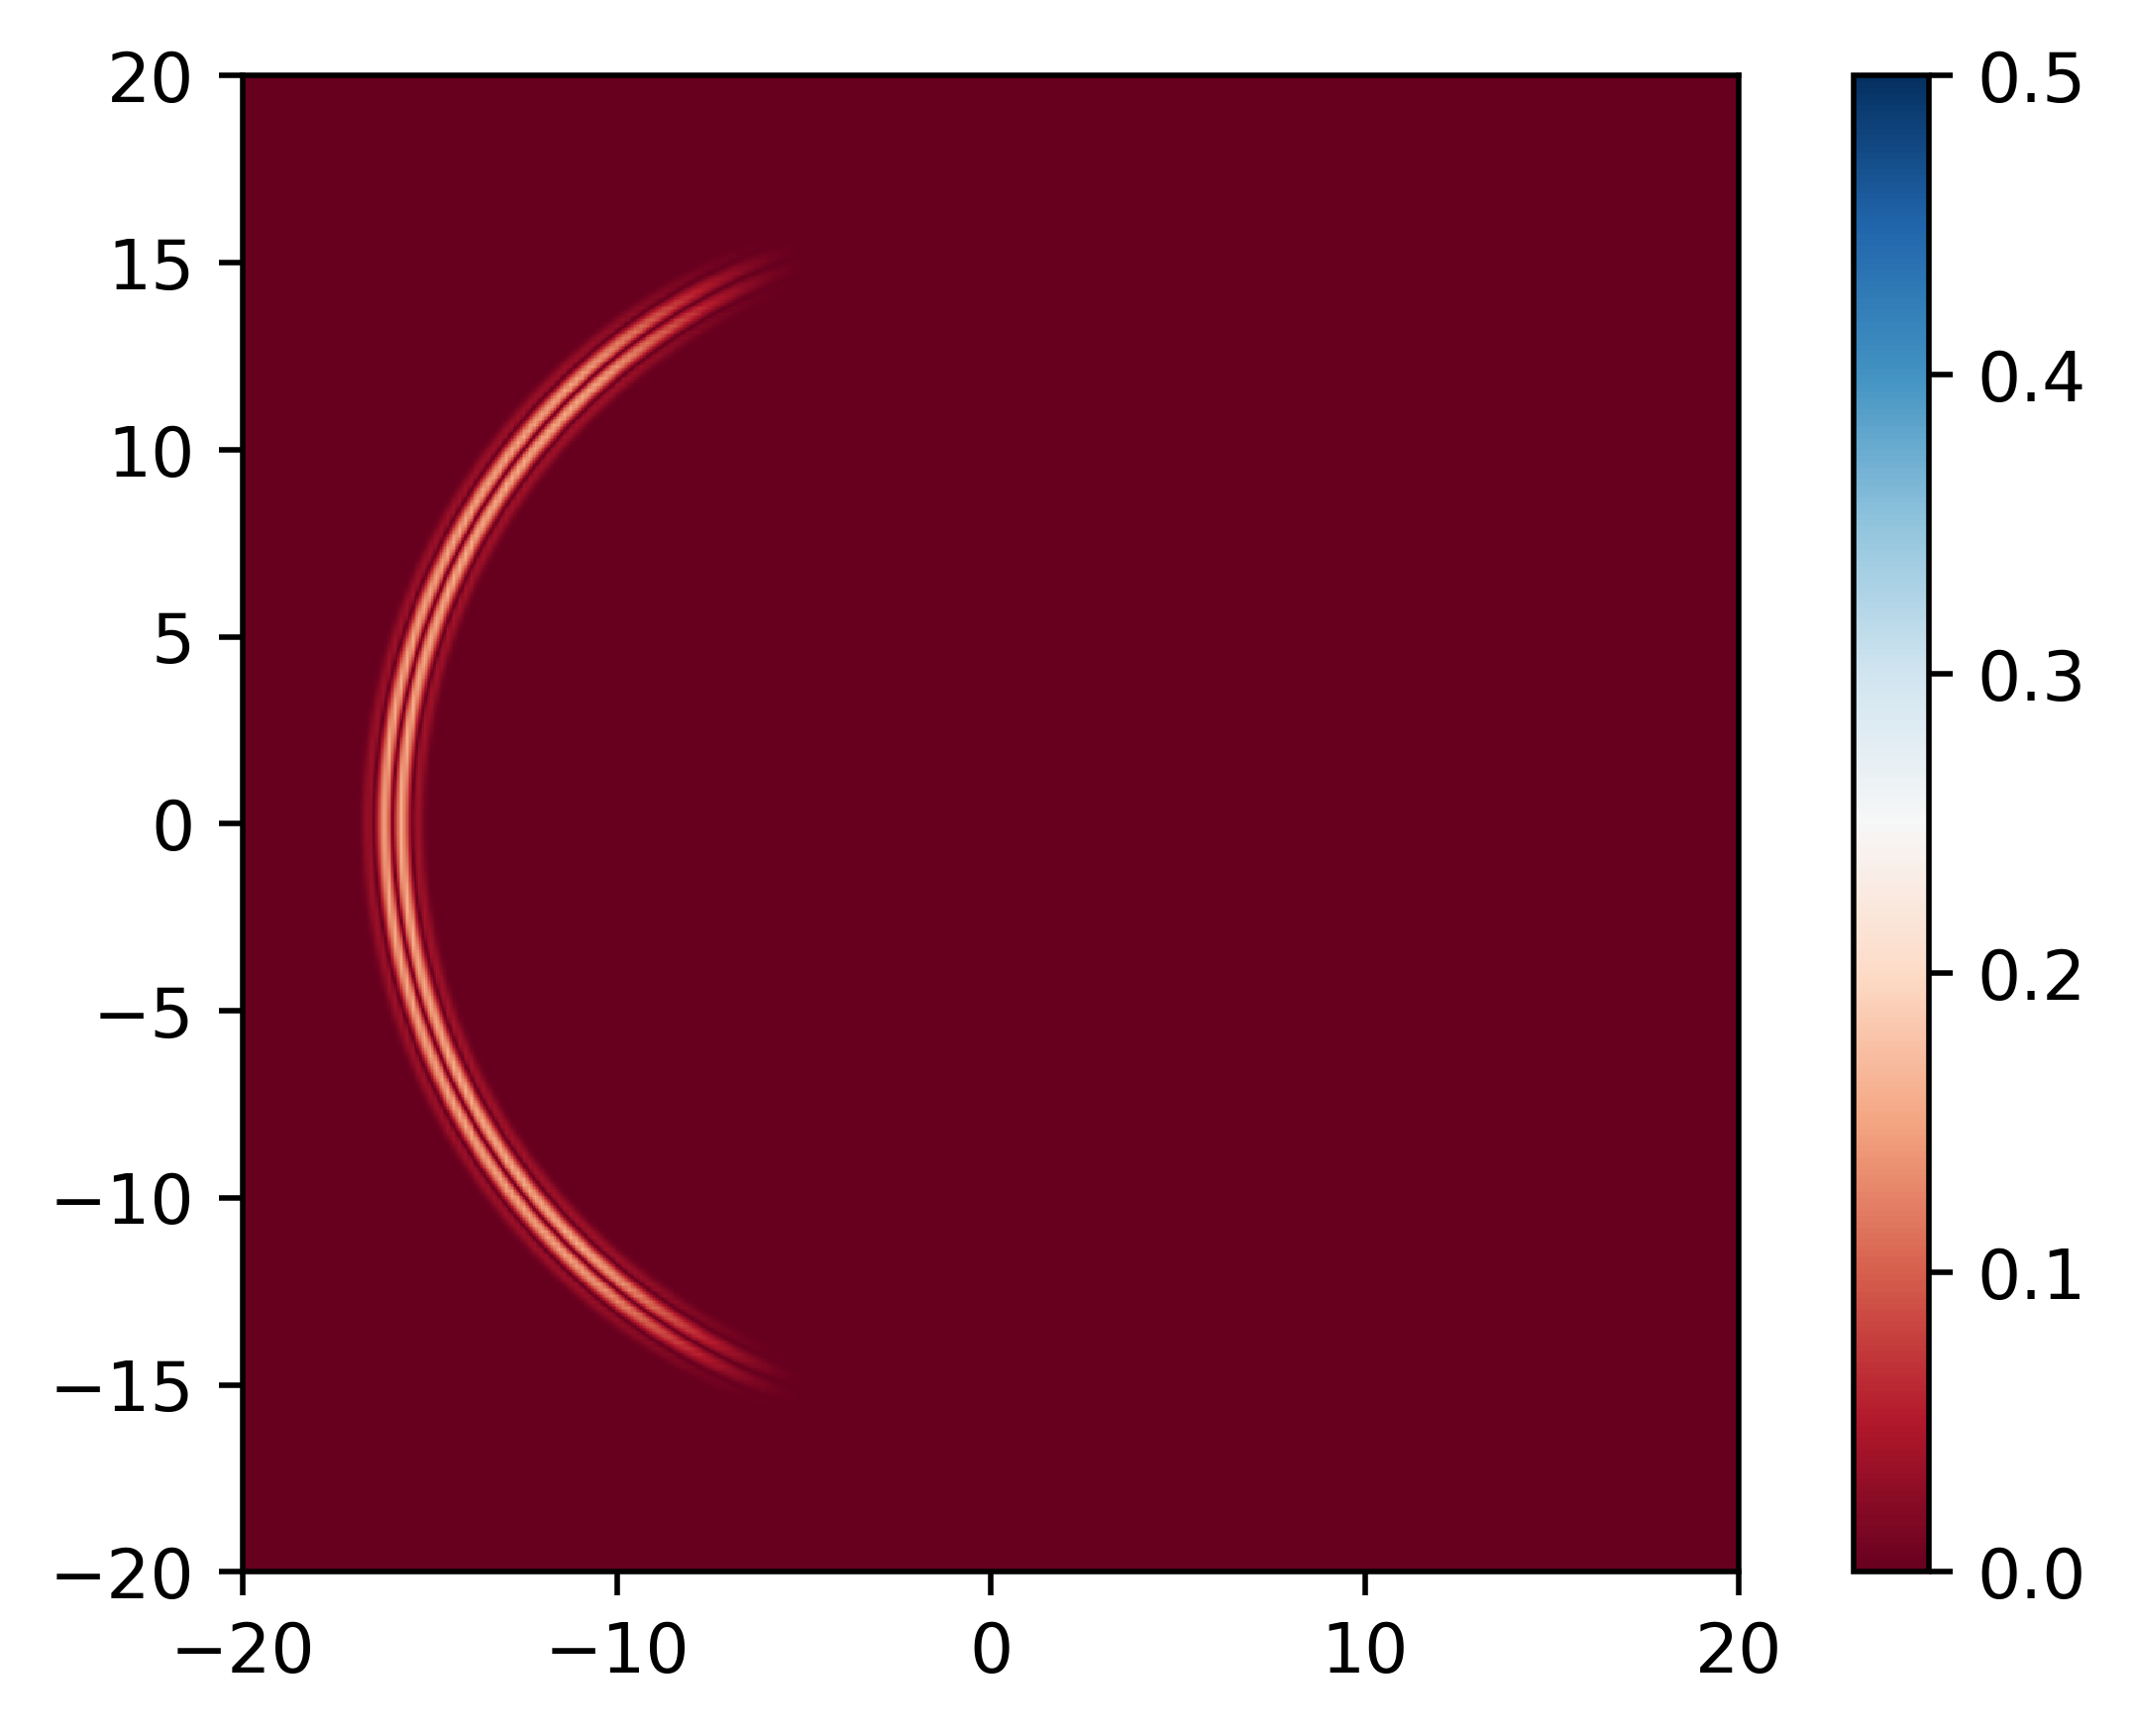

In [29]:
plot_im(getENorm(grid, (4*N, 4*N), minCoords, maxCoords))

## Very fast initialisation

Obviously, the fastest way to initialize a computational grid is to use optimized multithreaded native C++ code. The hi-chi module provides such option for a given field configuration. However, it leads to loss of flexibility on the Python level.  

In [30]:
tightFocusingConf = hichi.TightFocusingField(f_number,
                                             R0,
                                             wavelength,
                                             pulselength,
                                             phase,
                                             totalPower,
                                             edgeSmoothingAngle) 

As we can see, C++ code runs an order of magnitude faster in one thread.

In [31]:
start_time = time.process_time()

grid.set(tightFocusingConf)

final_time = time.process_time()
c_init_time = final_time - start_time
print("Time is %0.2f sec" % (c_init_time))

Time is 1.48 sec


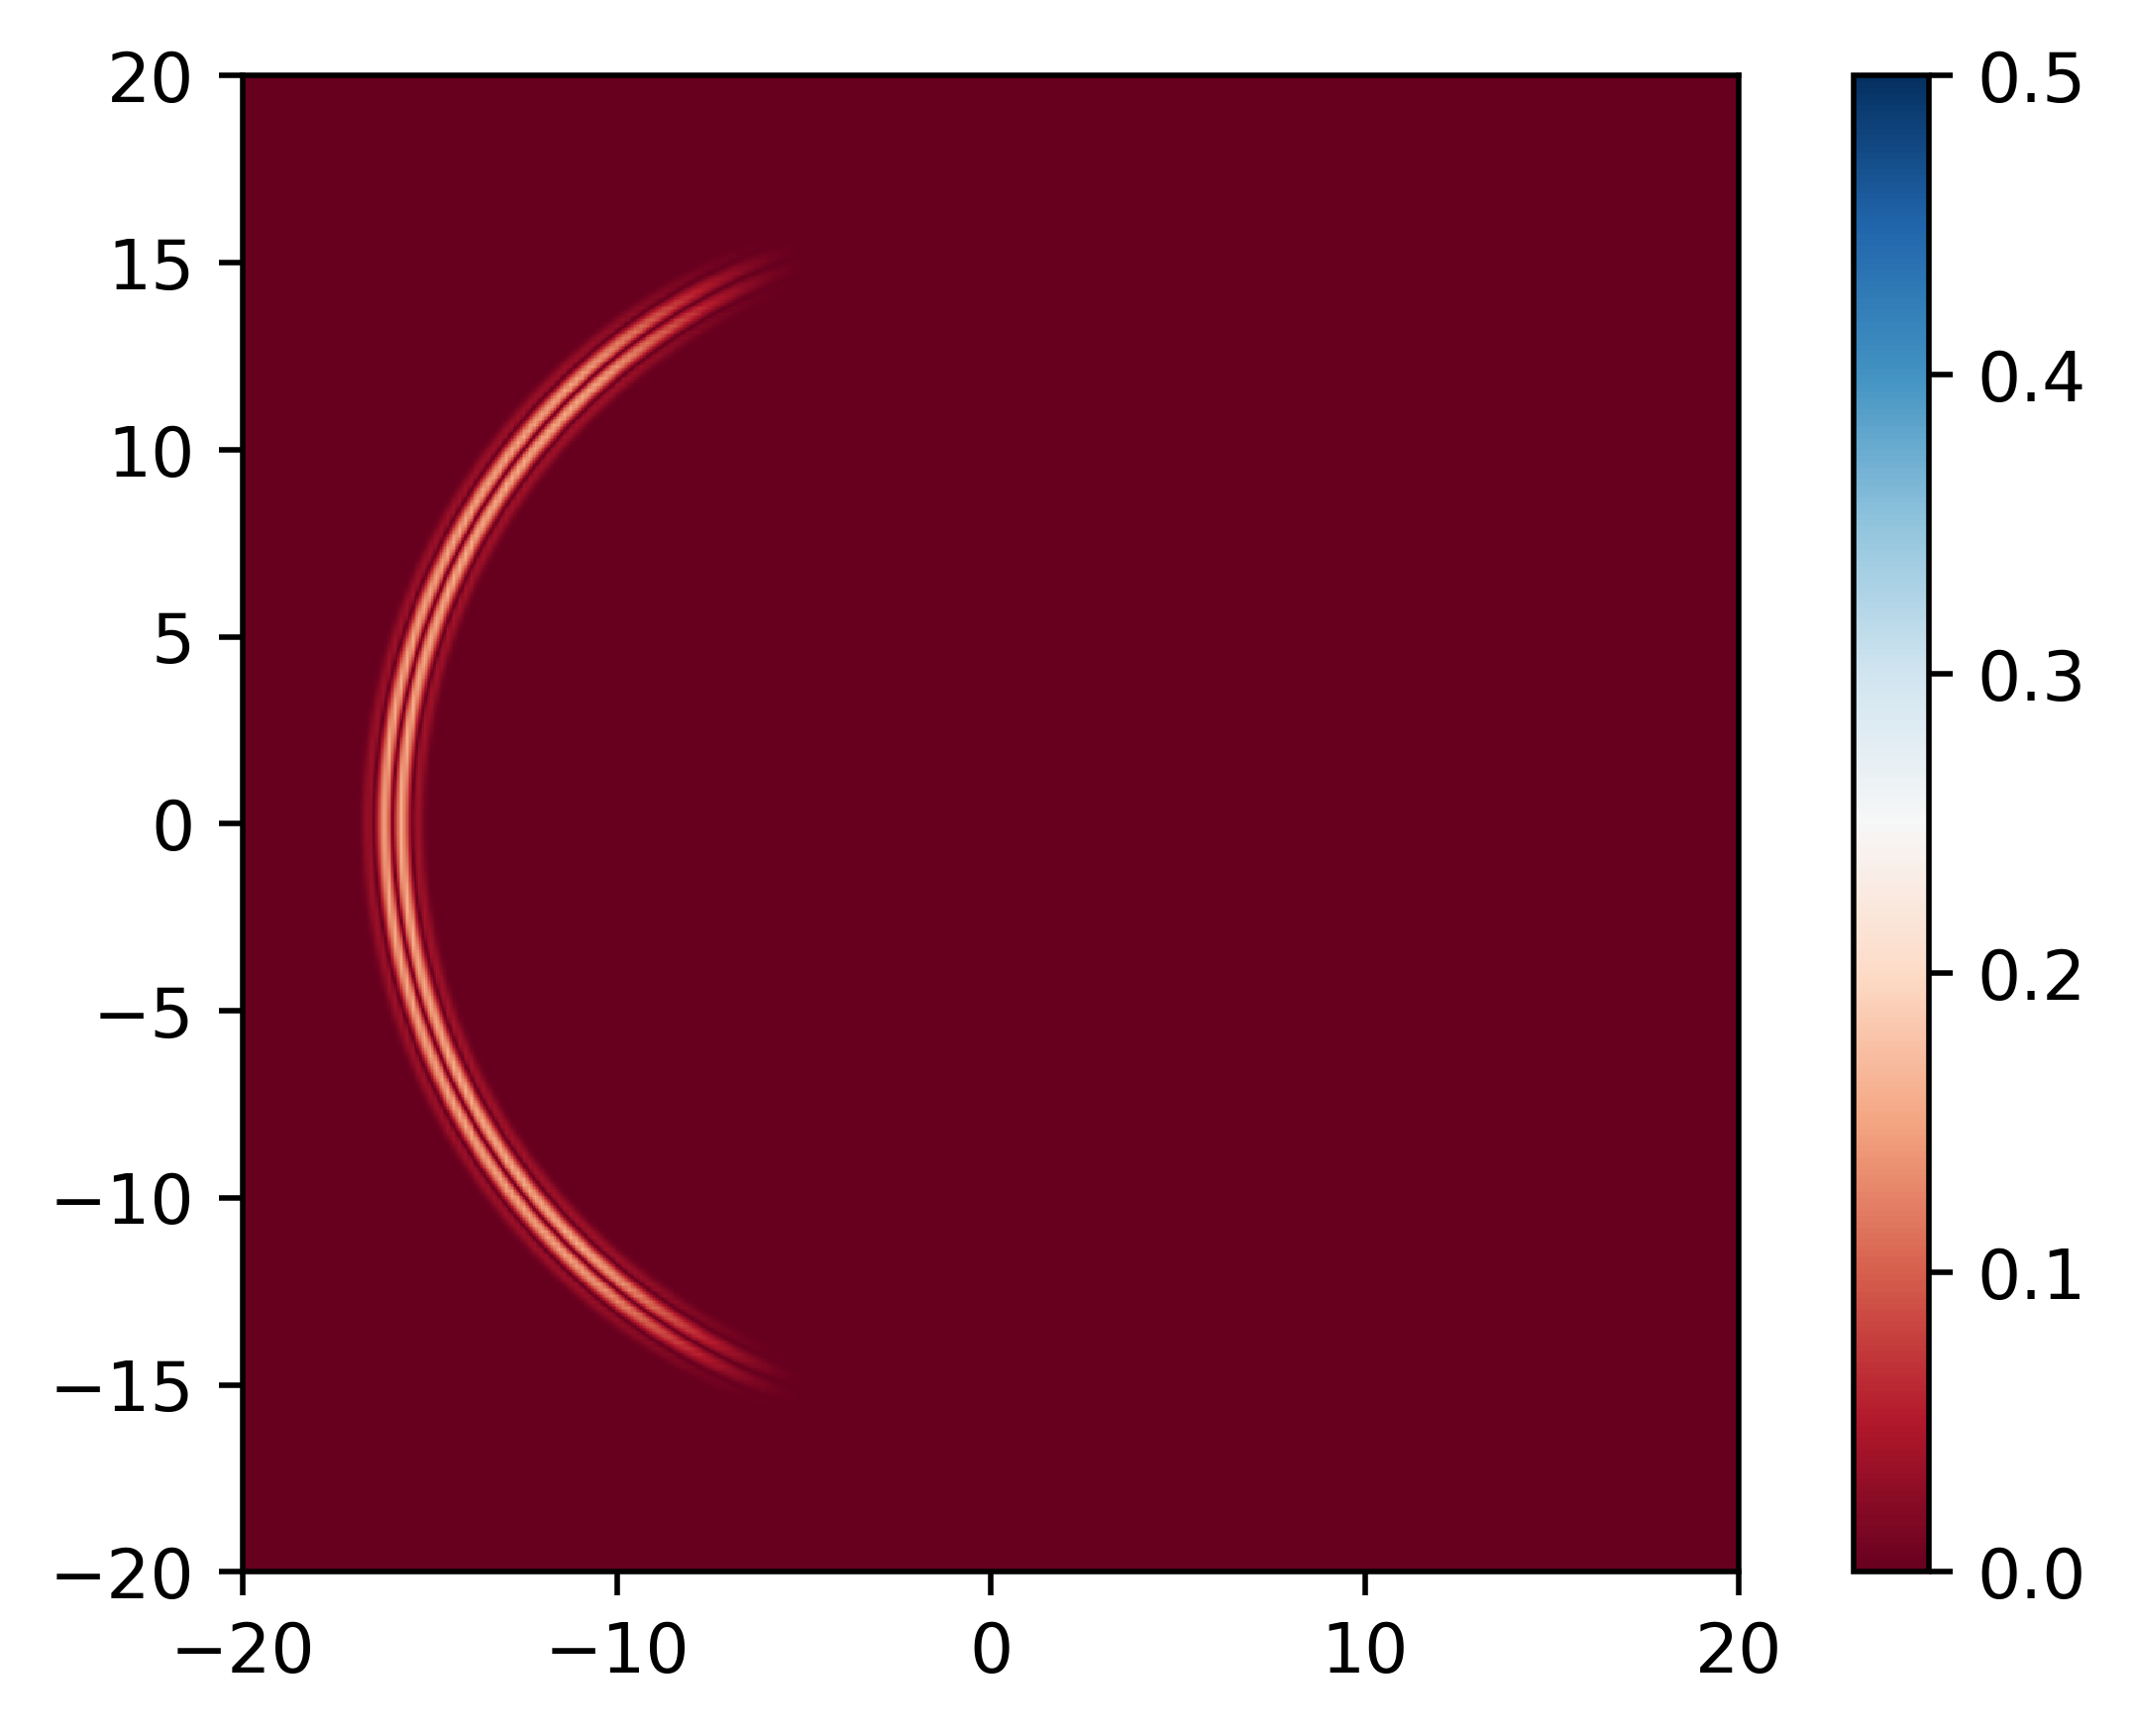

In [32]:
plot_im(getENorm(grid, (4*N, 4*N), minCoords, maxCoords))

# Start field solver

The next step is to run the simulation. To do this, just create an instance of the field solver class based on the created grid and call the *updateFields()* method. The spectral solver PSATD has no numerical dispersion and Courant condition, so we can perform simulation using a large time step.

In [33]:
fieldSolver = hichi.PSATD(grid)

In [34]:
start_time = time.process_time()

fieldSolver.updateFields()

final_time = time.process_time()
field_solver_time = final_time - start_time
print("Time is %0.2f sec" % (field_solver_time))

Time is 7.03 sec


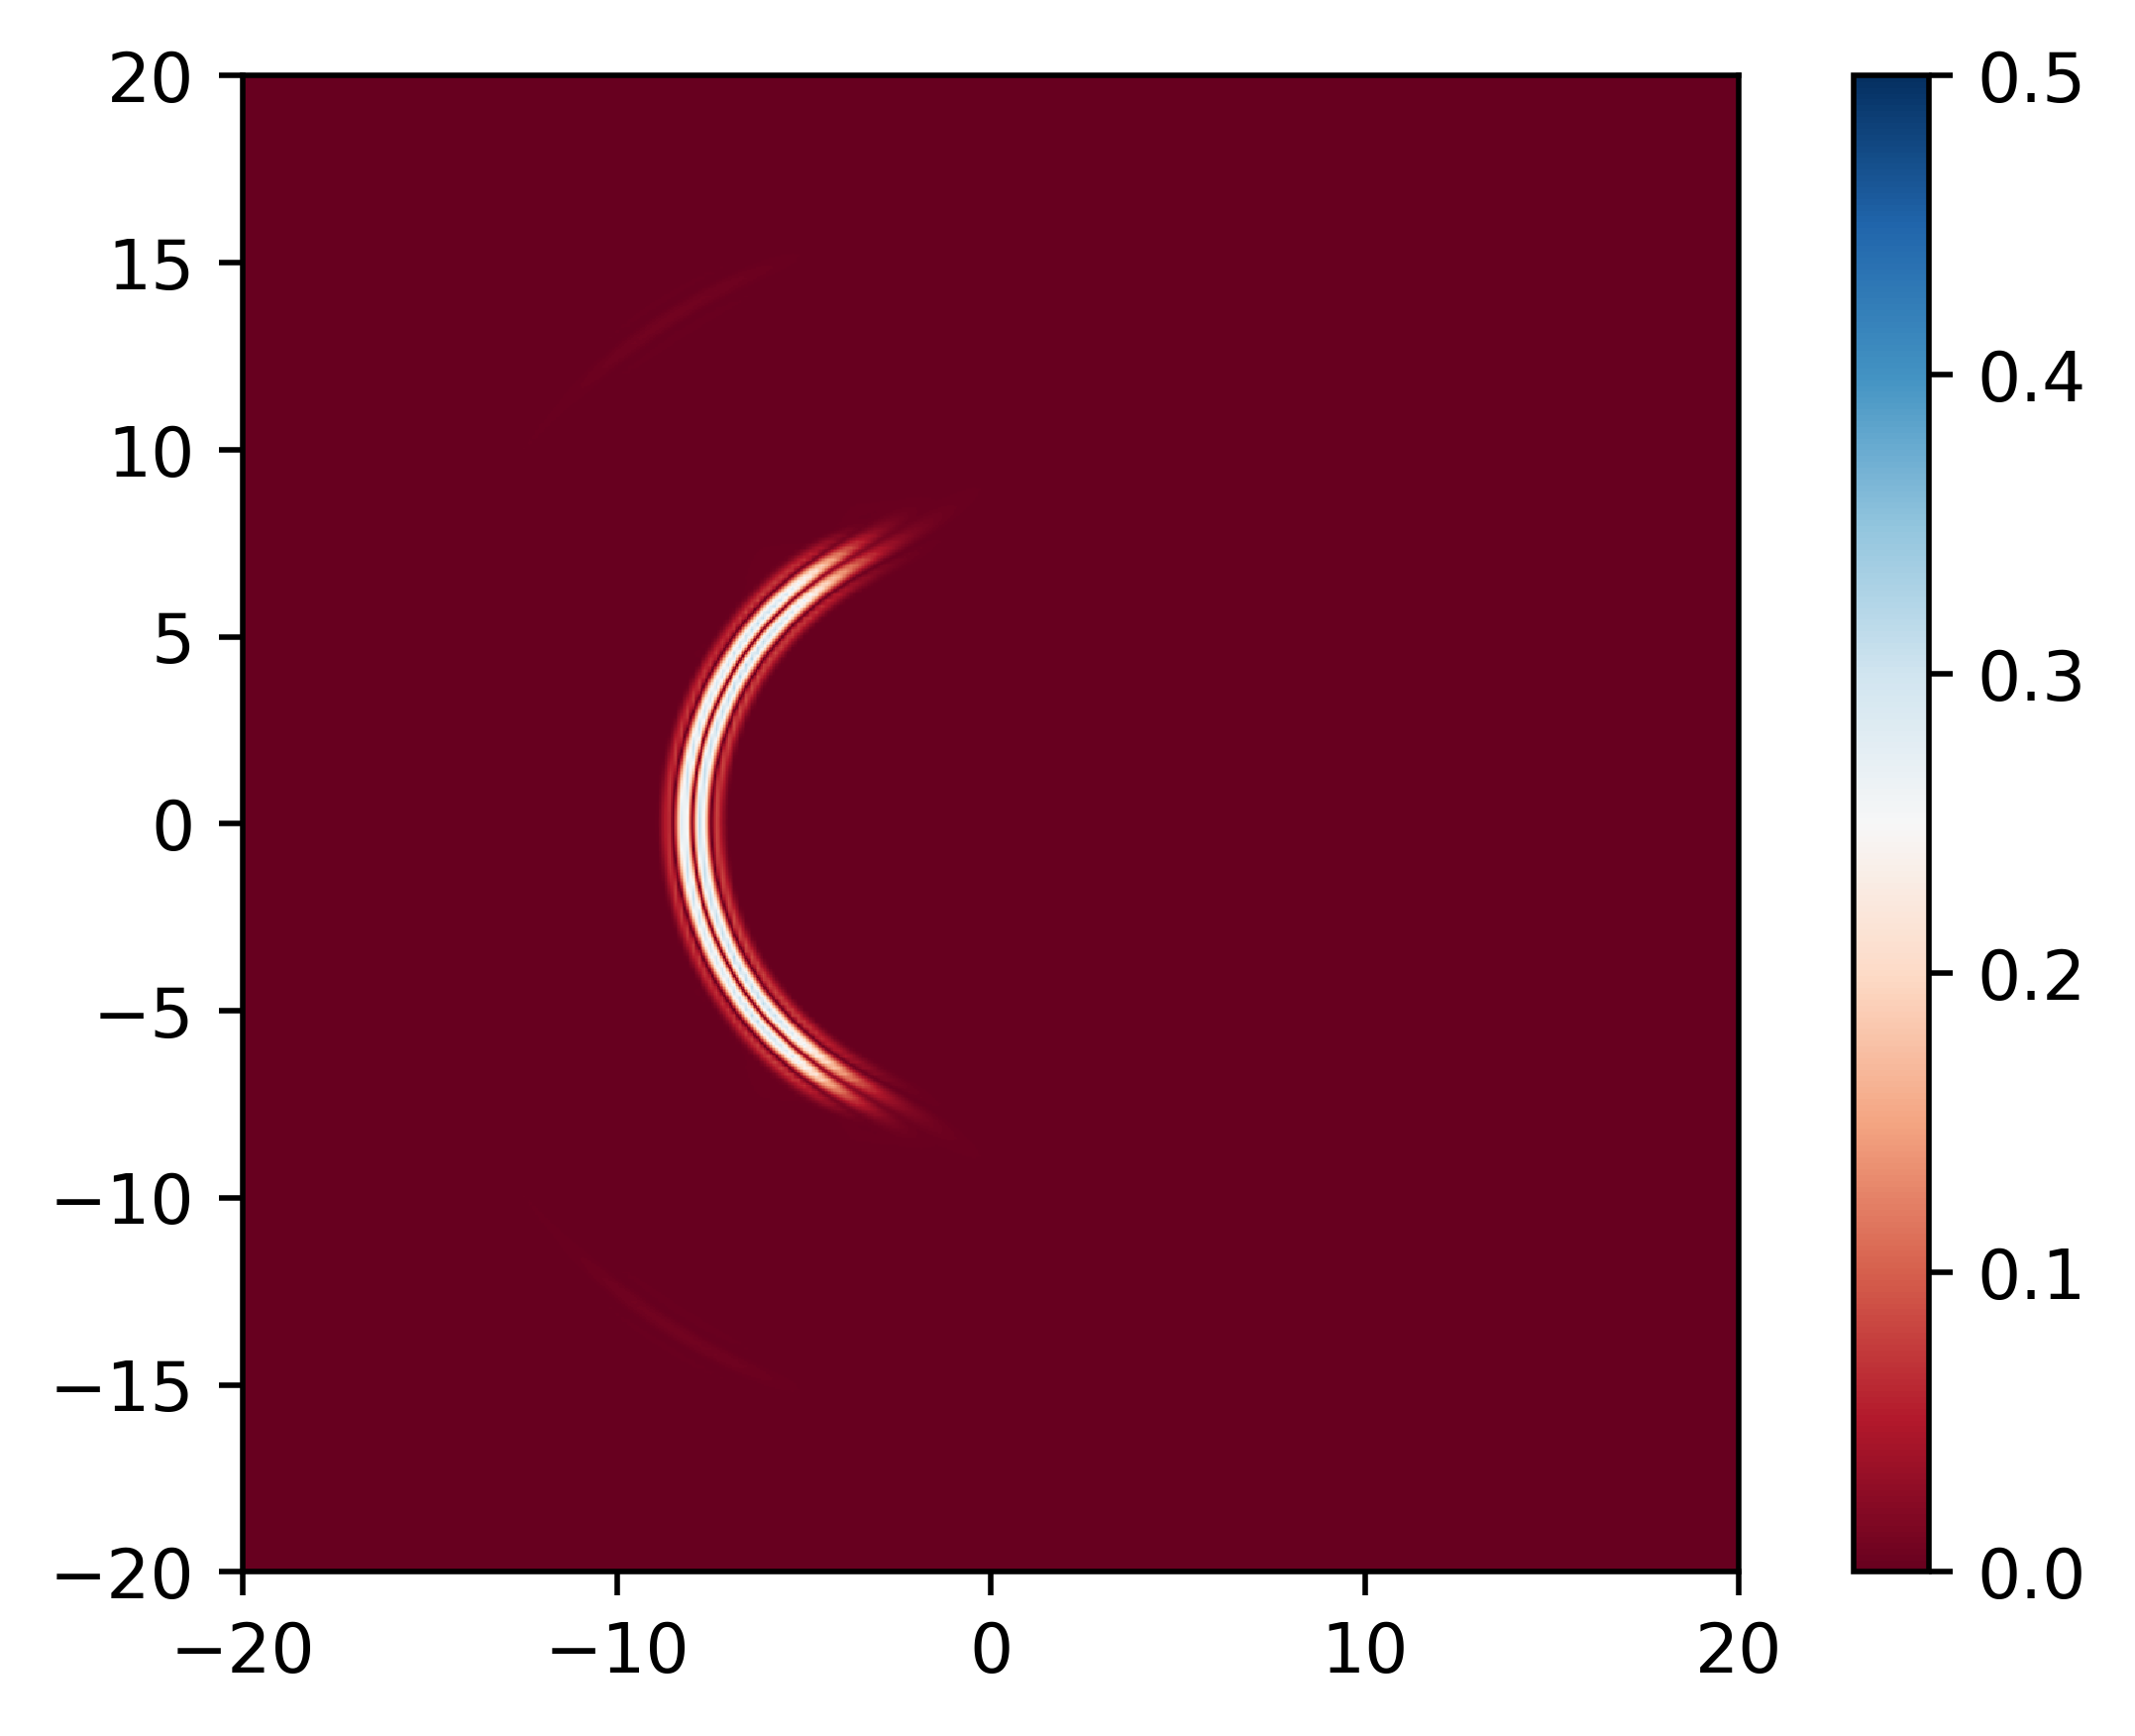

In [35]:
plot_im(getENorm(grid, (4*N, 4*N), minCoords, maxCoords))

In the picture above, to the left of the pulse, we can see static fields, the appearance of which is due to the failure to satisfy the Poisson equation for the initial conditions. The code below performs the approciate adjustment.

In [36]:
start_time = time.process_time()

fieldSolver.convertFieldsPoissonEquation()

final_time = time.process_time()
print("Time is %0.2f sec" % (final_time - start_time))

Time is 4.34 sec


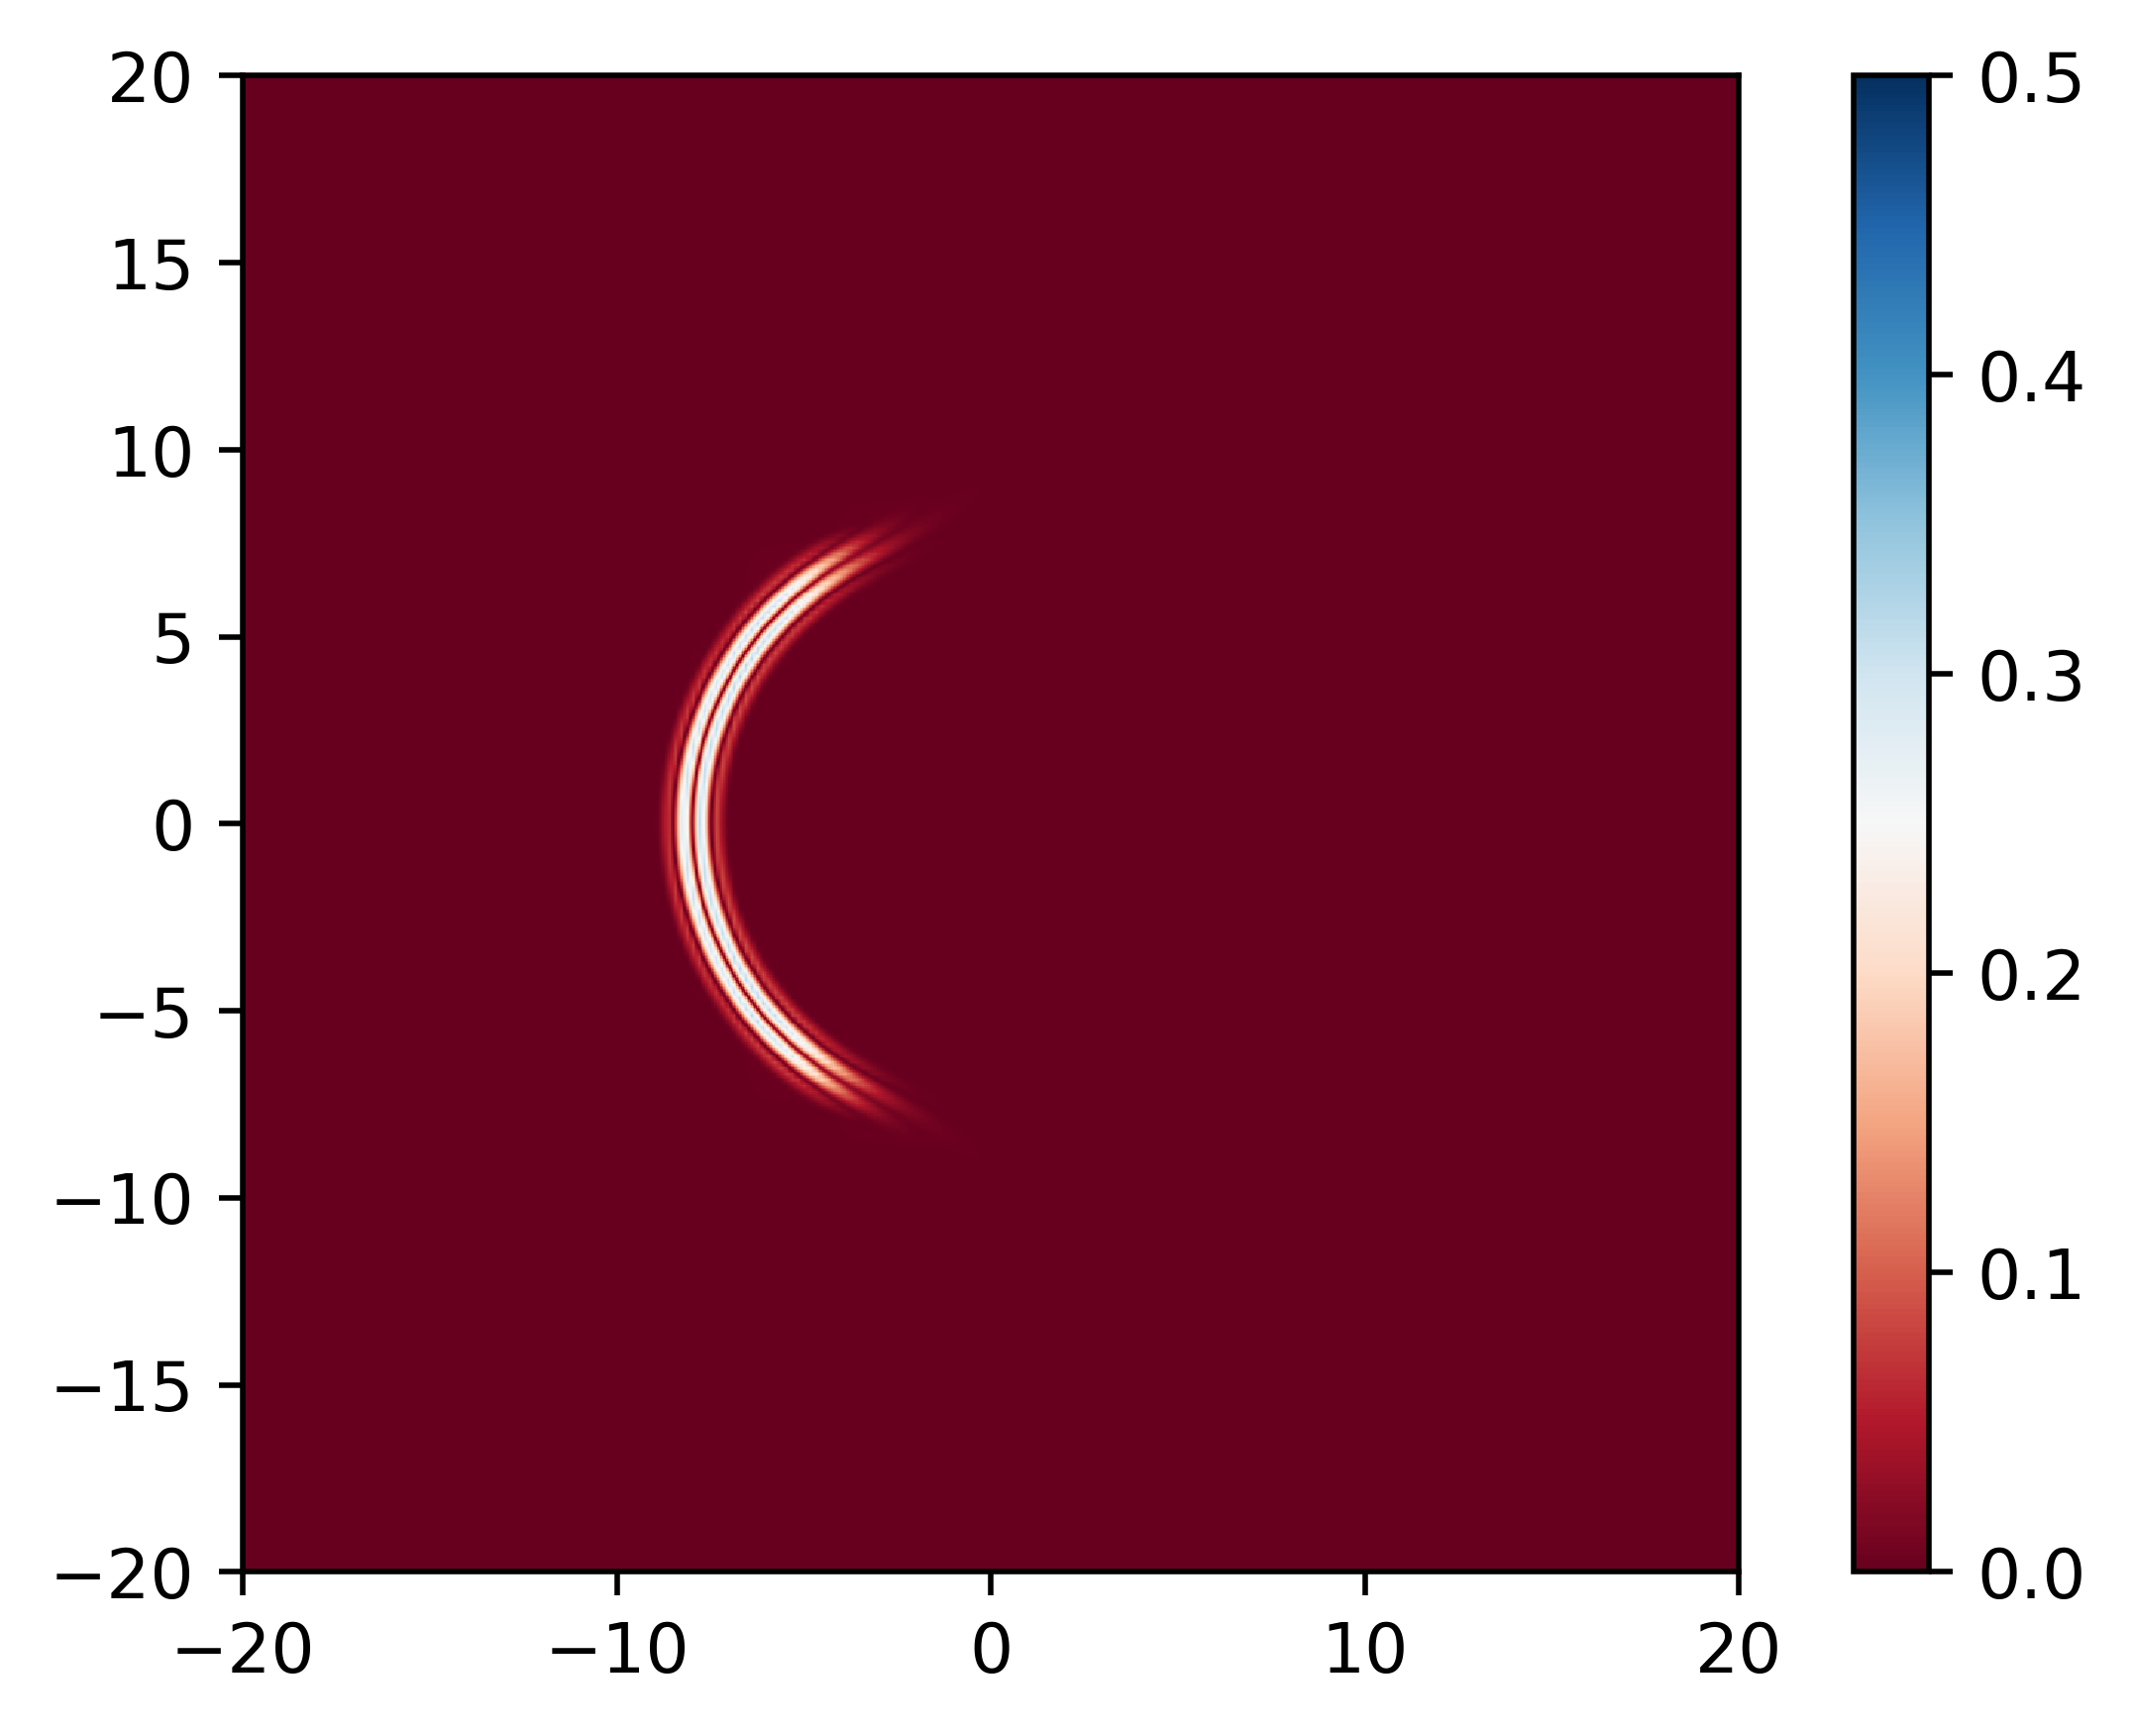

In [37]:
plot_im(getENorm(grid, (4*N, 4*N), minCoords, maxCoords))

The large opening angle allows us to assume that the peak intensity is reached at time $R_0/c$ from the beginning of the calculation. The next code computes the peak value of the electric field.

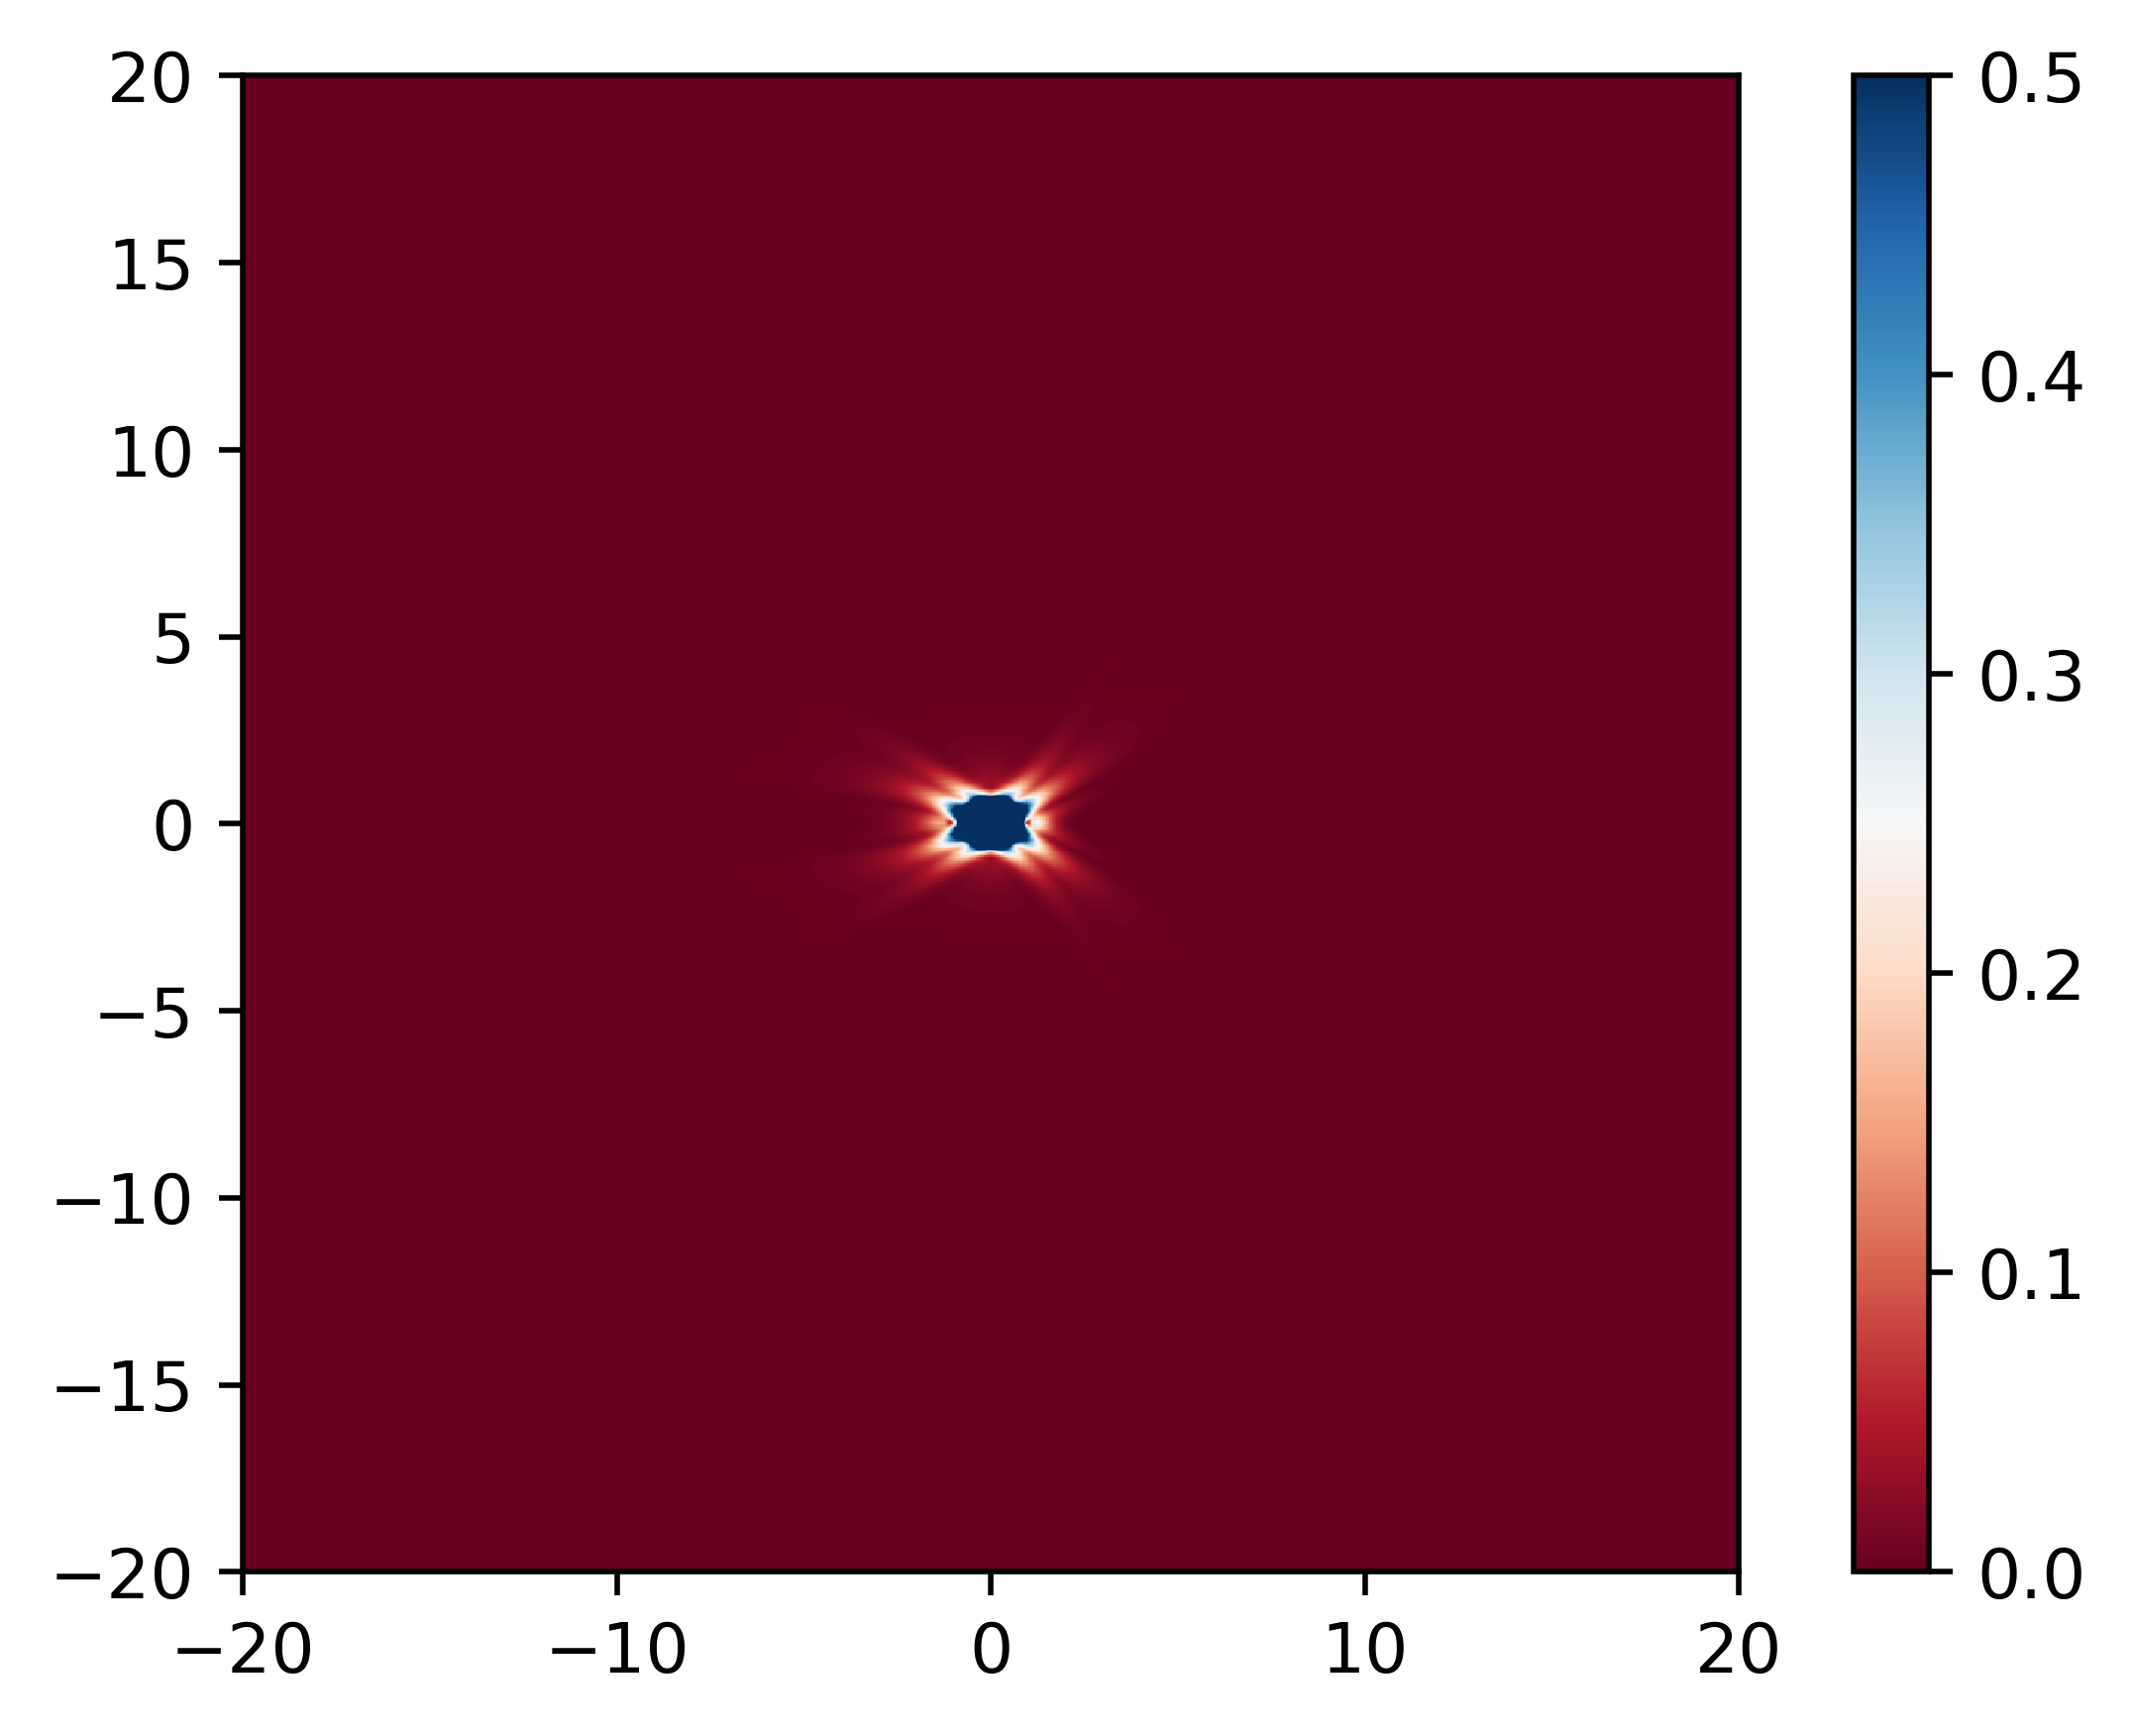

Peak intensity is 7.755909


In [38]:
fieldSolver.updateFields()
field = getENorm(grid, (4*N, 4*N), minCoords, maxCoords)
plot_im(field)
peak_int = field.max()
print("Peak intensity is %f" % (peak_int))

# Mappings

The hi-chi module allows to use some mapping for the computational domain, such as a scale mapping, or a shift mapping, or a rotation mapping. Let's consider an electromagnetic pulse of the next configuration.

In [39]:
def fieldValue(x, y, z):
    return np.exp(-x**2-y**2-z**2)*np.sin(5*x)

In [40]:
def nullValue(x, y, z):  # the auxulary function
    return 0.0

The computational area will be limited by the next points.

In [41]:
minCoords = hichi.vector3d(-5, -5, -5)
maxCoords = hichi.vector3d(5, 5, 5)

The code below creates the computational grid and initializes it.

In [42]:
gridSize = hichi.vector3d(128, 128, 128)
gridStep = (maxCoords - minCoords) / gridSize
timeStep = 2.0/hichi.c
grid = hichi.PSATDGrid(gridSize, timeStep, minCoords, gridStep)

In [43]:
grid.setE(nullValue, fieldValue, nullValue)  # Ex, Ey, Ez
grid.setB(nullValue, nullValue, fieldValue)  # Bx, By, Bz

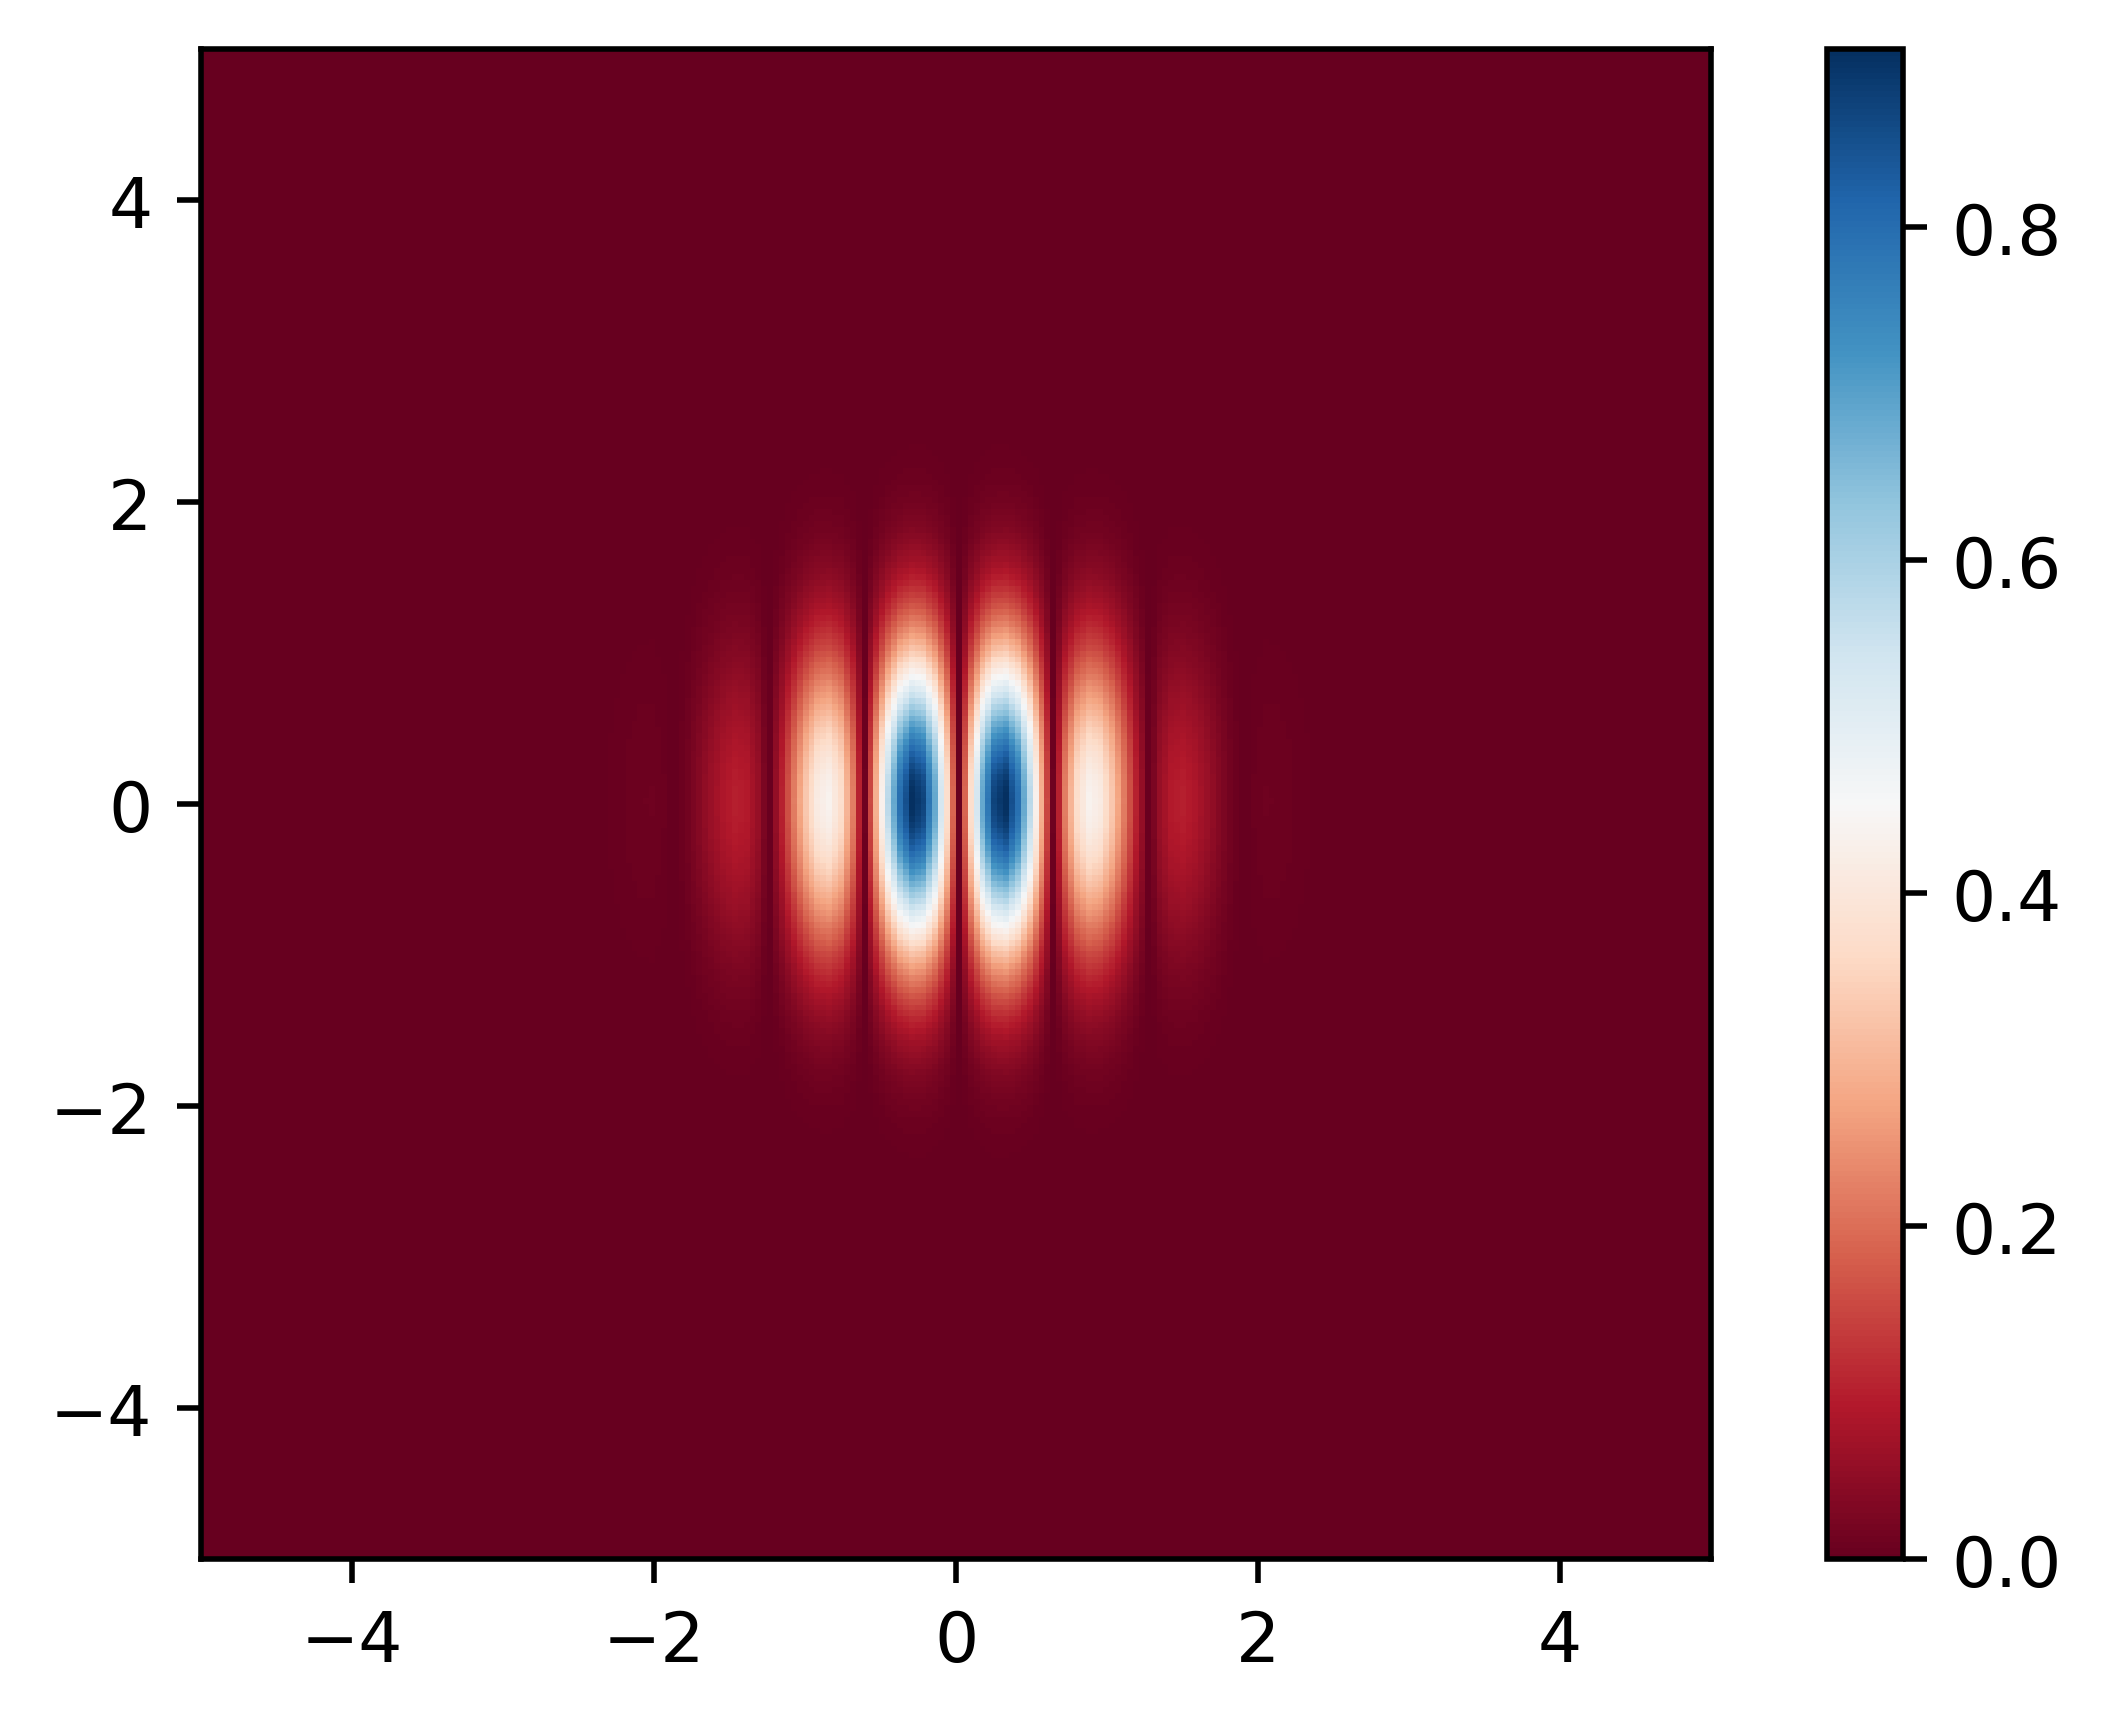

In [44]:
shape = (2*int(gridSize.x), 2*int(gridSize.y))
plot_im(getENorm(grid, shape, minCoords, maxCoords),
        vmin=None, vmax=None,
        a=(minCoords.x, minCoords.y),
        b=(maxCoords.x, maxCoords.y)
       )

Let's demonstrate the rotation transform as an example. The following mapping rotates $\pi/3$ rad around the z-axis.

In [45]:
angle = hichi.pi/3
rotationZMapping = hichi.RotationMapping(hichi.Axis.z, angle)

The following code creates a grid wrapper that allows one or more mappings to be set  and performed in sequence.

In [46]:
gridMapping = hichi.PSATDGridMapping(grid)  # shallow copy of grid
gridMapping.setMapping(rotationZMapping)

Now all the setted mappings will be performed automatically when the *get* and *set* grid methods are called..

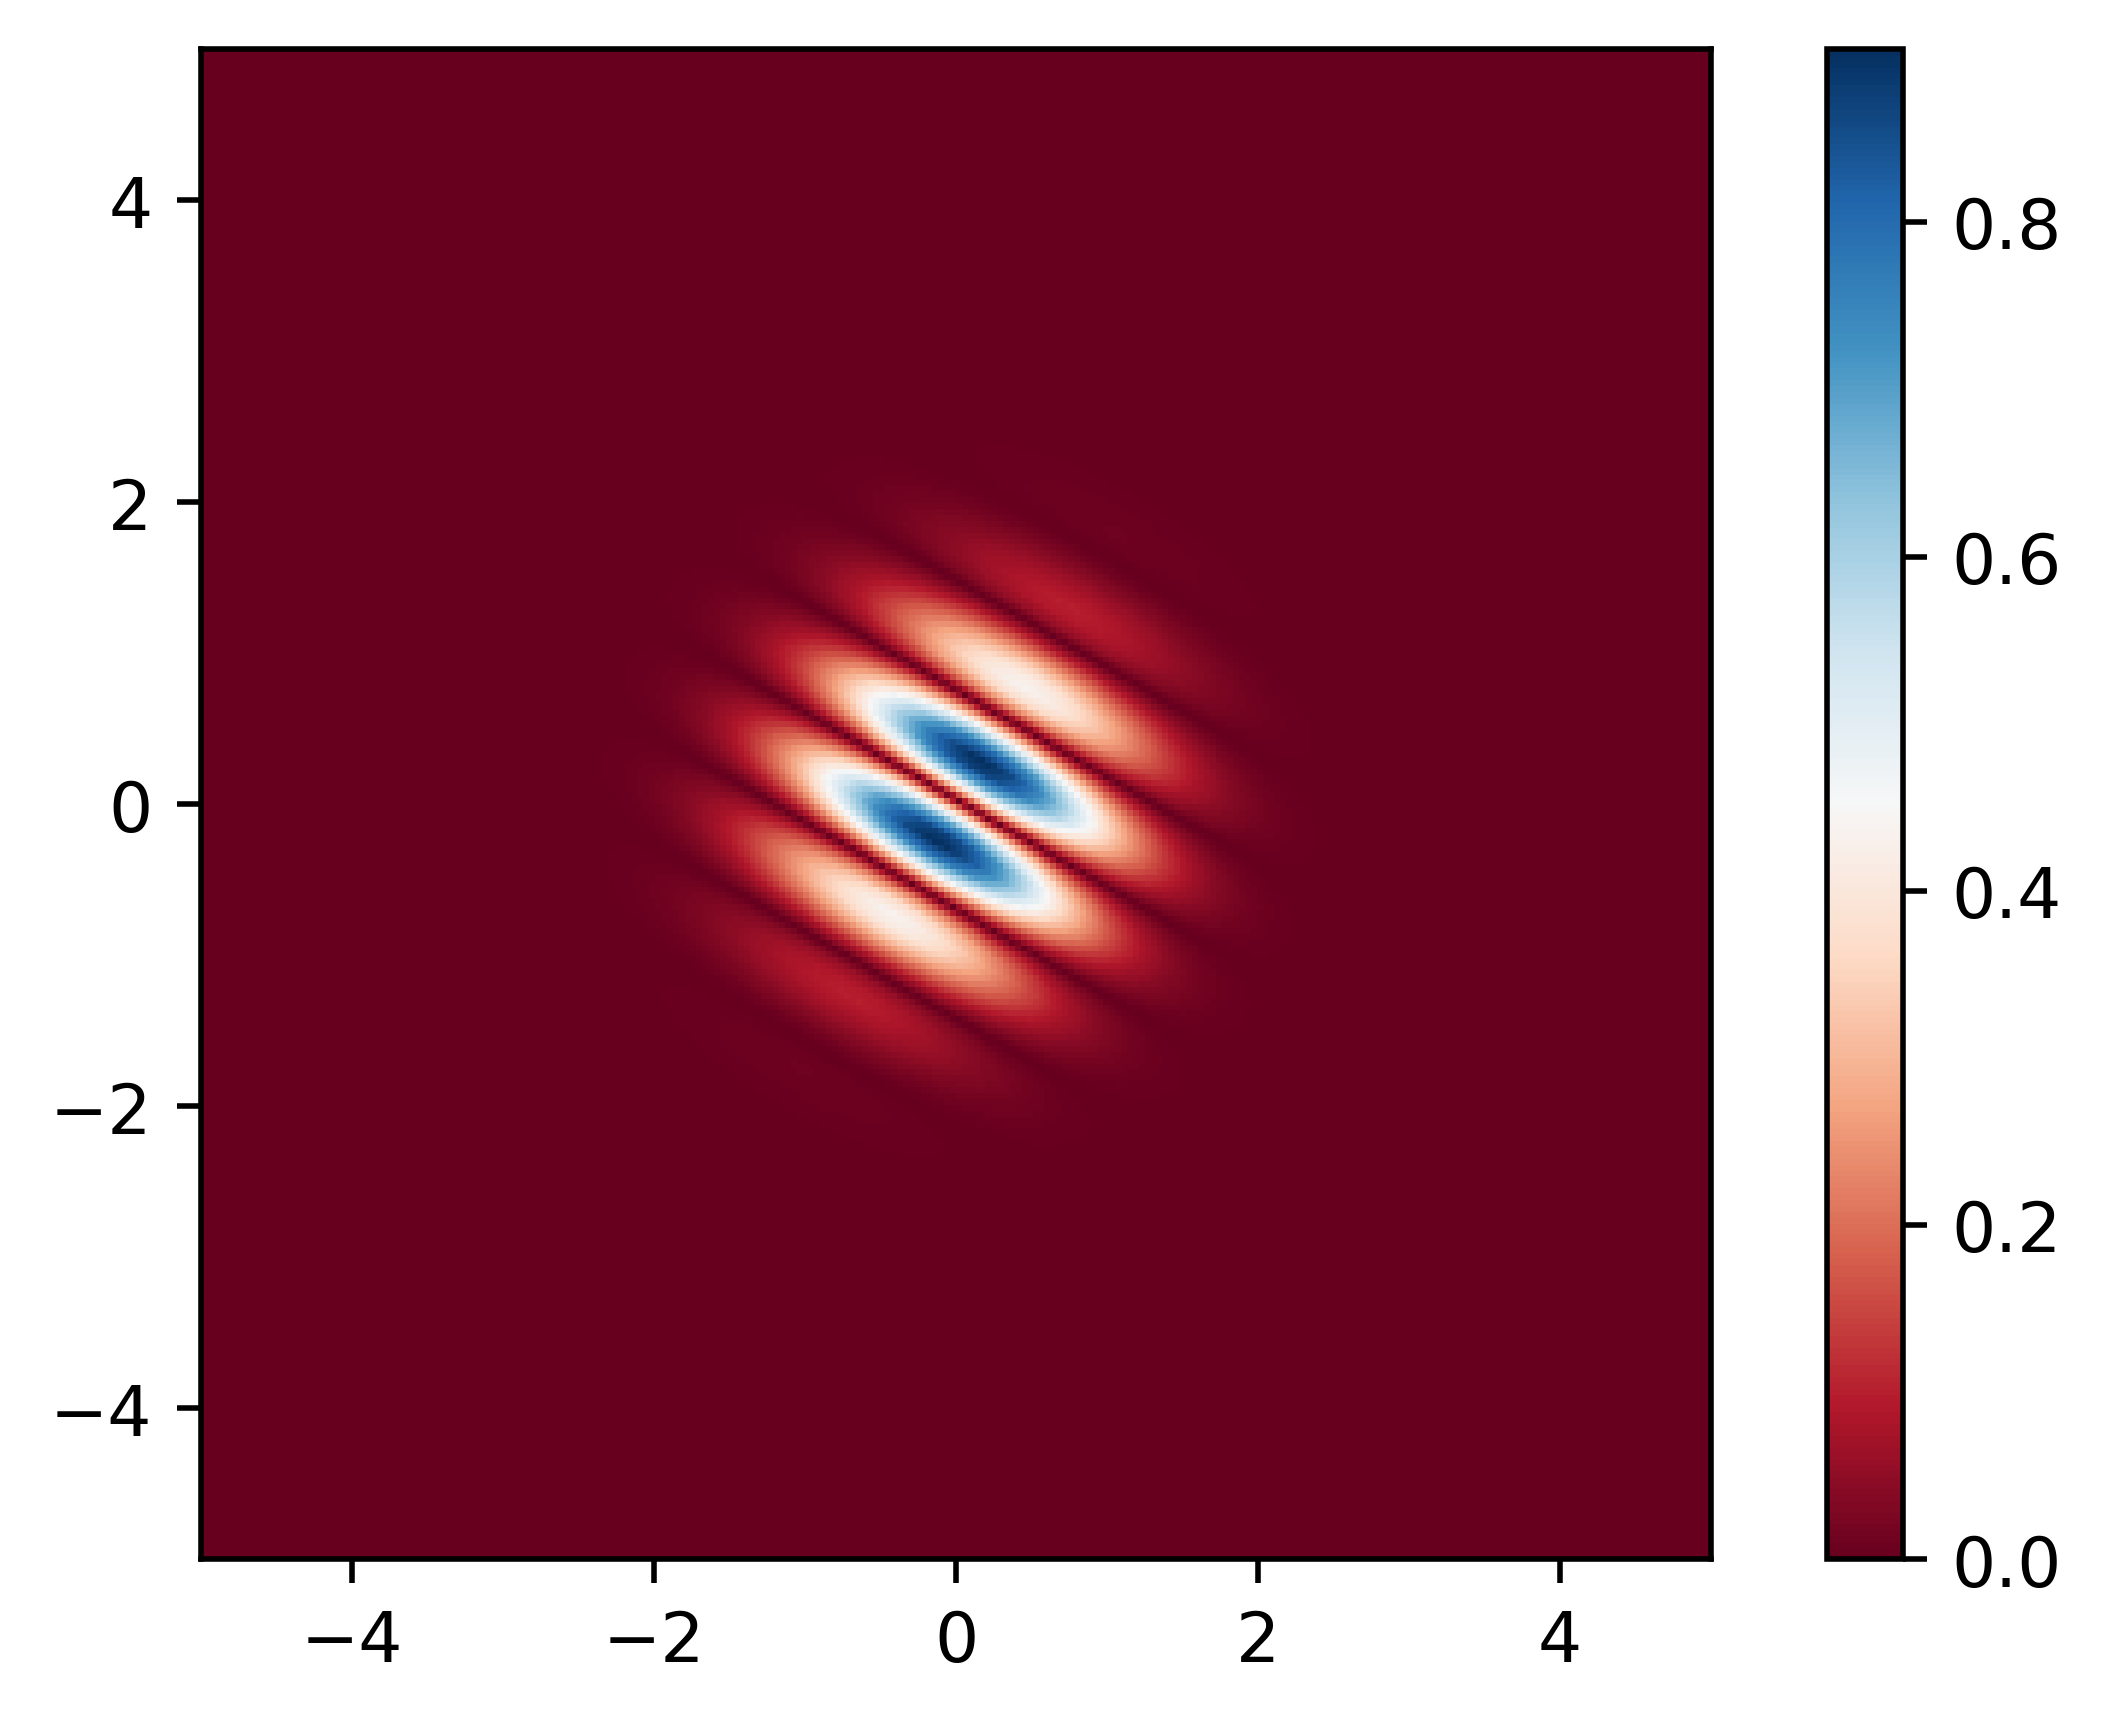

In [47]:
plot_im(getENorm(gridMapping, shape, minCoords, maxCoords),
        vmin=None, vmax=None,
        a=(minCoords.x, minCoords.y),
        b=(maxCoords.x, maxCoords.y)
       )

We also can simulate the process, and the beam will propagate along the specified direction.

In [48]:
fieldSolver = hichi.PSATD(grid)
fieldSolver.convertFieldsPoissonEquation()
fieldSolver.updateFields()

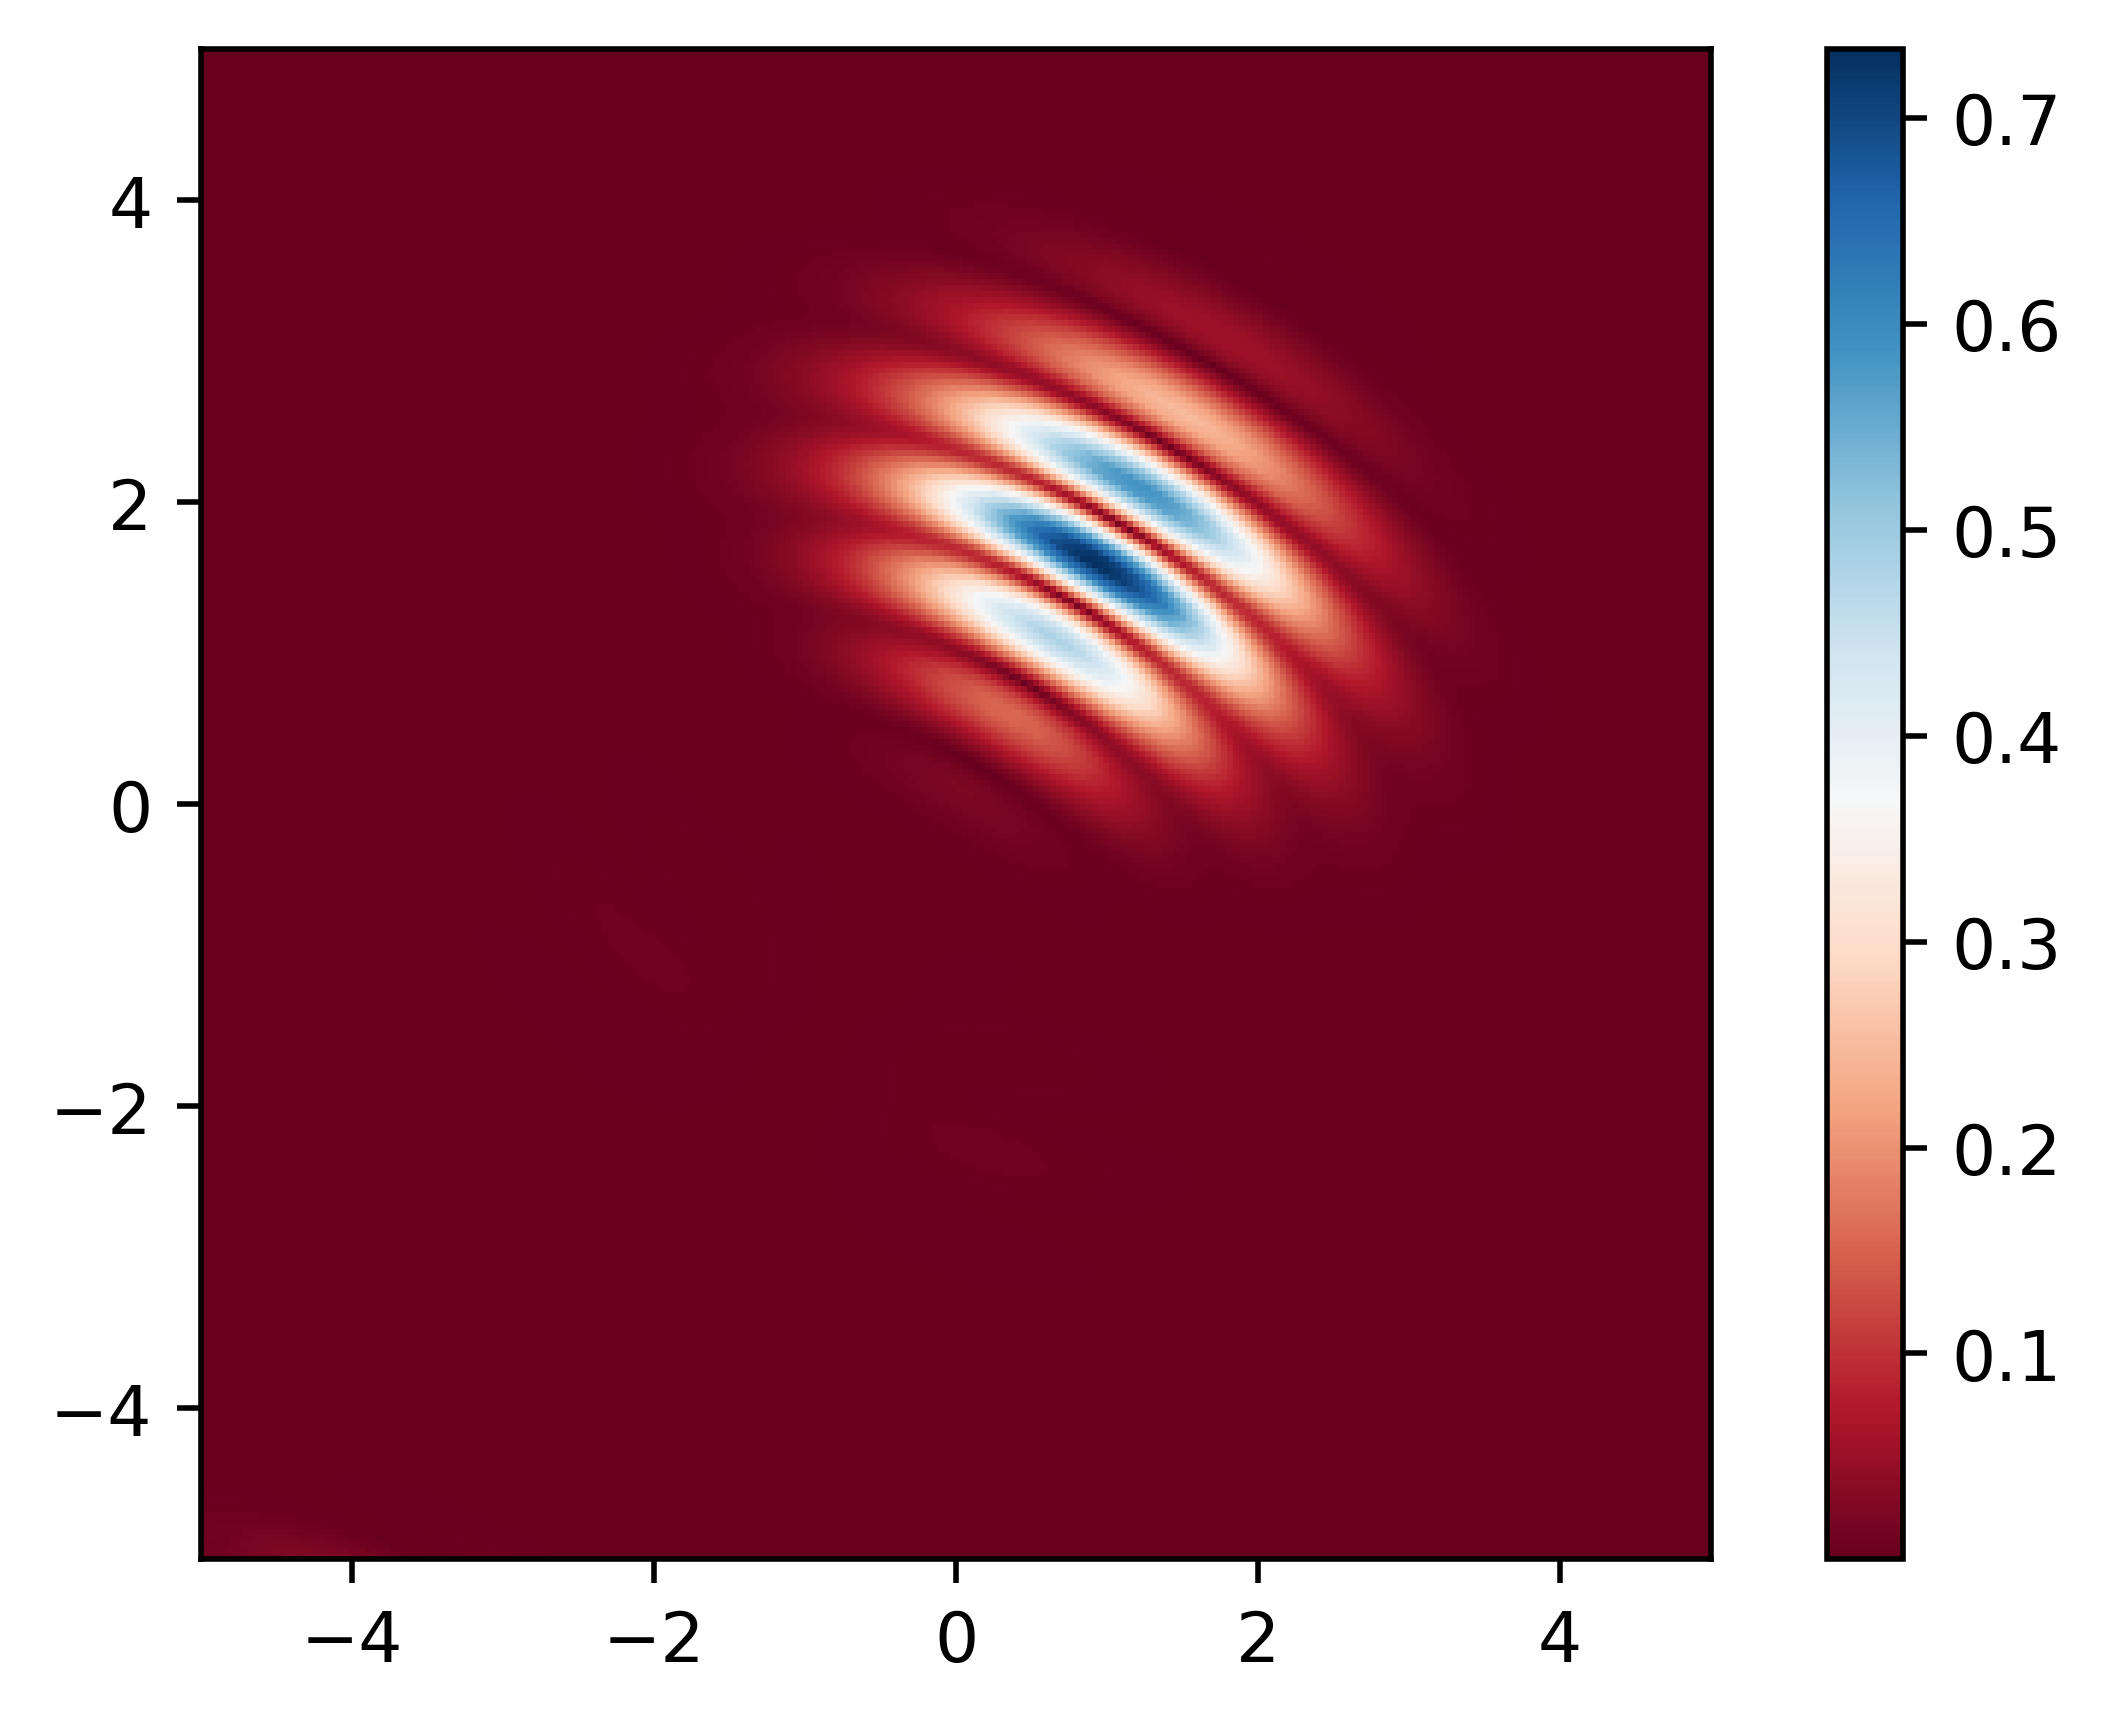

In [49]:
plot_im(getENorm(gridMapping, shape, minCoords, maxCoords),
        vmin=None, vmax=None,
        a=(minCoords.x, minCoords.y),
        b=(maxCoords.x, maxCoords.y)
       )

## Tight Focusing Mapping

Based on the geometric properties of the tight focusing problem, only a small fraction of the computational grid accommodates the pulse. The main idea is to reduce computational costs due to areas with zero field values. However, to ensure the absence of numerical dispersion, the calculation is performed in the spectral space, and, therefore, it is not possible to exclude these regions from the calculation in an obvious way. We propose to get rid of additional computational costs by introducing a periodic structure of the field and, as a consequence, reducing the initial region to a thin layer along the x-axis.

Consider the original computational domain.

In [50]:
minFullCoords = hichi.vector3d(-20, -20, -20)
maxFullCoords = hichi.vector3d(20, 20, 20)
fullGridSize = hichi.vector3d(256, 256, 256)

Let's set the width of the band $D$ along x-axis. In  practice, it is usually sufficient to take the parameter $D$ equal to 3−4 pulse lengths. We choose $D$ equal to 3.75 pulse lengths to get the grid size equal to 48 nodes along x-axis.

In [51]:
D = 3.75*pulselength  # the band width
print(D)

7.5


In [52]:
newGridSizeX = int(fullGridSize.x*D/(maxFullCoords.x - minFullCoords.x))
print(newGridSizeX)

48


The next step is to create the approciate mapping.

In [53]:
mapping = hichi.TightFocusingMapping(R0, pulselength, D)

The mapping sets up the band boundaries independently. We can get them by calling the *getxMin()* and *getxMax()* methods. 

In [54]:
xMin = mapping.getxMin()
xMax = mapping.getxMax()
print(xMin, xMax)

-22.5 -15.0


Knowing all the simulation parameters, we can create a computational grid.

In [55]:
minCoords = hichi.vector3d(xMin, -20, -20)
maxCoords = hichi.vector3d(xMax, 20, 20)
gridSize = hichi.vector3d(newGridSizeX, fullGridSize.y, fullGridSize.z)
gridStep = (maxCoords - minCoords) / gridSize
timeStep = R0*0.5/hichi.c

In [56]:
grid = hichi.PSATDGridMapping(gridSize, timeStep, minCoords, gridStep)
grid.setMapping(mapping)

Since the grid size has decreased, we can expect that initialization costs will decrease by 256/48 $\approx$ 5.33 times. It should be noted that there is additional overhead for performing the transform.

In [57]:
start_time = time.process_time()

# initialisation using a compiled Python function
grid.set(getEMFieldNumbaFunc.address)

final_time = time.process_time()
numba_func_init_time_band = final_time - start_time
print("Time is %0.2f sec" % (numba_func_init_time_band))
print("Computational costs decreased by %0.2f times" % \
           (numba_func_init_time/numba_func_init_time_band))

Time is 2.86 sec
Computational costs decreased by 5.77 times


Since the mapping is done automatically, we can get the values of the electromagnetic field in the original area.

In [58]:
def getField():
    return getENorm(grid,
                    (4*int(fullGridSize.x), 4*int(fullGridSize.y)),
                    minFullCoords,
                    maxFullCoords
                   )

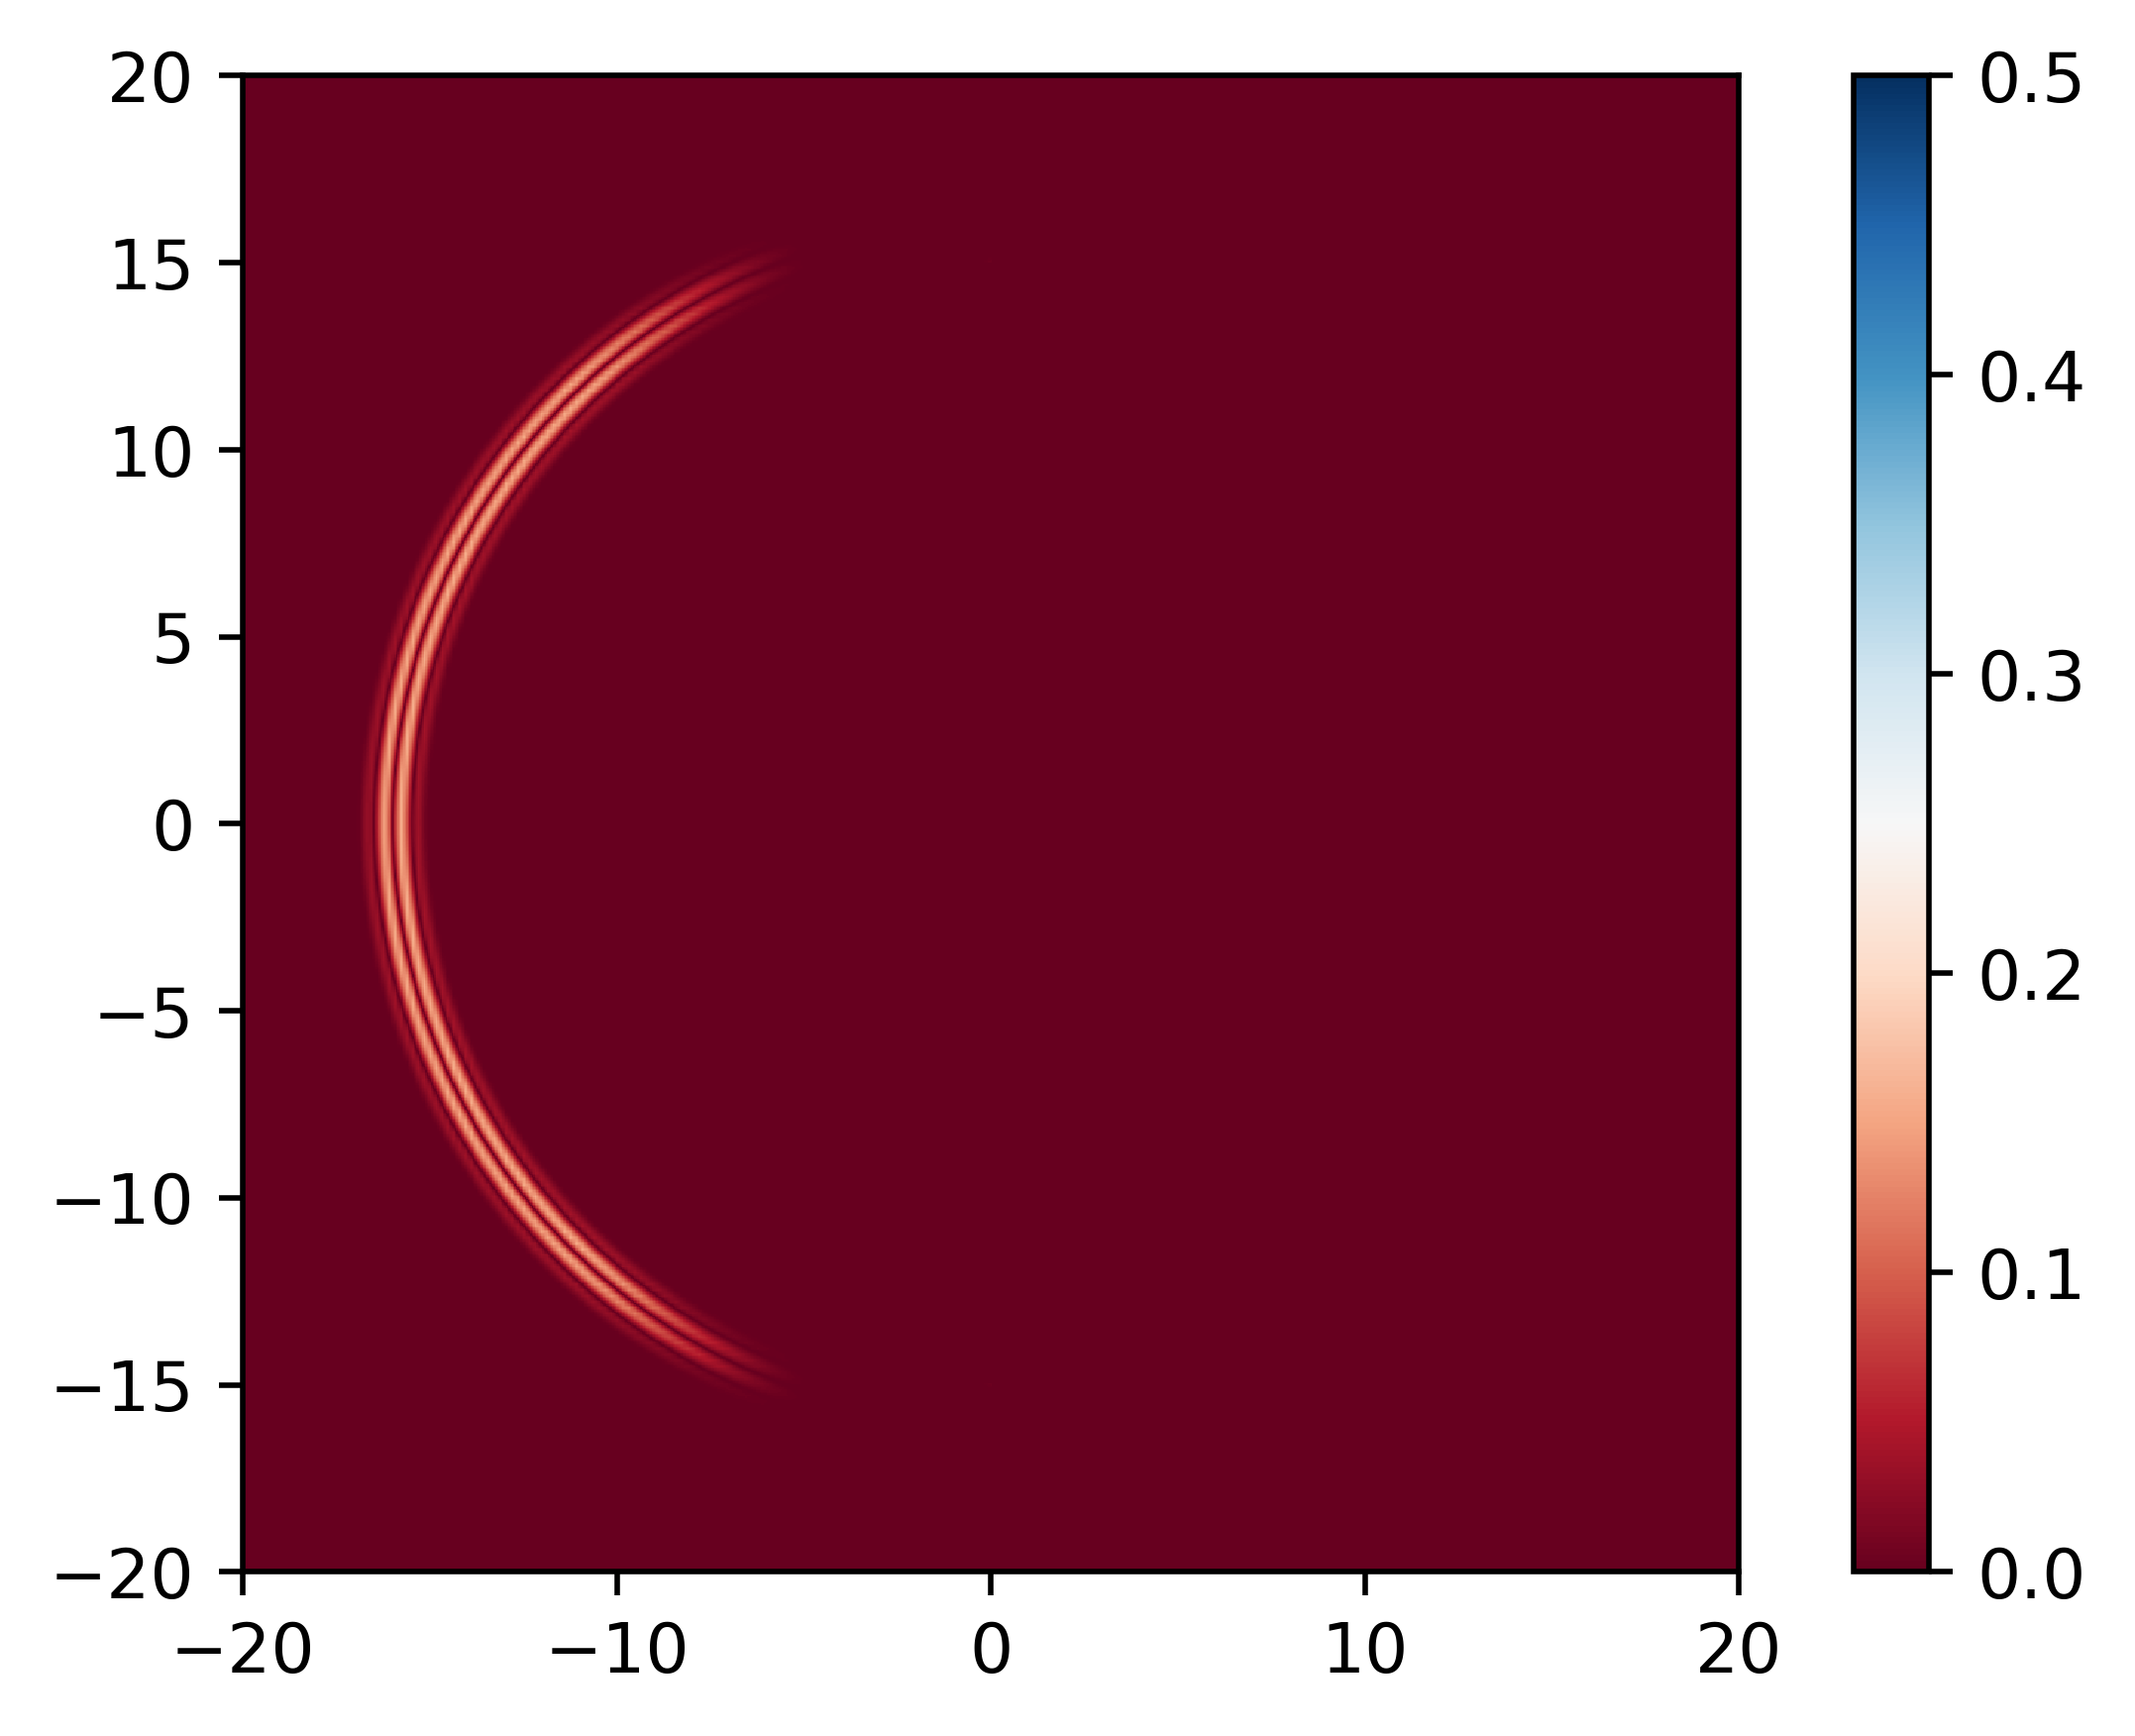

In [59]:
plot_im(getField())

To illustrate how the mapping works, let's disable the inverse transform. To do this, we need to modify the mapping instance accordingly by calling the *setIfCut()* method and then re-place it on the grid.

In [60]:
mapping.setIfCut(False)
grid.popMapping()
grid.setMapping(mapping)

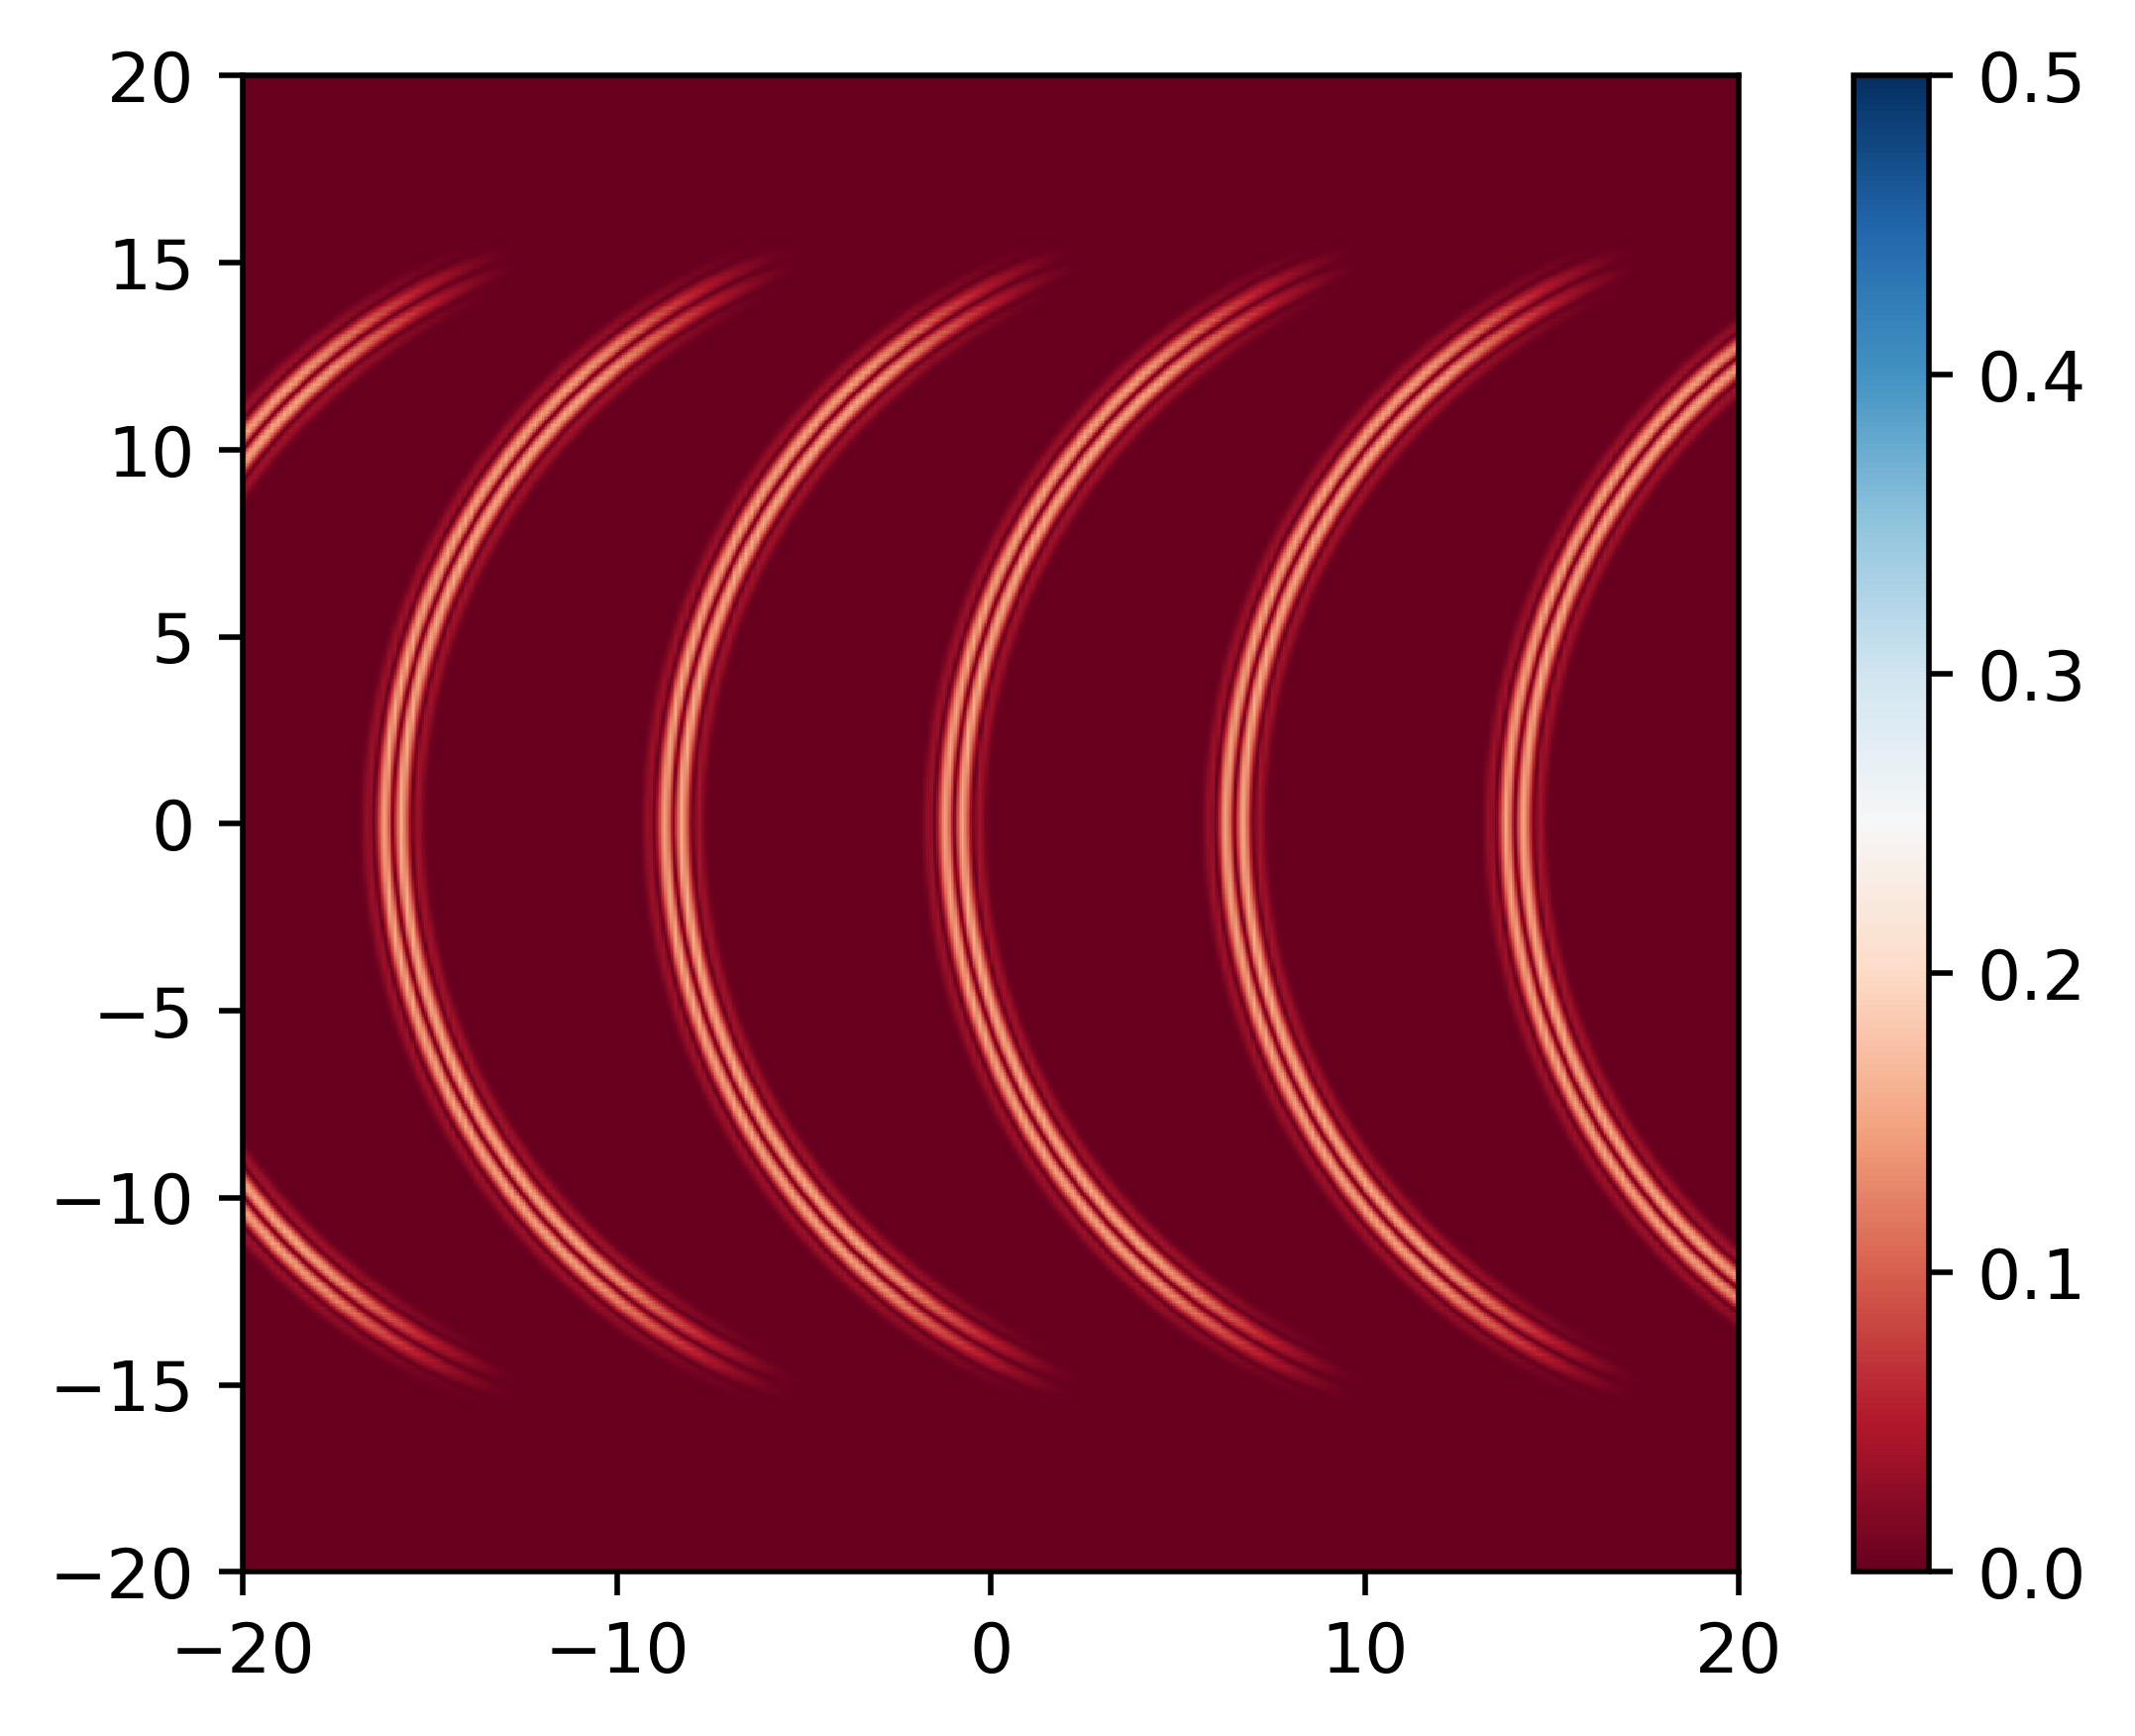

In [61]:
plot_im(getField())

We can see that the initial pulse was duplicated along the x-axis, as a result of which the space became periodic. This allows the simulation to be performed out only in the band shown below.

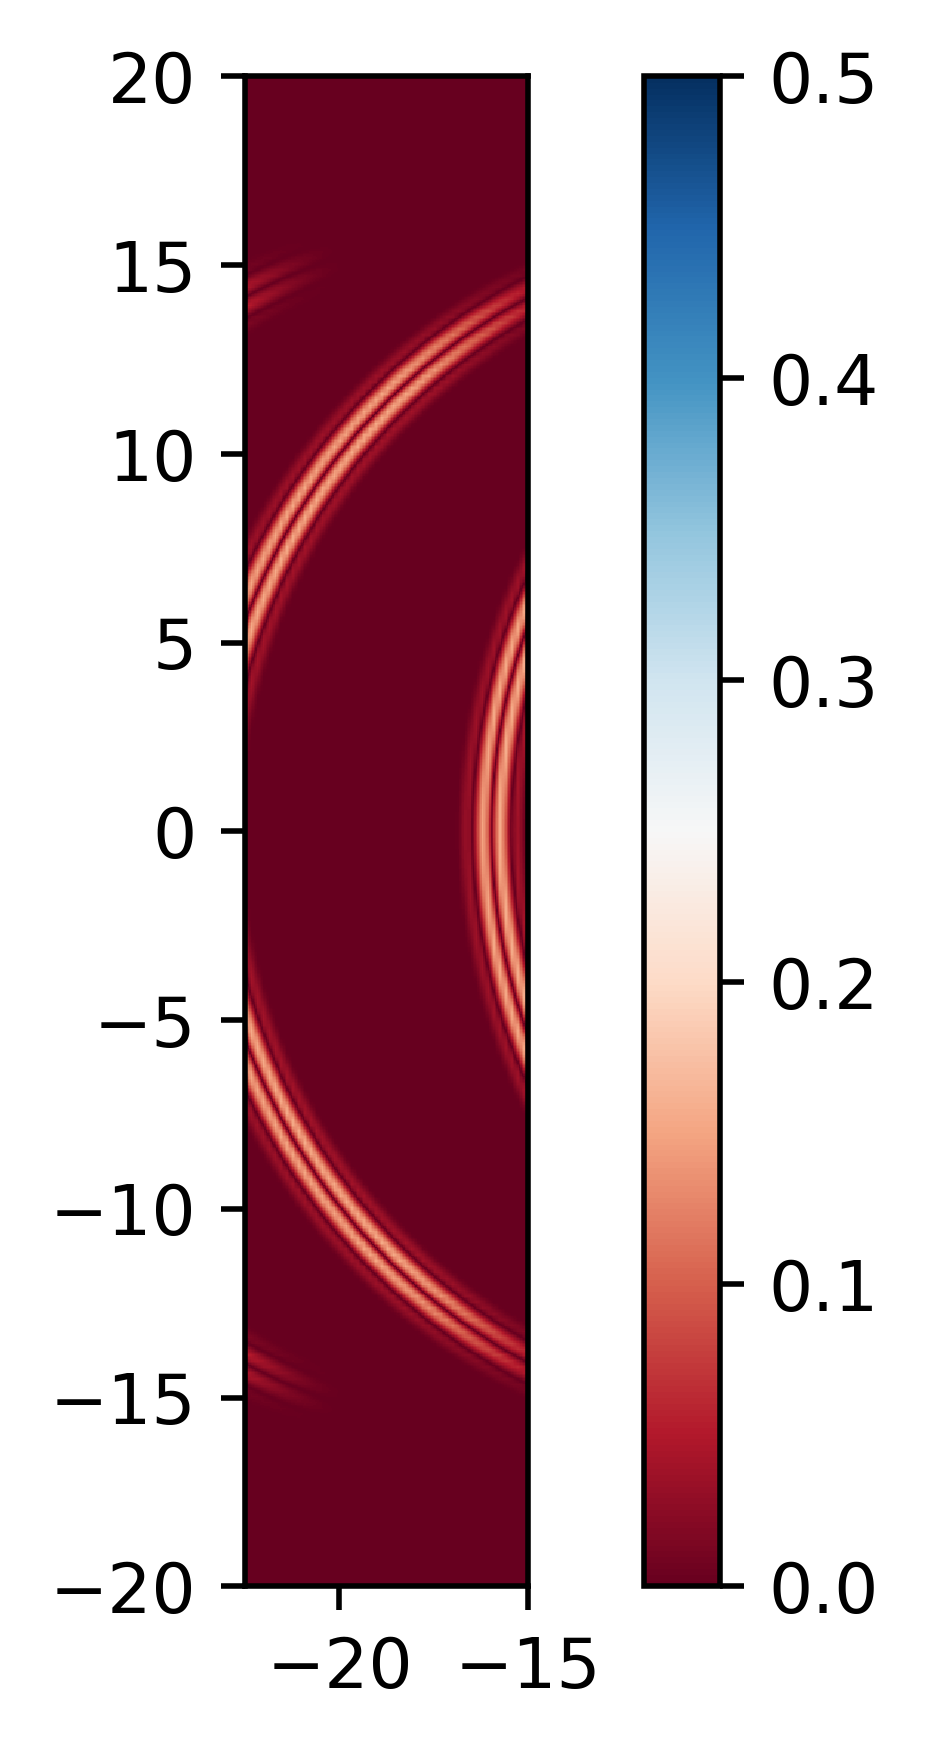

In [62]:
shape = (4*int(gridSize.x), 4*int(gridSize.y))
plot_im(getENorm(grid, shape, minCoords, maxCoords),
        a=(minCoords.x, minCoords.y),
        b=(maxCoords.x, maxCoords.y)
       )

The following code creates an instance of the PSATD field solver that takes Poisson's correction into account for each iteration. This allows us not to call the *fieldSolver.convertFieldsPoissonEquation()* function and thereby save on one forward and one inverse fast Fourier transform.

In [63]:
fieldSolver = hichi.PSATDPoisson(grid)

Since the mapping is performed only when the grid is initialized and the field values are obtained, then we can expect the maximum gain of the scheme in time when the field solver is executed.

In [64]:
start_time = time.process_time()

fieldSolver.updateFields()

final_time = time.process_time()
field_solver_time_band = final_time - start_time
print("Time is %0.2f sec" % (final_time - start_time))
print("Computational costs decreased by %0.2f times" % \
                 (field_solver_time/field_solver_time_band))

Time is 1.17 sec
Computational costs decreased by 6.00 times


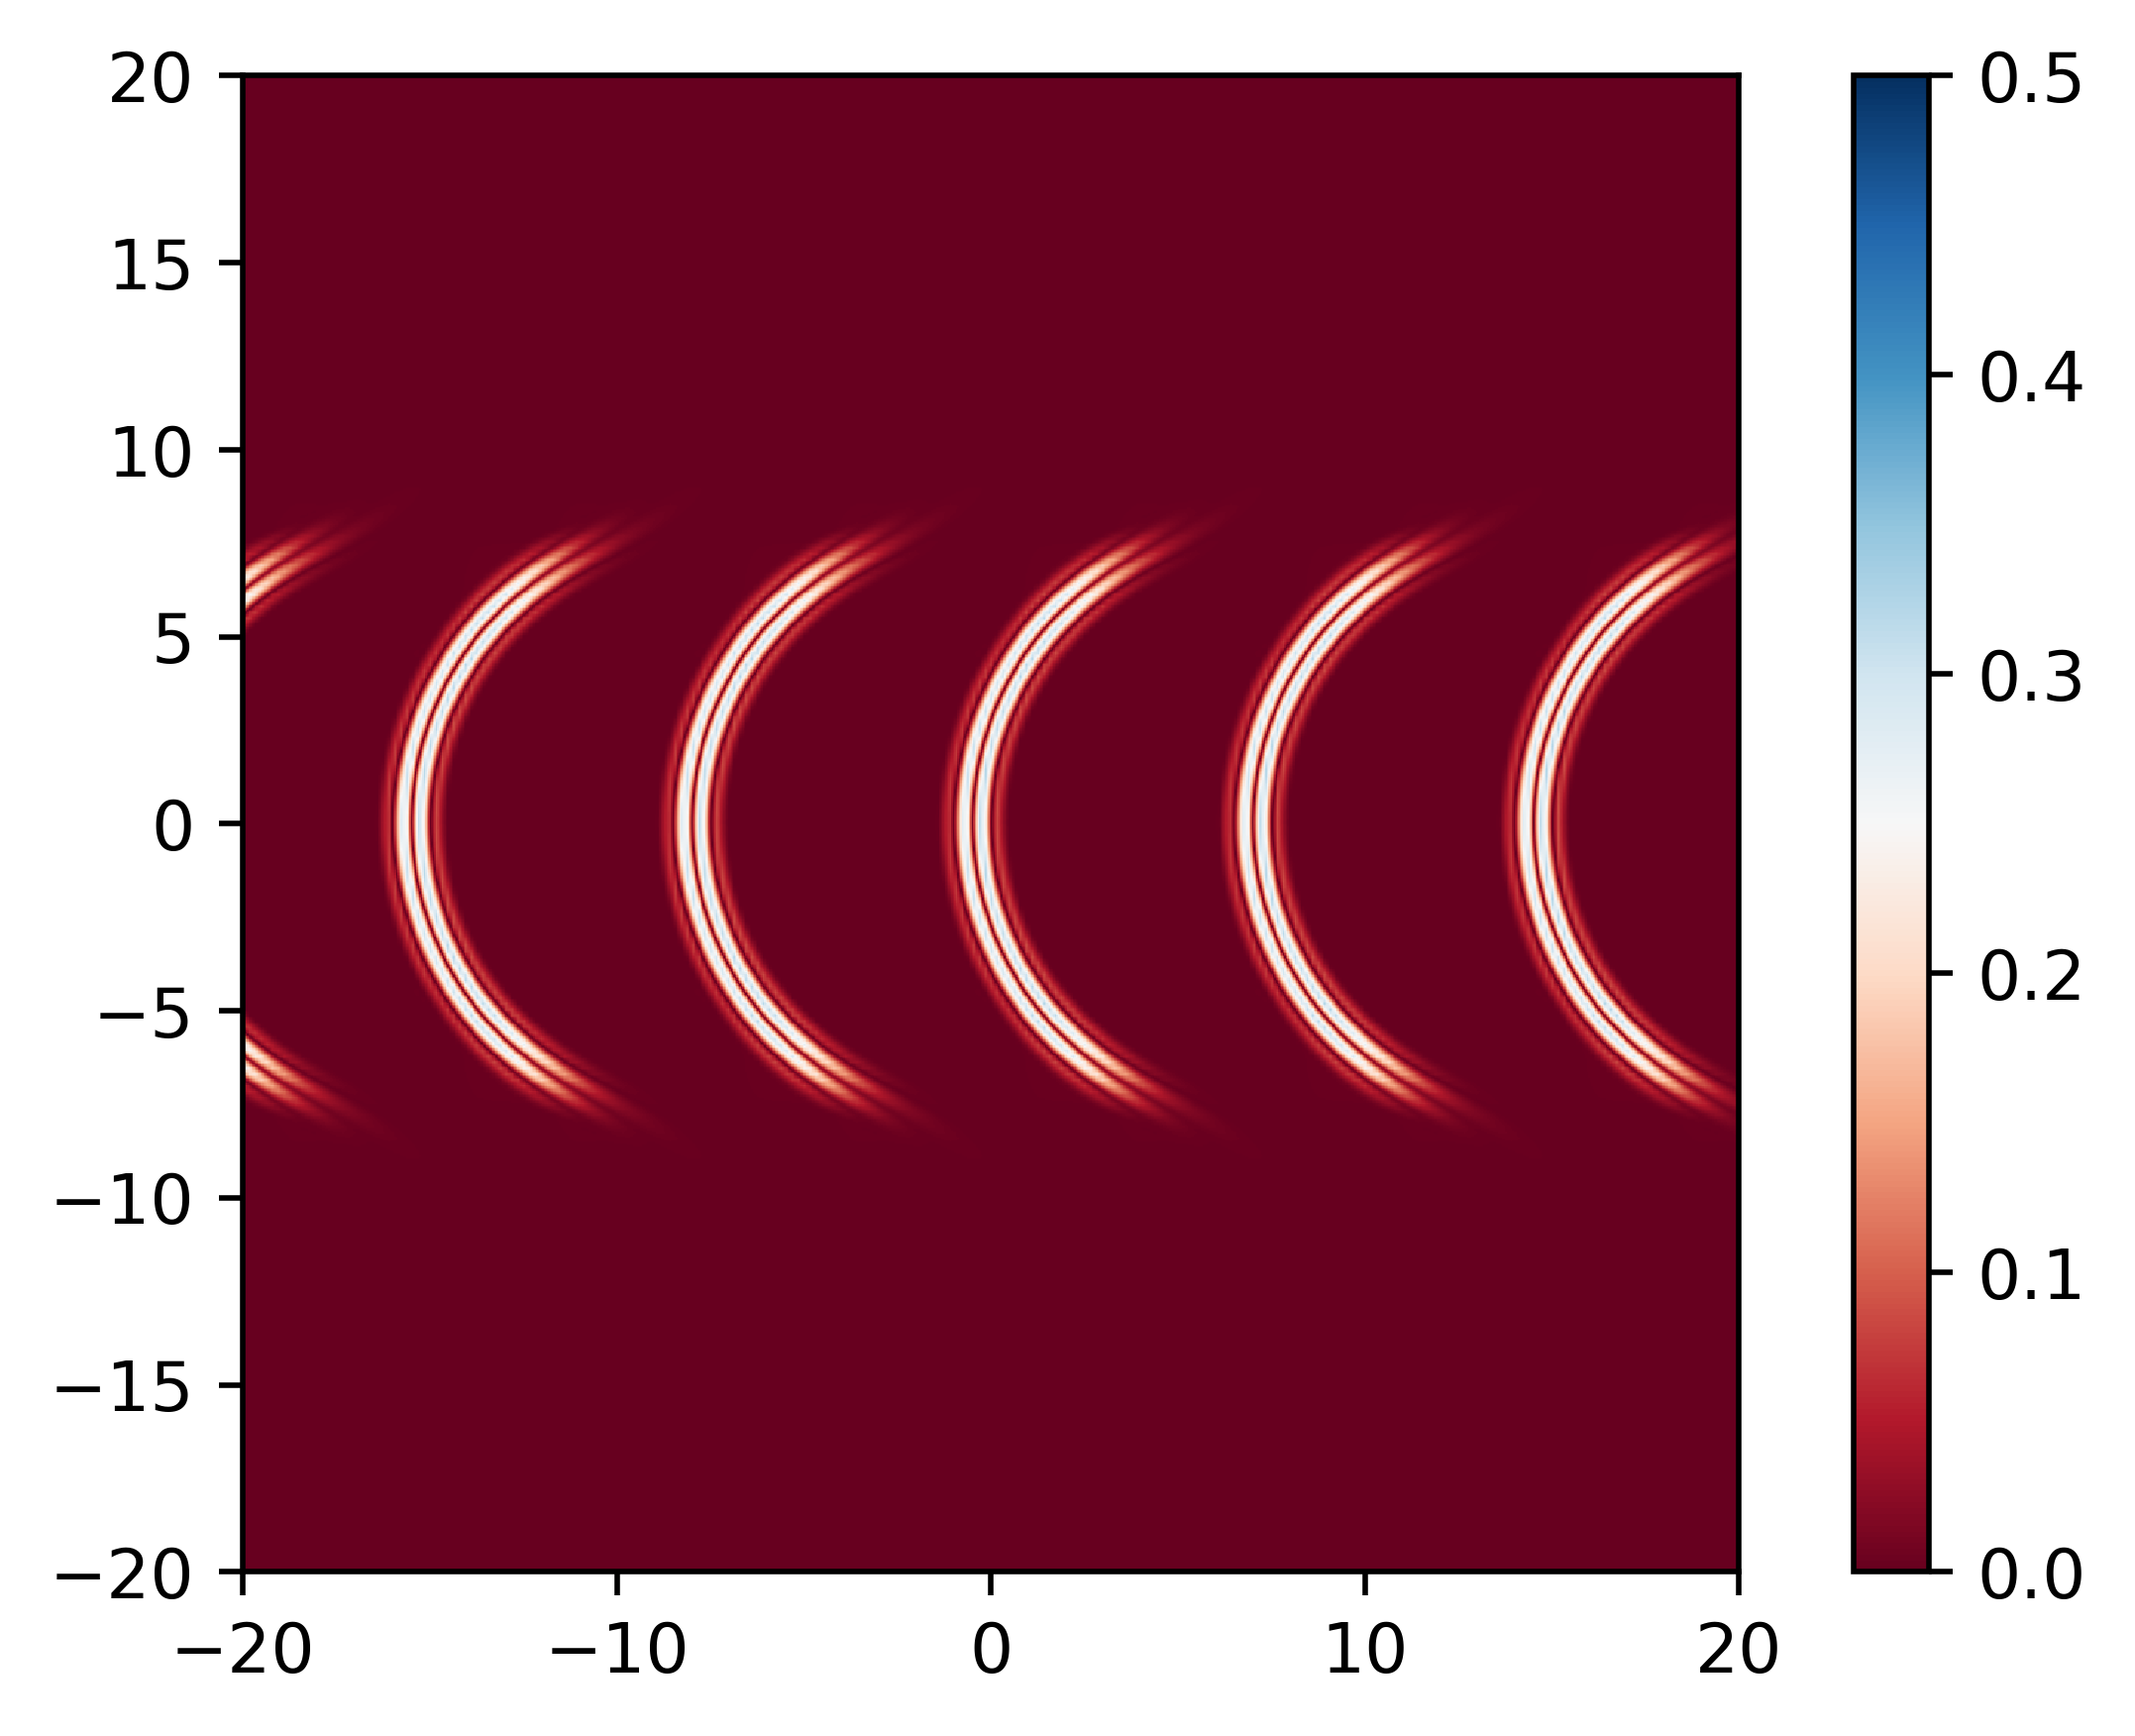

In [65]:
plot_im(getField())

Let's turn on the inverse mapping again, which 'cuts' the original pulse from the periodic space.

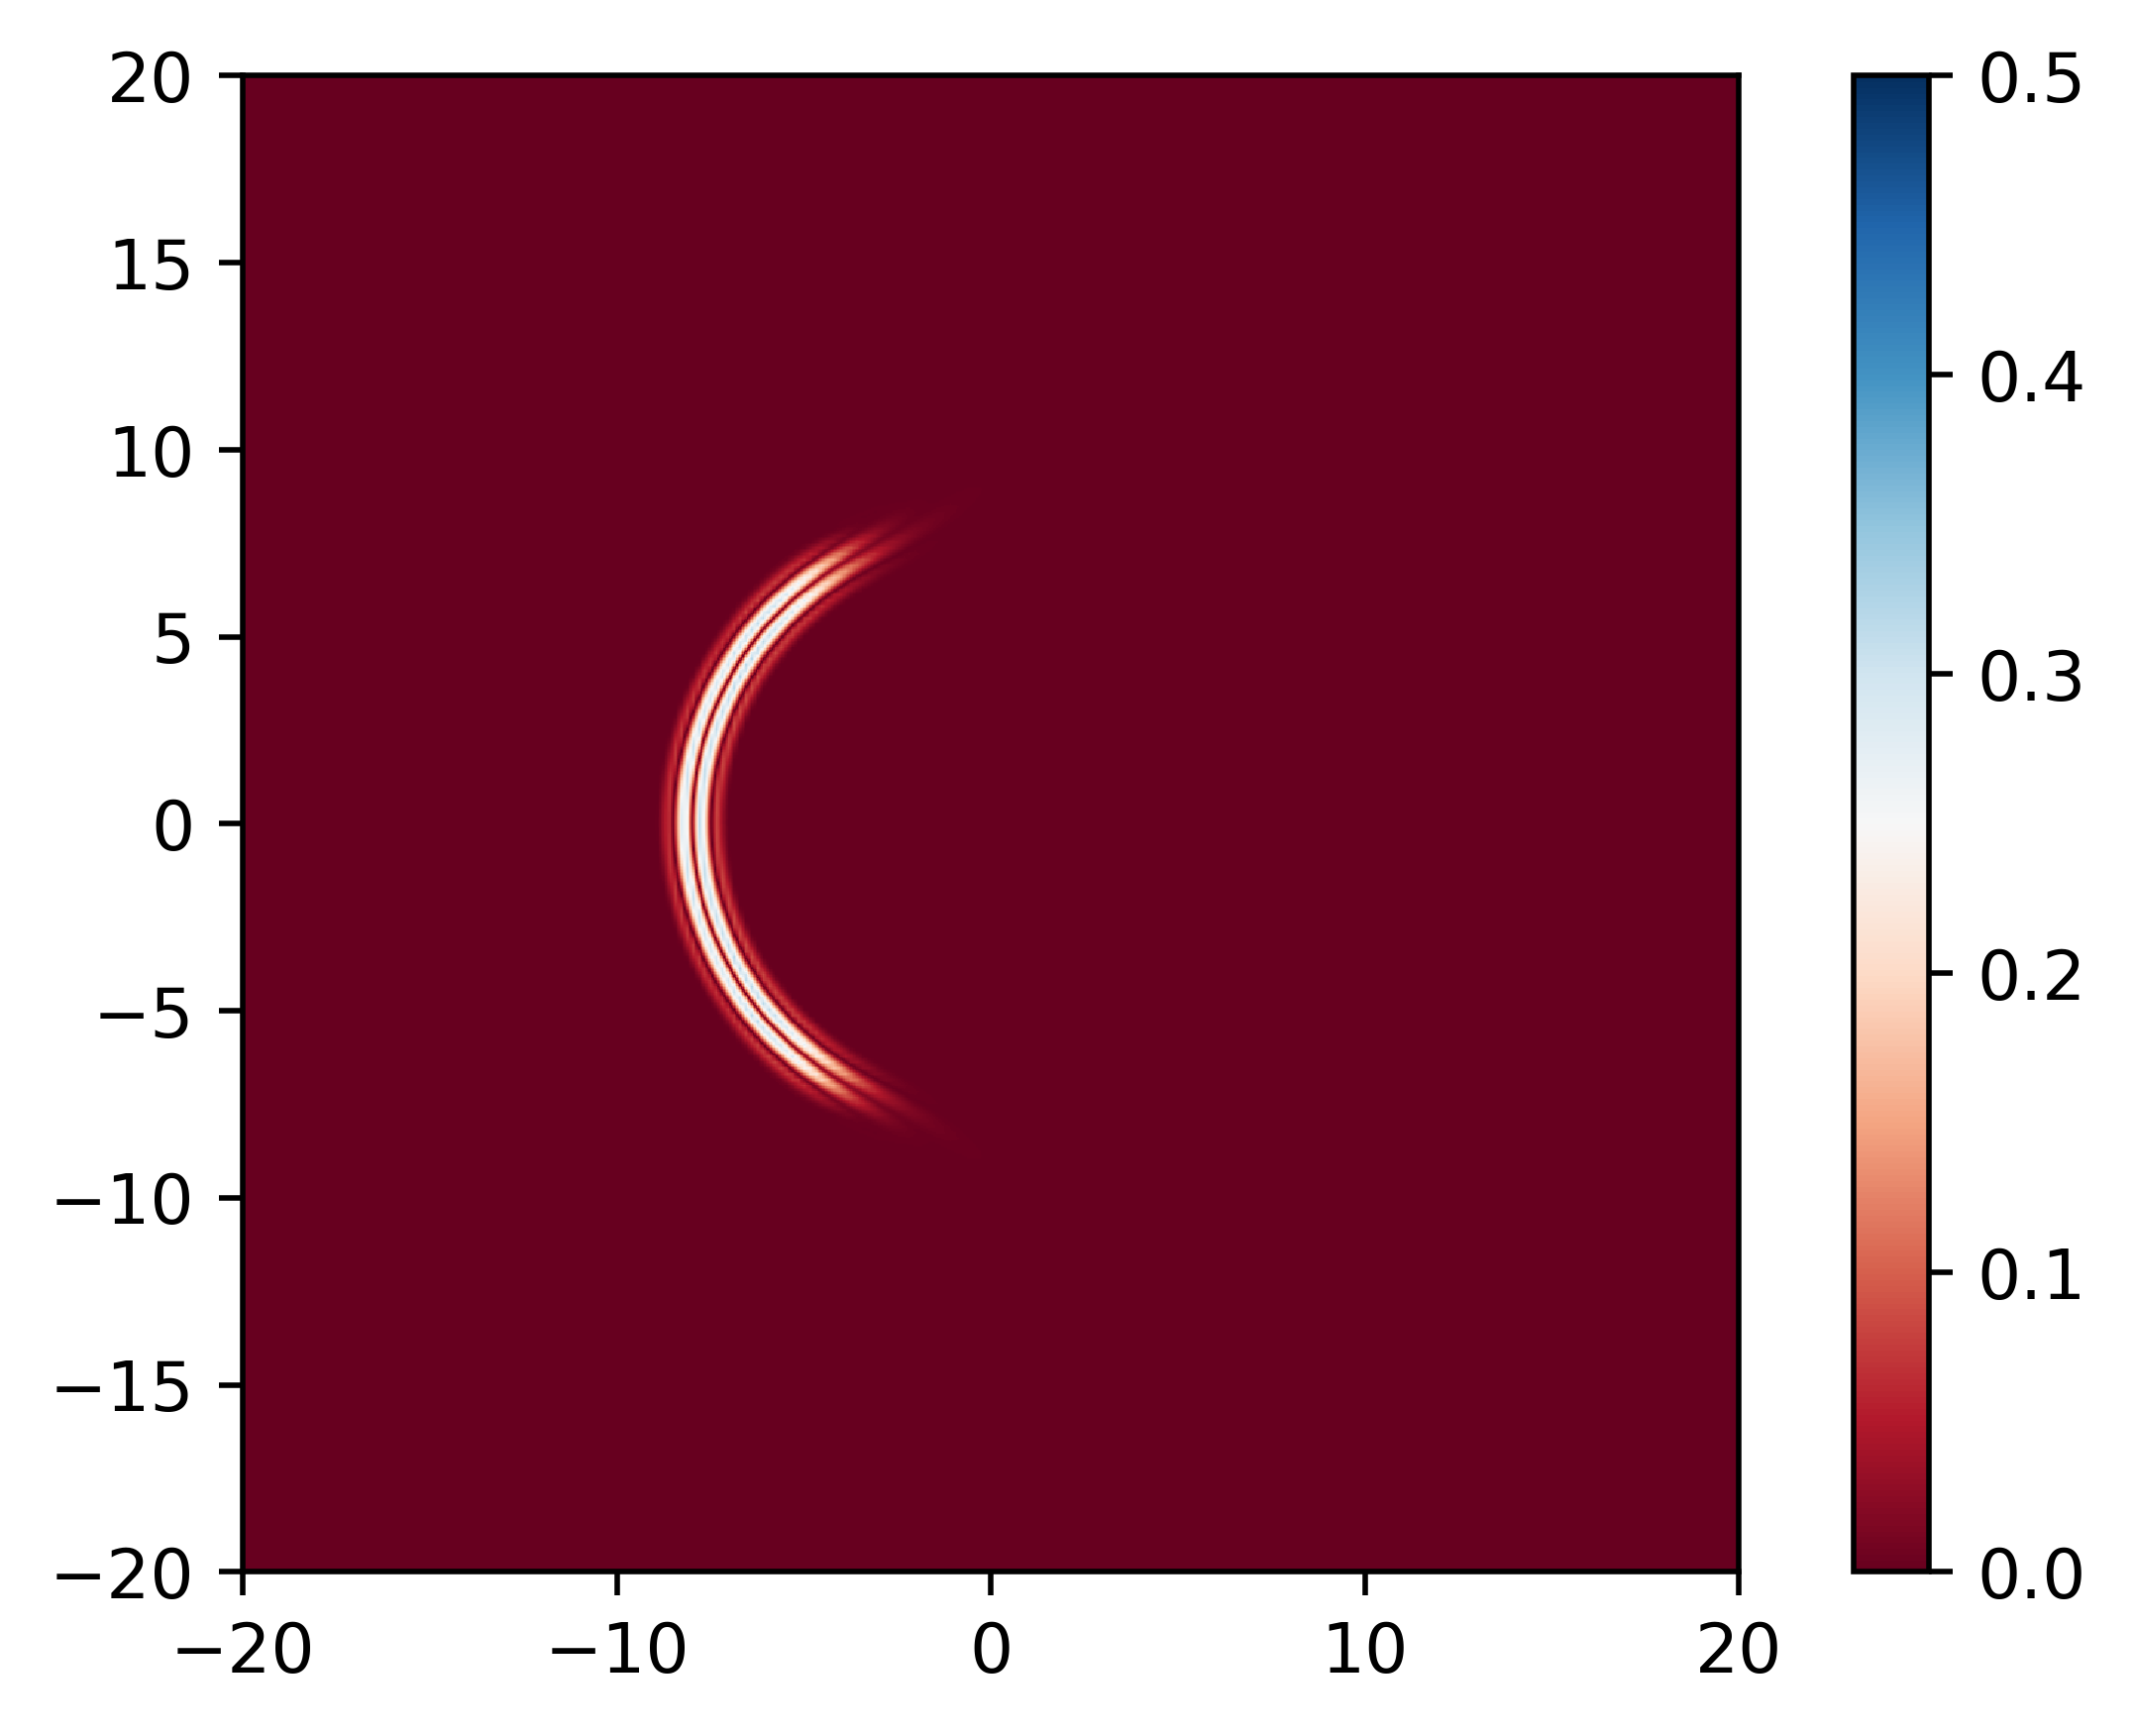

In [66]:
mapping.setIfCut(True)
grid.popMapping()
grid.setMapping(mapping)
plot_im(getField())

The code below does a few more iterations of the solver and determines the peak intensity.

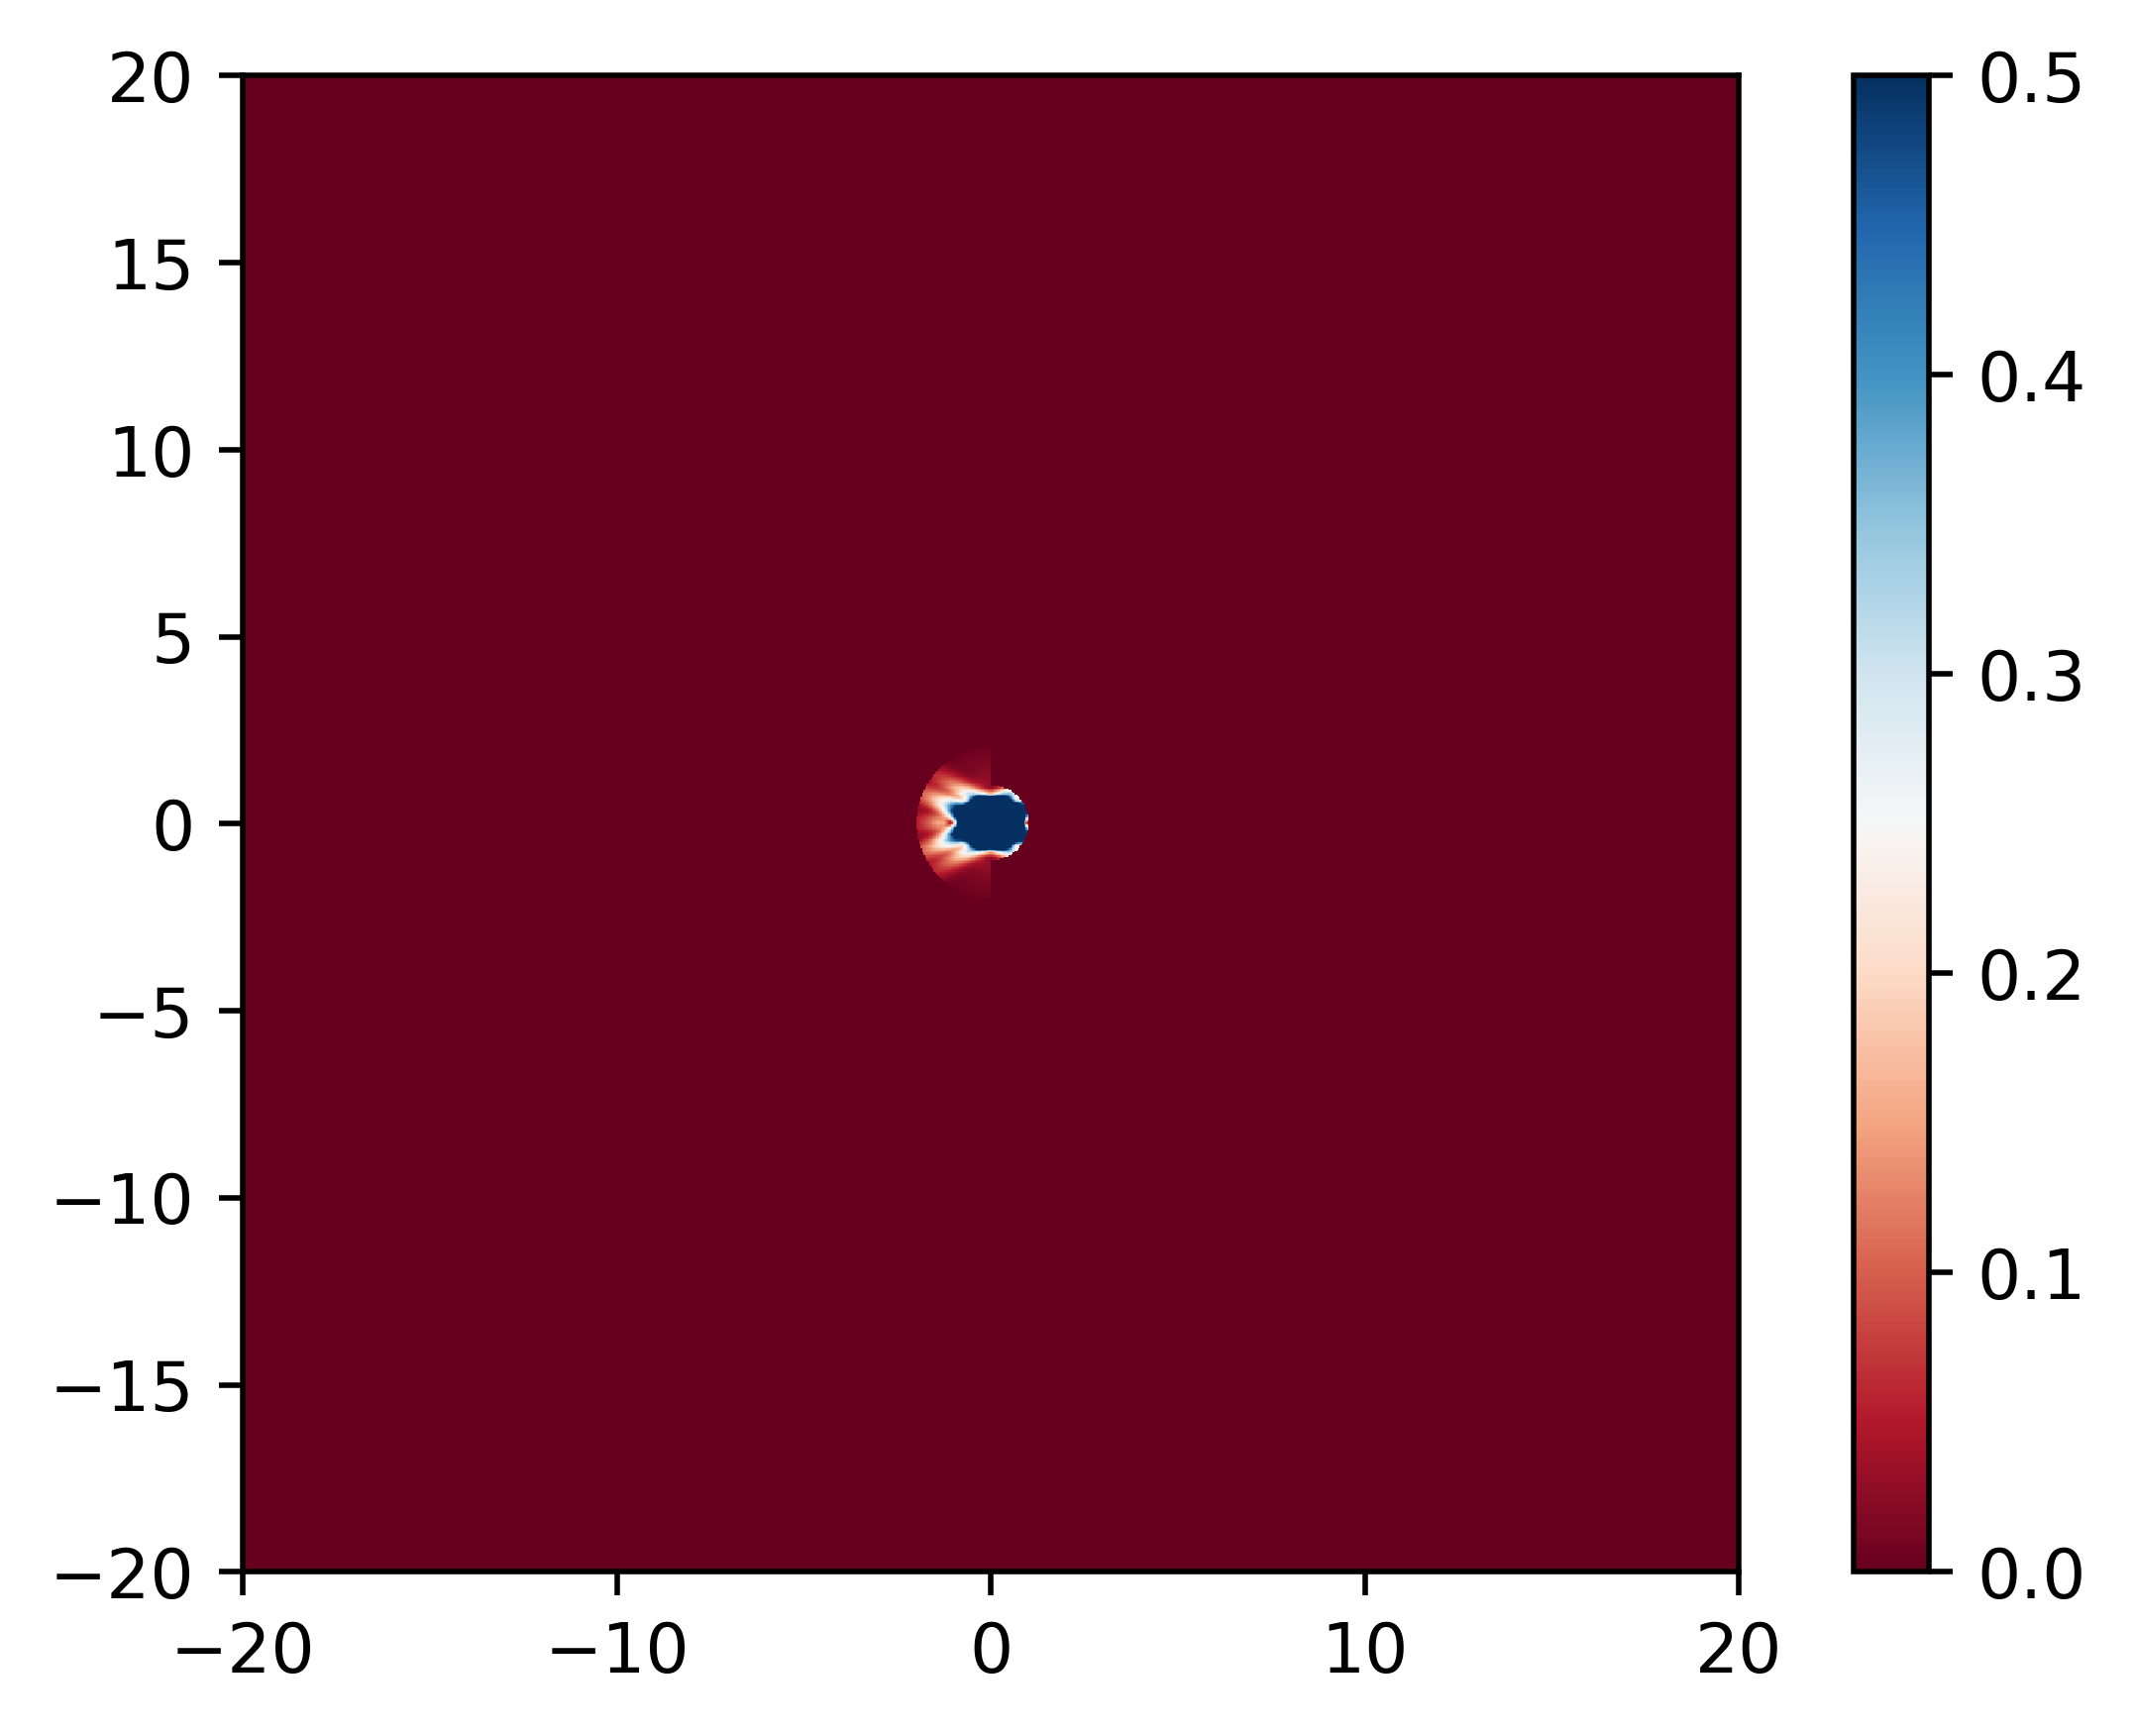

Peak intensity is 7.756775


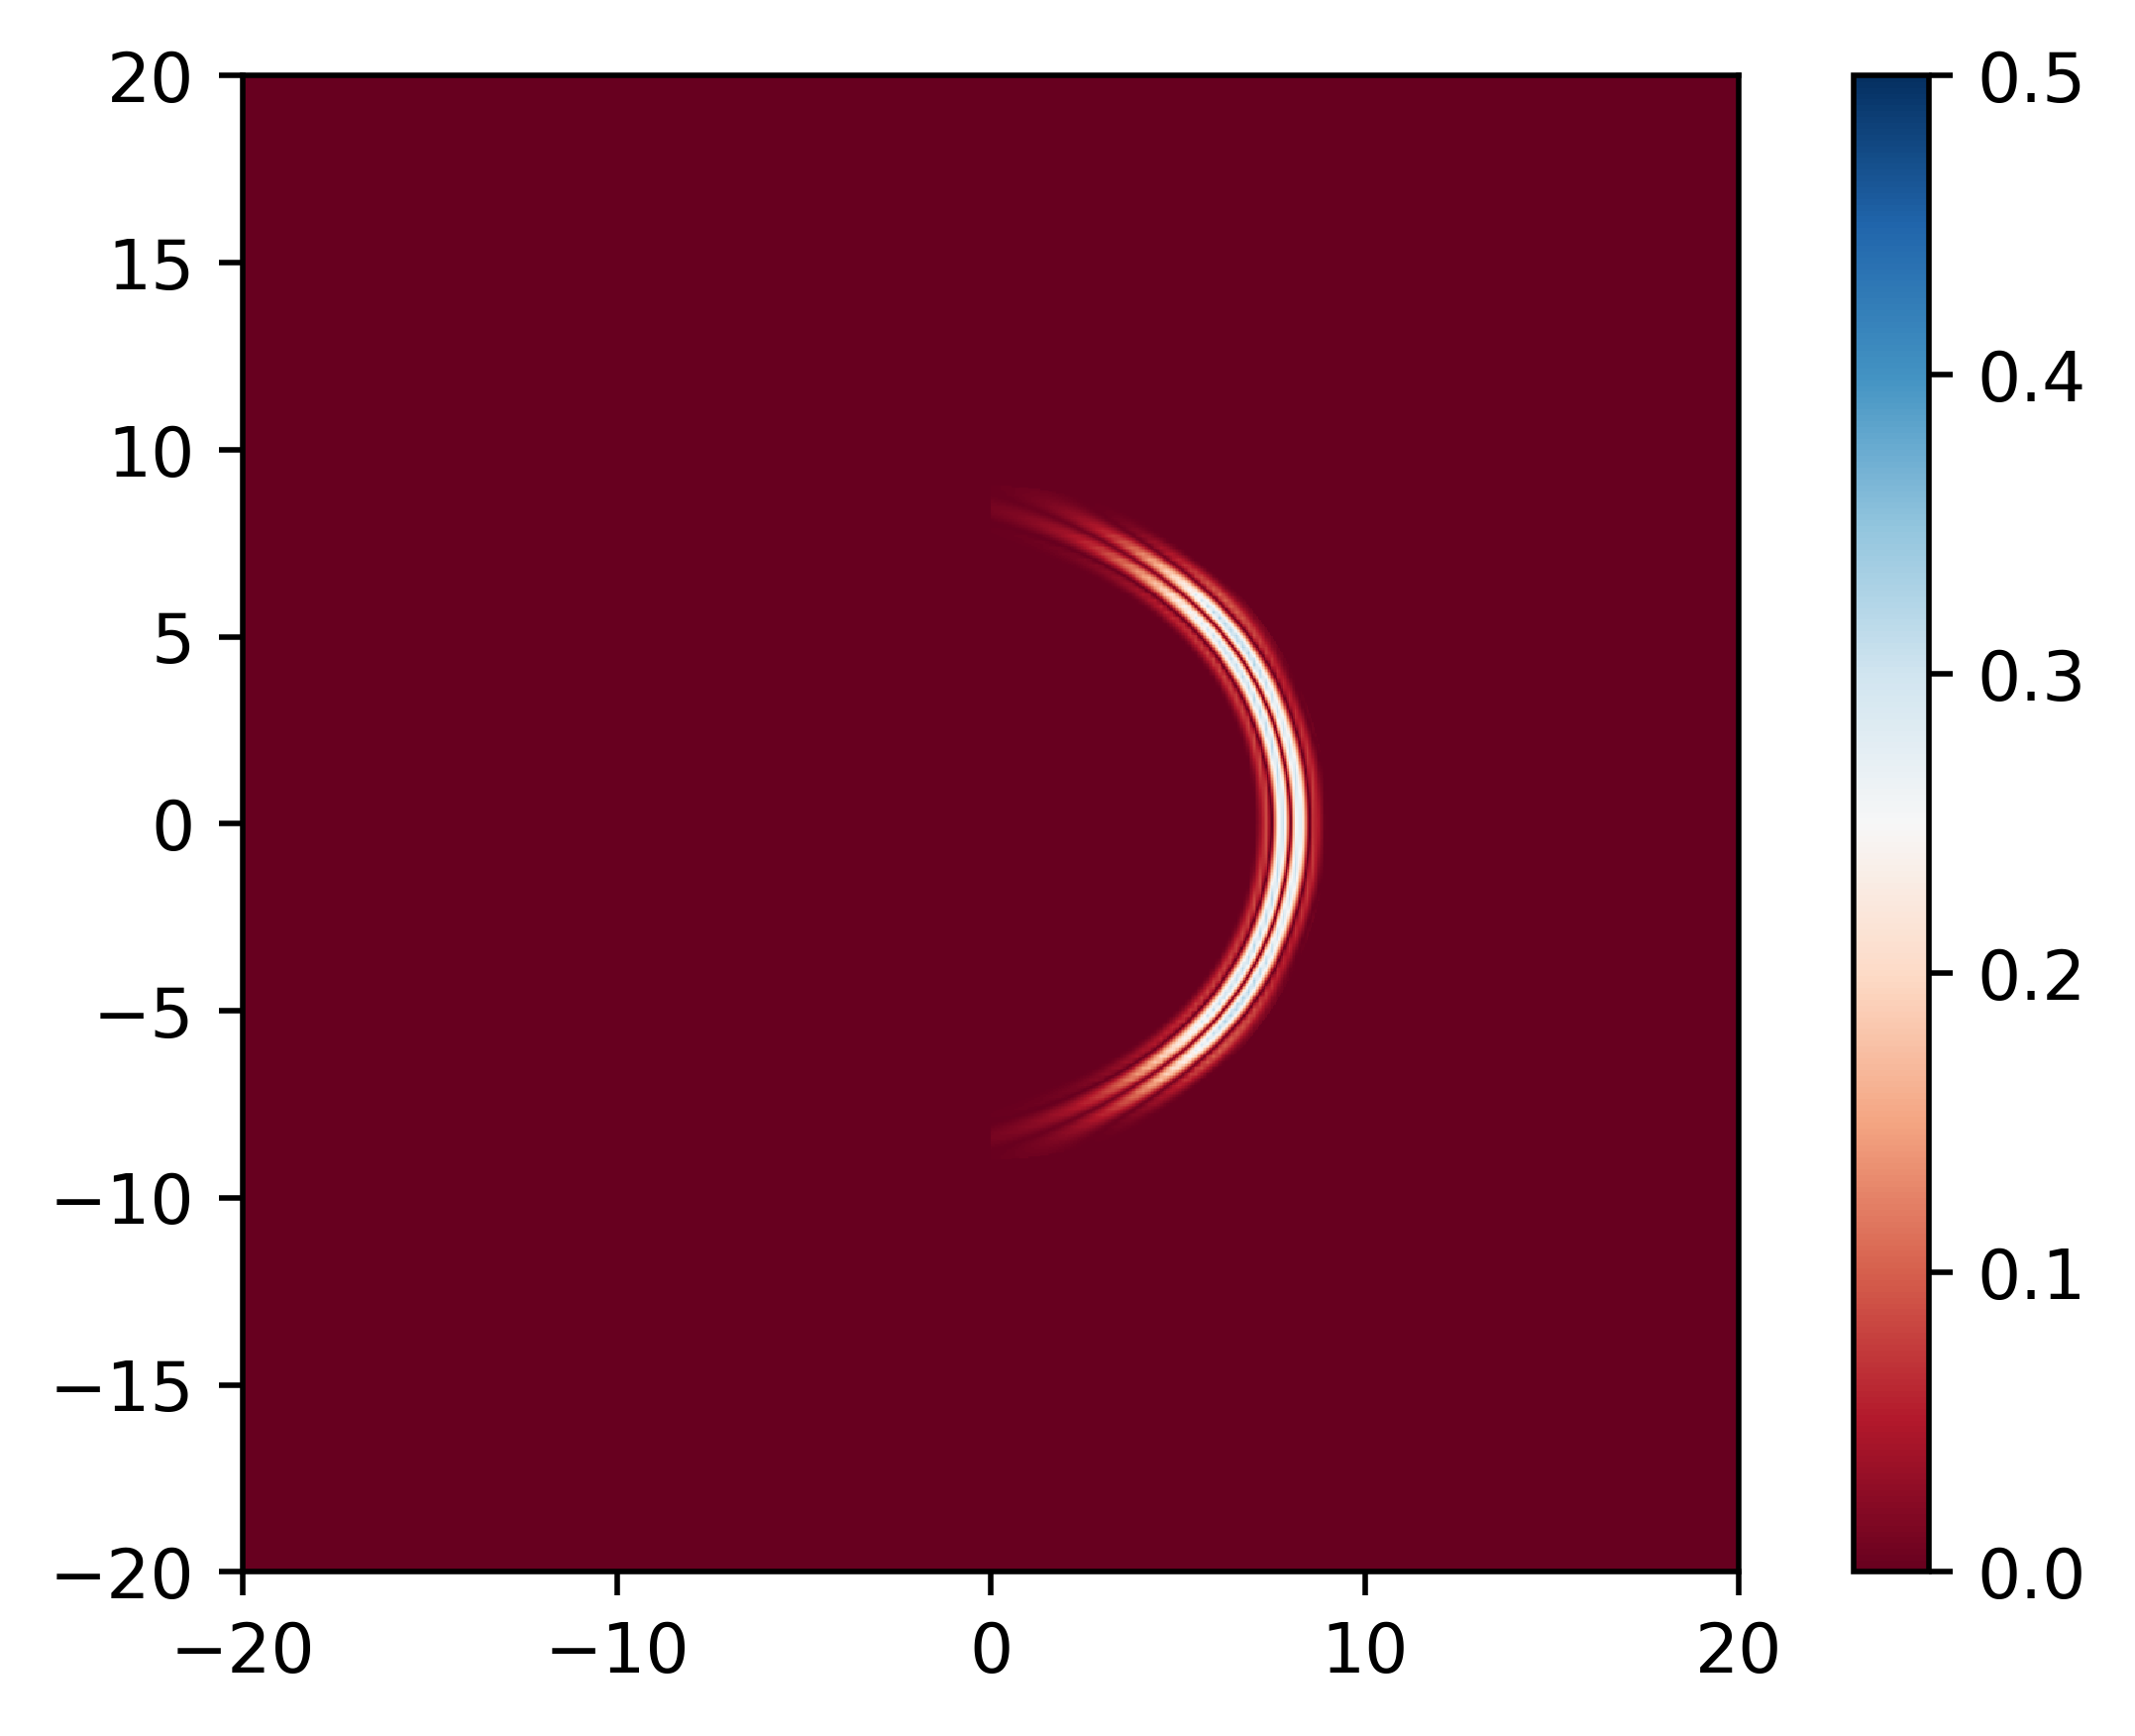

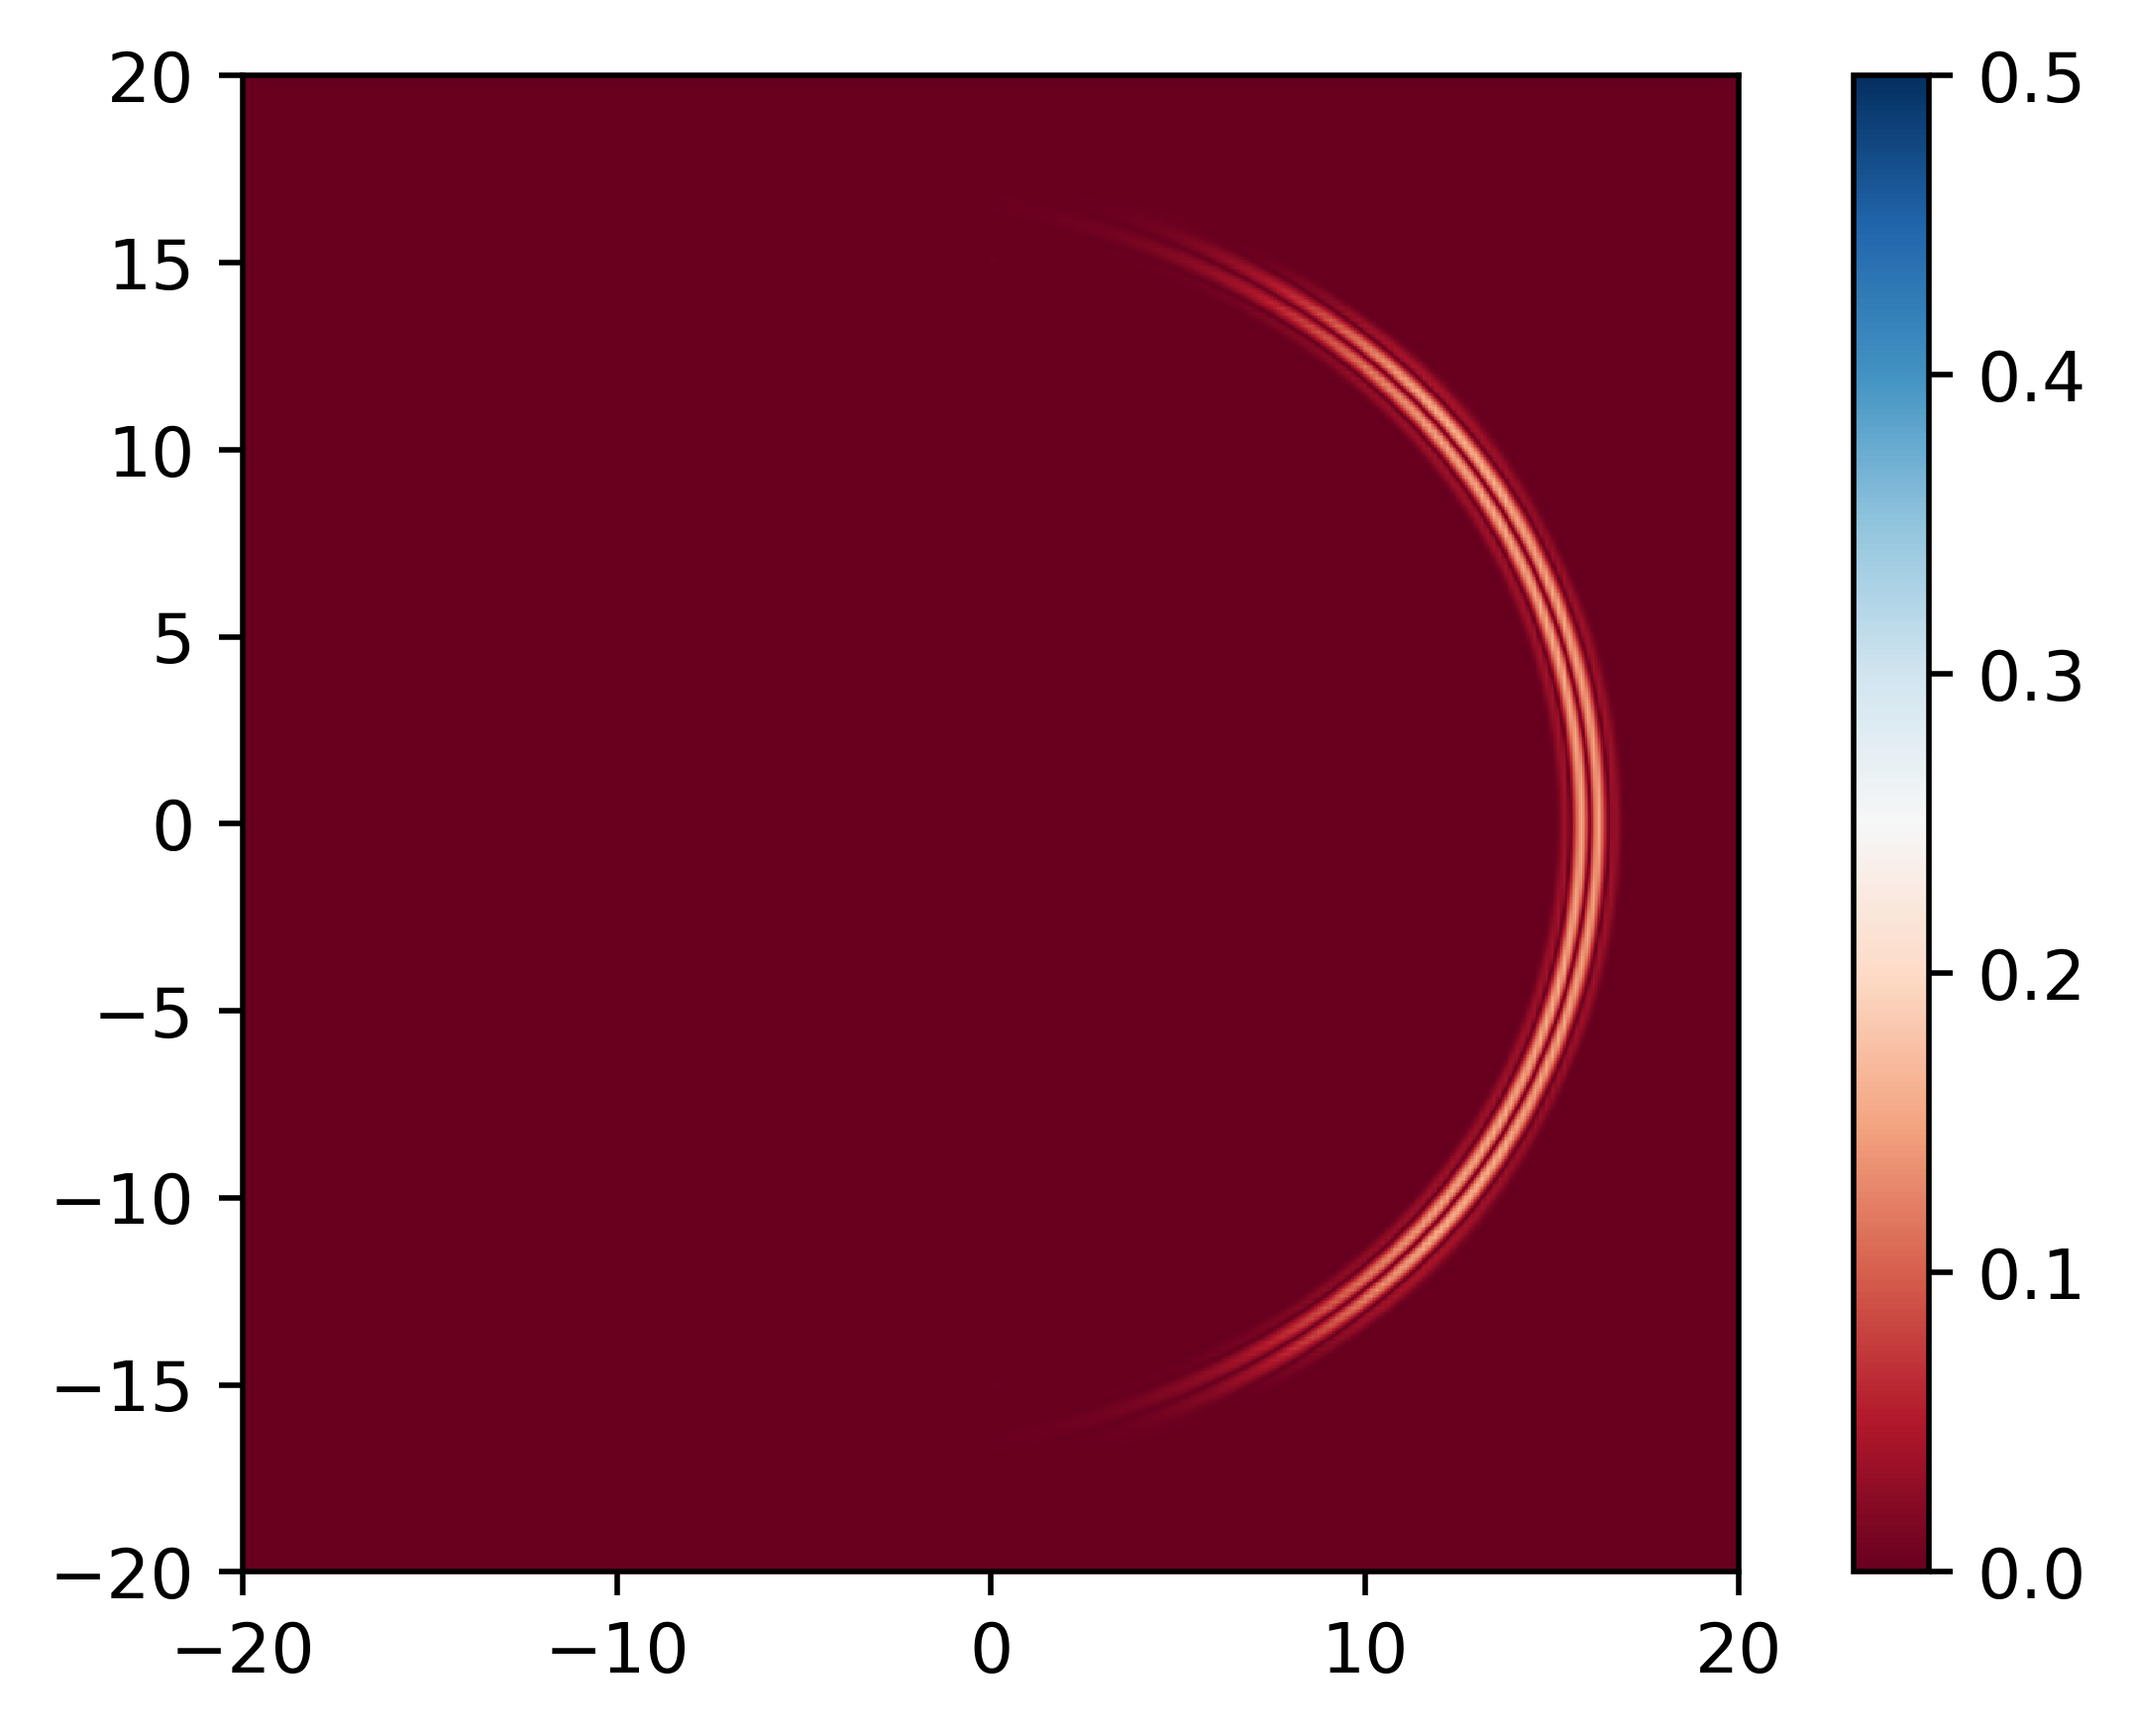

In [67]:
for iter in range(3):
    fieldSolver.updateFields()
    plot_im(getField())
    if iter == 0:  # time = R0*hichi.c
        peak_int_band = getField().max()
        print("Peak intensity is %f" % (peak_int_band))

It can be seen that when determining the peak intensity, the error of the scheme was only 0.01% relative to the simulation in full entire region.

In [68]:
error = abs(peak_int_band-peak_int)/peak_int*100
print(("Error of scheme is %0.3f" % (error)) + "%")

Error of scheme is 0.011%
